## Regression Analysis of Difference Causes

Question: What is the cause of such differences in relative difference? 



### 1. Import Libs and Load Data

#### 1.1 Libs

In [42]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_rel, wilcoxon
import seaborn as sns
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import Point

from xgboost import plot_importance
from sklearn.inspection import PartialDependenceDisplay

# Mapping the MSOA

import matplotlib.colors as colors
import matplotlib.cm as cm

# import regression and xgboost:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import GradientBoostingRegressor

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import statsmodels.formula.api as smf


from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt


from sklearn.inspection import PartialDependenceDisplay

# xgboost:
import xgboost as xgb
from statsmodels.tools.tools import add_constant


#### 1.2 Prepare and Load Data:

In [4]:
# load TTMs
r5TTM = pd.read_csv(r'/mnt/d/University College London/Chen, Huanfa - Dissertation_Mengyu_Ding/Data/greater_london_od_mat_all/ttm_r5py_nan_handled.csv', encoding='latin1')

hereTTM = pd.read_csv(r'/mnt/d/University College London/Chen, Huanfa - Dissertation_Mengyu_Ding/Data/greater_london_od_mat_all/here_routing_matrix_format.csv', encoding='latin1')
# osrm not in mattrix format yet!
osrm_TTM = pd.read_csv(r'/mnt/d/University College London/Chen, Huanfa - Dissertation_Mengyu_Ding/Data/greater_london_od_mat_all/osrmTTM.csv', encoding='latin1')

val_TTM = pd.read_csv(r'/mnt/d/University College London/Chen, Huanfa - Dissertation_Mengyu_Ding/Data/ttm_valhalla.csv', encoding='latin1')
# make the first column the index:
r5TTM.set_index('originID', inplace=True)
hereTTM.set_index('originID', inplace=True)
osrm_TTM.set_index('origin_msoaID', inplace=True)
val_TTM.set_index('originID', inplace=True)
# times 60 for all elements in the matrix
r5TTM = r5TTM * 60

# MSOA Coordinates Lookup Table
msoa_london = pd.read_csv(r'/mnt/d/University College London/Chen, Huanfa - Dissertation_Mengyu_Ding/Data/msoa/processed/gld_msoa_centroids.csv', encoding='latin1')
# see if the column msoa21cd is unique:
msoa_london['msoa21cd'].nunique() == msoa_london.shape[0]

# follow this format: [{"lat": ..., "lng": ...}, ...]

# new dict origin: 1002 maoas
all_MSOA_coord_dict = {}

# for reference dict, read the msoa_london, use msoa21cd as key, lat and lon as value:
for i in range(msoa_london.shape[0]):
    msoaID = msoa_london.iloc[i, 3]
    lat = msoa_london.iloc[i, 8]
    lon = msoa_london.iloc[i, 9]
    #origin_coord.append({"lat": lat, "lng": lon})
    all_MSOA_coord_dict[msoaID] = {"lat": lat, "lng": lon}
all_MSOA_coord_df = pd.DataFrame(all_MSOA_coord_dict).T
all_MSOA_coord_df = all_MSOA_coord_df.reset_index()

all_MSOA_coord_df.columns = ['id', 'lat', 'lon']

all_MSOA_coord_df['geometry'] = all_MSOA_coord_df.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
all_MSOA_gdf = gpd.GeoDataFrame(all_MSOA_coord_df, geometry='geometry')
all_MSOA_gdf.set_crs(epsg=4326, inplace=True)  

id        lat       lon                   geometry
0     E02000318  51.488265  0.095618   POINT (0.09562 51.48827)
1     E02000388  51.483157 -0.198445  POINT (-0.19845 51.48316)
2     E02000652  51.415041 -0.138046  POINT (-0.13805 51.41504)
3     E02000963  51.529079 -0.209371  POINT (-0.20937 51.52908)
4     E02000651  51.419153 -0.125942  POINT (-0.12594 51.41915)
...         ...        ...       ...                        ...
997   E02000481  51.558124  0.293234   POINT (0.29323 51.55812)
998   E02000885  51.512556 -0.053381  POINT (-0.05338 51.51256)
999   E02000674  51.441193 -0.001961  POINT (-0.00196 51.44119)
1000  E02000975  51.514949 -0.179854  POINT (-0.17985 51.51495)
1001  E02000211  51.383183 -0.046850  POINT (-0.04685 51.38318)

[1002 rows x 4 columns]

difference matrix:

In [5]:
# Relative difference matrices
re_diff_r5_here = ((r5TTM - hereTTM) / hereTTM) * 100
re_diff_osrm_here = ((osrm_TTM - hereTTM) / hereTTM) * 100
re_diff_val_here = ((val_TTM - hereTTM) / hereTTM) * 100


unstack the table and merge with MSOA coordinate

In [4]:
def unstack_diff_mat(input_diff_df):
    """
  
    """
    # 
    diff_dataframe = input_diff_df.unstack().reset_index()
    diff_dataframe.columns = [ 'destinationID', 'originID', 're_diff_tt']
    return diff_dataframe

In [5]:
re_diff_r5_df = unstack_diff_mat(re_diff_r5_here)
re_diff_osrm_df = unstack_diff_mat(re_diff_osrm_here)
re_diff_val_df = unstack_diff_mat(re_diff_val_here)

remove all travel-to-iteself cases:

In [6]:
# caclate the number of nans in column re_diff_tt: 
re_diff_r5_df['re_diff_tt'].isna().sum()

1002

In [7]:
re_diff_osrm_df['re_diff_tt'].isna().sum()

1002

In [8]:
re_diff_val_df['re_diff_tt'].isna().sum()

1002

In [9]:
# remove all nan rows:
re_diff_r5_df.dropna(inplace=True)
re_diff_osrm_df.dropna(inplace=True)
re_diff_val_df.dropna(inplace=True)

In [10]:
re_diff_r5_df.head()

destinationID   originID  re_diff_tt
1     E02000001  E02000002  -15.267176
2     E02000001  E02000003  -23.106796
3     E02000001  E02000004  -14.425428
4     E02000001  E02000005  -18.777293
5     E02000001  E02000007  -19.117647

In [12]:
all_MSOA_gdf_copy = all_MSOA_gdf.copy()

In [13]:
all_MSOA_gdf_copy.head()

id        lat       lon                   geometry
0  E02000318  51.488265  0.095618   POINT (0.09562 51.48827)
1  E02000388  51.483157 -0.198445  POINT (-0.19845 51.48316)
2  E02000652  51.415041 -0.138046  POINT (-0.13805 51.41504)
3  E02000963  51.529079 -0.209371  POINT (-0.20937 51.52908)
4  E02000651  51.419153 -0.125942  POINT (-0.12594 51.41915)

now merge with lat lon information:

In [14]:
#re_diff_r5_df.shape
#re_diff_osrm_df.shape

all_MSOA_gdf_copy = all_MSOA_gdf.copy()
# Renaming columns to match IDs in top_under_re_diff_osrm_here_top_n
all_MSOA_gdf_copy = all_MSOA_gdf_copy.rename(columns={'id': 'ID', 'lat': 'latitude', 'lon': 'longitude'})

def merge_msoa_with_coord(input_df):
    # Merge on originID
    merged_df = input_df.merge(all_MSOA_gdf_copy, how='left', left_on='originID', right_on='ID')
    merged_df = merged_df.rename(columns={'latitude': 'origin_lat', 'longitude': 'origin_lon'})
    merged_df = merged_df.drop(columns=['ID'])

    # Merge on destinationID
    merged_df = merged_df.merge(all_MSOA_gdf_copy, how='left', left_on='destinationID', right_on='ID')
    merged_df = merged_df.rename(columns={'latitude': 'destination_lat', 'longitude': 'destination_lon'})
    merged_df = merged_df.drop(columns=['ID'])
    return merged_df

In [15]:
with_cood_r5 = merge_msoa_with_coord(re_diff_r5_df)
with_cood_osrm = merge_msoa_with_coord(re_diff_osrm_df)
with_cood_val = merge_msoa_with_coord(re_diff_val_df)

In [16]:
# drop columnL geometry_x and geometry_y:
with_cood_r5.drop(columns=['geometry_x', 'geometry_y'], inplace=True)

with_cood_osrm.drop(columns=['geometry_x', 'geometry_y'], inplace=True)

with_cood_val.drop(columns=['geometry_x', 'geometry_y'], inplace=True)

In [17]:
with_cood_r5.head()

destinationID   originID  re_diff_tt  origin_lat  origin_lon  \
0     E02000001  E02000002  -15.267176   51.588242    0.139471   
1     E02000001  E02000003  -23.106796   51.574923    0.140919   
2     E02000001  E02000004  -14.425428   51.555446    0.176841   
3     E02000001  E02000005  -18.777293   51.561414    0.143309   
4     E02000001  E02000007  -19.117647   51.558095    0.157363   

   destination_lat  destination_lon  
0        51.514382        -0.092411  
1        51.514382        -0.092411  
2        51.514382        -0.092411  
3        51.514382        -0.092411  
4        51.514382        -0.092411

### 2. Adding Columns and Normalising the Varibles
Now we need to add a few columns: 

First, add a column of Eucliden Distance between the origin and destination.

Second, categorical columns to denote wether orgin or destination belongs to central, inner, or outer London:
(in total, 6 columns)
'o_central_London': 
'o_inner_London': 
'o_outer_London':
'd_central_London':
'd__inner_London':
'd_outer_London':

Third, categorical columns to denote the interaction type of O-D:
(OD-Interaction Type) 
df['central_to_central'] = df['o_central_London'] * df['d_central_London']
df['central_to_inner'] = df['o_central_London'] * df['d_inner_London']
df['central_to_outer'] = df['o_central_London'] * df['d_outer_London']
df['inner_to_central'] = df['o_inner_London'] * df['d_central_London']
df['inner_to_inner'] = df['o_inner_London'] * df['d_inner_London']
df['inner_to_outer'] = df['o_inner_London'] * df['d_outer_London']
df['outer_to_central'] = df['o_outer_London'] * df['d_central_London']
df['outer_to_inner'] = df['o_outer_London'] * df['d_inner_London']
df['outer_to_outer'] = df['o_outer_London'] * df['d_outer_London']



#### 2.1 Create Euclidean Distance Column

In [18]:
# add the euclidean distance between origin and destination column:
def add_euclidean_distance(input_df):
    input_df['euclidean_distance'] = input_df.apply(lambda row: np.sqrt((row['origin_lat'] - row['destination_lat'])**2 + (row['origin_lon'] - row['destination_lon'])**2), axis=1)
    return input_df

with_cood_r5 = add_euclidean_distance(with_cood_r5)
with_cood_osrm = add_euclidean_distance(with_cood_osrm)
with_cood_val = add_euclidean_distance(with_cood_val)

In [81]:
with_cood_r5.head()

destinationID   originID  re_diff_tt  origin_lat  origin_lon  \
0     E02000001  E02000002  -15.267176   51.588242    0.139471   
1     E02000001  E02000003  -23.106796   51.574923    0.140919   
2     E02000001  E02000004  -14.425428   51.555446    0.176841   
3     E02000001  E02000005  -18.777293   51.561414    0.143309   
4     E02000001  E02000007  -19.117647   51.558095    0.157363   

   destination_lat  destination_lon  euclidean_distance  
0        51.514382        -0.092411            0.243361  
1        51.514382        -0.092411            0.241056  
2        51.514382        -0.092411            0.272366  
3        51.514382        -0.092411            0.240367  
4        51.514382        -0.092411            0.253570

#### 2.2 Get the Inner, Outer, Central London Lookup Table and Merge with Diff Dataframe

In [19]:
# read all boroughs
london_boroughs = pd.read_csv(r'/mnt/d/University College London/Chen, Huanfa - Dissertation_Mengyu_Ding/Data/london_boroughs.csv', encoding='latin1')

In [ ]:
london_boroughs

In [20]:
# read in the shp file:
london_boroughs_shp = gpd.read_file(r'/mnt/d/Downloads/lp-consultation-oct-2009-inner-outer-london-shp.zip')

In [21]:
london_boroughs_shp.head()

Boundary                          Source        Area_Ha     Shape_Leng  \
0  Inner London  London Plan Consultation Draft   34863.295694  117020.737488   
1  Outer London  London Plan Consultation Draft  124606.812118  373367.664448   

     Shape_Area                                           geometry  
0  3.486330e+08  POLYGON ((522055.597 178014.703, 521975.801 17...  
1  1.246068e+09  POLYGON ((503611.197 175520.397, 503613.300 17...

In [22]:
# convert london_boroughs_shp to epsg 4326
london_boroughs_shp = london_boroughs_shp.to_crs(epsg=4326)

In [23]:
all_MSOA_gdf_copy

ID   latitude  longitude                   geometry
0     E02000318  51.488265   0.095618   POINT (0.09562 51.48827)
1     E02000388  51.483157  -0.198445  POINT (-0.19845 51.48316)
2     E02000652  51.415041  -0.138046  POINT (-0.13805 51.41504)
3     E02000963  51.529079  -0.209371  POINT (-0.20937 51.52908)
4     E02000651  51.419153  -0.125942  POINT (-0.12594 51.41915)
...         ...        ...        ...                        ...
997   E02000481  51.558124   0.293234   POINT (0.29323 51.55812)
998   E02000885  51.512556  -0.053381  POINT (-0.05338 51.51256)
999   E02000674  51.441193  -0.001961  POINT (-0.00196 51.44119)
1000  E02000975  51.514949  -0.179854  POINT (-0.17985 51.51495)
1001  E02000211  51.383183  -0.046850  POINT (-0.04685 51.38318)

[1002 rows x 4 columns]

In [24]:
# Ensure both GeoDataFrames use the same coordinate reference system (CRS)
#all_MSOA_gdf_copy = all_MSOA_gdf_copy.to_crs(london_boroughs_shp.crs)

# Perform the spatial join to add a new column indicating Inner or Outer London
joined_gdf = gpd.sjoin(all_MSOA_gdf_copy, london_boroughs_shp[['Boundary', 'geometry']], how='left', op='within')

# Add the 'London_Region' column to the original GeoDataFrame
all_MSOA_gdf_copy['London_Region'] = joined_gdf['Boundary']

/home/mengyuwsl/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [25]:
from shapely.geometry import Polygon, Point

central_london_coords = [
    (-0.12571684053151008, 51.49866057432833),
    (-0.13968769063539002, 51.50238860523204),
    (-0.1363782896829294, 51.51085692178077),
    (-0.1340139406523165, 51.51379953546763),
    (-0.1304409924646816, 51.51559767301869),
    (-0.11788447256543533, 51.513634454667255),
    (-0.11683431480180204, 51.512293715502466),
    (-0.11468336233001433, 51.506244461307084),
    (-0.11936042989963426, 51.50179858331359),
    (-0.12109413427745679, 51.50081795593914),
    (-0.12571684053151008, 51.49866057432833)
]

In [26]:
# Create a Polygon for Central London
central_london_polygon = Polygon(central_london_coords)

# Create a GeoDataFrame for Central London Polygon
central_london_gdf = gpd.GeoDataFrame(index=[0], crs=all_MSOA_gdf_copy.crs, geometry=[central_london_polygon])

central_london_gdf=central_london_gdf.to_crs(london_boroughs_shp.crs)

# Update 'London_Region' column to identify Central London MSOAs
all_MSOA_gdf_copy['London_Region'] = all_MSOA_gdf_copy.apply(
    lambda row: 'Central London' if central_london_polygon.contains(row['geometry']) else row['London_Region'],
    axis=1
)

Note Central London defined: https://www.google.com/maps/place/Central+London,+London+SW1A+2DR/@51.5063244,-0.1588718,13.25z/data=!4m6!3m5!1s0x487604ce37bbdb95:0x5120415568fd2d8b!8m2!3d51.5074256!4d-0.1271814!16zL20vMDI2djd6?entry=ttu


In [27]:
central_london_gdf.head()

geometry
0  POLYGON ((-0.12572 51.49866, -0.13969 51.50239...

In [28]:
# Count how many are in central london:
all_MSOA_gdf_copy['London_Region'].value_counts()

London_Region
Outer London      598
Inner London      403
Central London      1
Name: count, dtype: int64

In [82]:
all_MSOA_gdf_copy.head()

ID   latitude  longitude                   geometry London_Region
0  E02000318  51.488265   0.095618   POINT (0.09562 51.48827)  Inner London
1  E02000388  51.483157  -0.198445  POINT (-0.19845 51.48316)  Inner London
2  E02000652  51.415041  -0.138046  POINT (-0.13805 51.41504)  Inner London
3  E02000963  51.529079  -0.209371  POINT (-0.20937 51.52908)  Inner London
4  E02000651  51.419153  -0.125942  POINT (-0.12594 51.41915)  Inner London

In [29]:
def add_london_region_info(coord_df, msoa_gdf):
    # Create dictionaries for quick lookup
    msoa_region_dict = msoa_gdf.set_index('ID')['London_Region'].to_dict()
    
    # Function to determine region based on MSOA ID
    def get_region(msoa_id):
        return msoa_region_dict.get(msoa_id, 'Unknown')
    
    # Add new columns to the dataframe
    coord_df['origin_region'] = coord_df['originID'].apply(get_region)
    coord_df['destination_region'] = coord_df['destinationID'].apply(get_region)
    
    return coord_df

with_cood_r5 = add_london_region_info(with_cood_r5, all_MSOA_gdf_copy)
with_cood_osrm  = add_london_region_info(with_cood_osrm , all_MSOA_gdf_copy)
with_cood_val  = add_london_region_info(with_cood_val , all_MSOA_gdf_copy)


In [31]:
#with_cood_osrm.head()
#with_cood_r5
with_cood_val

destinationID   originID  re_diff_tt  origin_lat  origin_lon  \
0           E02000001  E02000002  -33.366489   51.588242    0.139471   
1           E02000001  E02000003  -34.249709   51.574923    0.140919   
2           E02000001  E02000004  -26.861899   51.555446    0.176841   
3           E02000001  E02000005  -26.890437   51.561414    0.143309   
4           E02000001  E02000007  -28.545180   51.558095    0.157363   
...               ...        ...         ...         ...         ...   
1002997     E02007115  E02007110  -43.822209   51.529375   -0.085018   
1002998     E02007115  E02007111  -46.070330   51.526441   -0.079636   
1002999     E02007115  E02007112  -34.689097   51.509406    0.002235   
1003000     E02007115  E02007113  -31.520011   51.506297   -0.008865   
1003001     E02007115  E02007114  -33.358634   51.498320   -0.010985   

         destination_lat  destination_lon  euclidean_distance origin_region  \
0              51.514382        -0.092411            0.243361  Outer London   
1              51.514382        -0.092411            0.241056  Outer London   
2              51.514382        -0.092411            0.272366  Outer London   
3              51.514382        -0.092411            0.240367  Outer London   
4              51.514382        -0.092411            0.253570  Outer London   
...                  ...              ...                 ...           ...   
1002997        51.526920        -0.121559            0.036623  Inner London   
1002998        51.526920        -0.121559            0.041925  Inner London   
1002999        51.526920        -0.121559            0.125027  Inner London   
1003000        51.526920        -0.121559            0.114566  Inner London   
1003001        51.526920        -0.121559            0.114213  Inner London   

        destination_region  
0             Inner London  
1             Inner London  
2             Inner London  
3             Inner London  
4             Inner London  
...                    ...  
1002997       Inner London  
1002998       Inner London  
1002999       Inner London  
1003000       Inner London  
1003001       Inner London  

[1003002 rows x 10 columns]

In [32]:
with_cood_r5.to_csv(r'/mnt/d/University College London/Chen, Huanfa - Dissertation_Mengyu_Ding/Data/greater_london_od_mat_all/re_diff_r5.csv', index=False)

with_cood_osrm.to_csv(r'/mnt/d/University College London/Chen, Huanfa - Dissertation_Mengyu_Ding/Data/greater_london_od_mat_all/re_diff_osrm.csv', index=False)

with_cood_val.to_csv(r'/mnt/d/University College London/Chen, Huanfa - Dissertation_Mengyu_Ding/Data/greater_london_od_mat_all/re_diff_val.csv', index=False)

#### 2.3 Variable Normalisation etc. Data Processing for Lin. Reg.

In [2]:
r5_diff = pd.read_csv(r'/mnt/d/University College London/Chen, Huanfa - Dissertation_Mengyu_Ding/Data/greater_london_od_mat_all/re_diff_r5.csv', encoding = 'latin1')
osrm_diff = pd.read_csv(r'/mnt/d/University College London/Chen, Huanfa - Dissertation_Mengyu_Ding/Data/greater_london_od_mat_all/re_diff_osrm.csv', encoding = 'latin1')
val_diff = pd.read_csv(r'/mnt/d/University College London/Chen, Huanfa - Dissertation_Mengyu_Ding/Data/greater_london_od_mat_all/re_diff_val.csv', encoding = 'latin1')

In [4]:
r5_diff.head()

destinationID   originID  re_diff_tt  origin_lat  origin_lon  \
0     E02000001  E02000002  -15.267176   51.588242    0.139471   
1     E02000001  E02000003  -23.106796   51.574923    0.140919   
2     E02000001  E02000004  -14.425428   51.555446    0.176841   
3     E02000001  E02000005  -18.777293   51.561414    0.143309   
4     E02000001  E02000007  -19.117647   51.558095    0.157363   

   destination_lat  destination_lon  euclidean_distance origin_region  \
0        51.514382        -0.092411            0.243361  Outer London   
1        51.514382        -0.092411            0.241056  Outer London   
2        51.514382        -0.092411            0.272366  Outer London   
3        51.514382        -0.092411            0.240367  Outer London   
4        51.514382        -0.092411            0.253570  Outer London   

  destination_region  
0       Inner London  
1       Inner London  
2       Inner London  
3       Inner London  
4       Inner London

In [35]:
#r5_diff.head()

osrm_diff.head()

destinationID   originID  re_diff_tt  origin_lat  origin_lon  \
0     E02000001  E02000002  -19.576336   51.588242    0.139471   
1     E02000001  E02000003  -23.180583   51.574923    0.140919   
2     E02000001  E02000004  -16.475143   51.555446    0.176841   
3     E02000001  E02000005  -17.144105   51.561414    0.143309   
4     E02000001  E02000007  -14.897876   51.558095    0.157363   

   destination_lat  destination_lon  euclidean_distance origin_region  \
0        51.514382        -0.092411            0.243361  Outer London   
1        51.514382        -0.092411            0.241056  Outer London   
2        51.514382        -0.092411            0.272366  Outer London   
3        51.514382        -0.092411            0.240367  Outer London   
4        51.514382        -0.092411            0.253570  Outer London   

  destination_region  
0       Inner London  
1       Inner London  
2       Inner London  
3       Inner London  
4       Inner London

save a coord lookup table:

In [5]:
# coord_lookup has column destinationID, originID, destination_lat, destination_lon, origin_lat, origin_lon:
coord_lookup = osrm_diff[['destinationID', 'originID', 'destination_lat', 'destination_lon', 'origin_lat', 'origin_lon']].copy()

In [6]:
coord_lookup.head()

destinationID   originID  destination_lat  destination_lon  origin_lat  \
0     E02000001  E02000002        51.514382        -0.092411   51.588242   
1     E02000001  E02000003        51.514382        -0.092411   51.574923   
2     E02000001  E02000004        51.514382        -0.092411   51.555446   
3     E02000001  E02000005        51.514382        -0.092411   51.561414   
4     E02000001  E02000007        51.514382        -0.092411   51.558095   

   origin_lon  
0    0.139471  
1    0.140919  
2    0.176841  
3    0.143309  
4    0.157363

In [3]:
# create new columns for dataframe called destination_central, destination_inner, destination_outer, origin_central, origin_inner, origin_outer, if the origin or destination is in central, inner or outer london, values only 1 and 0:
def one_hot_encode_regions(df):
    for col in ['origin_region', 'destination_region']:
        for region in ['Central London', 'Inner London', 'Outer London']:
            new_col = f"{col}_{region.replace(' ', '_')}"  # Create column name
            df[new_col] = (df[col] == region).astype(int)  # 1 if match, 0 otherwise
    return df

re_diff_r5_encoded = one_hot_encode_regions(r5_diff)
re_diff_osrm_encoded = one_hot_encode_regions(osrm_diff)
re_diff_val_encoded = one_hot_encode_regions(val_diff)

In [4]:
re_diff_r5_encoded.head()

destinationID   originID  re_diff_tt  origin_lat  origin_lon  \
0     E02000001  E02000002  -15.267176   51.588242    0.139471   
1     E02000001  E02000003  -23.106796   51.574923    0.140919   
2     E02000001  E02000004  -14.425428   51.555446    0.176841   
3     E02000001  E02000005  -18.777293   51.561414    0.143309   
4     E02000001  E02000007  -19.117647   51.558095    0.157363   

   destination_lat  destination_lon  euclidean_distance origin_region  \
0        51.514382        -0.092411            0.243361  Outer London   
1        51.514382        -0.092411            0.241056  Outer London   
2        51.514382        -0.092411            0.272366  Outer London   
3        51.514382        -0.092411            0.240367  Outer London   
4        51.514382        -0.092411            0.253570  Outer London   

  destination_region  origin_region_Central_London  \
0       Inner London                             0   
1       Inner London                             0   
2       Inner London                             0   
3       Inner London                             0   
4       Inner London                             0   

   origin_region_Inner_London  origin_region_Outer_London  \
0                           0                           1   
1                           0                           1   
2                           0                           1   
3                           0                           1   
4                           0                           1   

   destination_region_Central_London  destination_region_Inner_London  \
0                                  0                                1   
1                                  0                                1   
2                                  0                                1   
3                                  0                                1   
4                                  0                                1   

   destination_region_Outer_London  
0                                0  
1                                0  
2                                0  
3                                0  
4                                0

add these columns for calculation of haversine_distance (KM) between OD, and h_dist_o_london_centre, and h_dist_d_london_centre:

hence, we are not using the euclidean one, that one may have problems since it's a simple calculation off a degree measure.

Columns:

'origin_region_Central_London + origin_region_Inner_London + origin_region_Outer_London + destination_region_Central_London + destination_region_Inner_London + destination_region_Outer_London + dist_to_central_point_origin + dist_to_central_point_dest + havsine_distance_OD'

In [5]:
# Define the Haversine distance function
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the Haversine distance between two points on the Earth's surface.

    Args:
        lat1 (float): Latitude of the first point in degrees.
        lon1 (float): Longitude of the first point in degrees.
        lat2 (float): Latitude of the second point in degrees.
        lon2 (float): Longitude of the second point in degrees.

    Returns:
        float: The Haversine distance between the two points in kilometers.
    """
    R = 6371  # Earth radius in kilometers

    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c

    return distance

London Centre, which is around Charing Cross:

In [6]:
# Central London coordinates
central_london_lat = 51.508088421056335
central_london_lon = -0.12736998079915138

In [7]:
re_diff_osrm_encoded['dist_to_central_point_origin'] = re_diff_osrm_encoded.apply(
    lambda row: haversine_distance(
        row['origin_lat'], row['origin_lon'], central_london_lat, central_london_lon
    ),
    axis=1,
)

re_diff_osrm_encoded['dist_to_central_point_dest'] = re_diff_osrm_encoded.apply(
    lambda row: haversine_distance(
        row['destination_lat'], row['destination_lon'], central_london_lat, central_london_lon
    ),
    axis=1,
)

re_diff_r5_encoded['dist_to_central_point_origin'] = re_diff_r5_encoded.apply(
    lambda row: haversine_distance(
        row['origin_lat'], row['origin_lon'], central_london_lat, central_london_lon
    ),
    axis=1,
)

re_diff_r5_encoded['dist_to_central_point_dest'] = re_diff_r5_encoded.apply(
    lambda row: haversine_distance(
        row['destination_lat'], row['destination_lon'], central_london_lat, central_london_lon
    ),
    axis=1,
)


re_diff_val_encoded['dist_to_central_point_origin'] = re_diff_val_encoded.apply(
    lambda row: haversine_distance(
        row['origin_lat'], row['origin_lon'], central_london_lat, central_london_lon
    ),
    axis=1,
)

re_diff_val_encoded['dist_to_central_point_dest'] = re_diff_val_encoded.apply(
    lambda row: haversine_distance(
        row['destination_lat'], row['destination_lon'], central_london_lat, central_london_lon
    ),
    axis=1,
)

In [8]:
re_diff_r5_encoded['havsine_distance_OD'] = re_diff_r5_encoded.apply(
    lambda row: haversine_distance(
        row['origin_lat'], row['origin_lon'], row['destination_lat'], row['destination_lon']
    ),
    axis=1,
)

re_diff_osrm_encoded['havsine_distance_OD'] = re_diff_osrm_encoded.apply(
    lambda row: haversine_distance(
        row['origin_lat'], row['origin_lon'], row['destination_lat'], row['destination_lon']
    ),
    axis=1,
)

re_diff_val_encoded['havsine_distance_OD'] = re_diff_val_encoded.apply(
    lambda row: haversine_distance(
        row['origin_lat'], row['origin_lon'], row['destination_lat'], row['destination_lon']
    ),
    axis=1,
)

In [9]:
re_diff_r5_encoded.head()

destinationID   originID  re_diff_tt  origin_lat  origin_lon  \
0     E02000001  E02000002  -15.267176   51.588242    0.139471   
1     E02000001  E02000003  -23.106796   51.574923    0.140919   
2     E02000001  E02000004  -14.425428   51.555446    0.176841   
3     E02000001  E02000005  -18.777293   51.561414    0.143309   
4     E02000001  E02000007  -19.117647   51.558095    0.157363   

   destination_lat  destination_lon  euclidean_distance origin_region  \
0        51.514382        -0.092411            0.243361  Outer London   
1        51.514382        -0.092411            0.241056  Outer London   
2        51.514382        -0.092411            0.272366  Outer London   
3        51.514382        -0.092411            0.240367  Outer London   
4        51.514382        -0.092411            0.253570  Outer London   

  destination_region  origin_region_Central_London  \
0       Inner London                             0   
1       Inner London                             0   
2       Inner London                             0   
3       Inner London                             0   
4       Inner London                             0   

   origin_region_Inner_London  origin_region_Outer_London  \
0                           0                           1   
1                           0                           1   
2                           0                           1   
3                           0                           1   
4                           0                           1   

   destination_region_Central_London  destination_region_Inner_London  \
0                                  0                                1   
1                                  0                                1   
2                                  0                                1   
3                                  0                                1   
4                                  0                                1   

   destination_region_Outer_London  dist_to_central_point_origin  \
0                                0                     20.491113   
1                                0                     19.987168   
2                                0                     21.691829   
3                                0                     19.638796   
4                                0                     20.464926   

   dist_to_central_point_dest  havsine_distance_OD  
0                    2.518461            18.013998  
1                    2.518461            17.483386  
2                    2.518461            19.175065  
3                    2.518461            17.121369  
4                    2.518461            17.946497

#### 2.4 add Population and Road network density

In [10]:
# read shp file and plot its borders on folium map:
msoa_shape = gpd.read_file(r'/mnt/d/University College London/Chen, Huanfa - Dissertation_Mengyu_Ding/Data/msoa/england_msoa_2021.shp')

In [11]:
# calculate each msoa's area, in km^2:
msoa_shape['area'] = msoa_shape.area

In [12]:
msoa_shape['area_sqkm'] = msoa_shape['area'] / 1e6
bbox = msoa_shape.total_bounds

In [13]:

osm_file = r'/mnt/d/Downloads/greater-london-latest.osm.pbf'

# import the osm file and extract the road network length for car only, by each msoa:
import osmium
from pyrosm import OSM, get_data

In [14]:
# Load the PBF file using pyrosm
osm_gl = OSM(osm_file)

# Extract the road network for vehicles (highways suitable for cars and vehicles)
# Filtering for roads that are suitable for cars
roads = osm_gl.get_network(network_type='driving')

In [15]:
edges = gpd.GeoDataFrame(roads, crs="EPSG:4326")
edges = edges.to_crs(msoa_shape.crs)

# Ensure the CRS matches between the roads and MSOA boundaries
edges = edges.to_crs(msoa_shape.crs)

# Spatial join to intersect roads with MSOA boundaries
edges_msoa = gpd.sjoin(edges, msoa_shape, how="inner", op="intersects")

# Calculate the length of each road segment within each MSOA
edges_msoa['length'] = edges_msoa.geometry.length

# Group by MSOA ID and sum the road lengths
road_length_per_msoa = edges_msoa.groupby('msoa21cd')['length'].sum().reset_index()

# Merge the road length data back with the MSOA boundaries
msoa_shape = msoa_shape.merge(road_length_per_msoa, on='msoa21cd')

# Calculate road network density
msoa_shape['road_density_km_per_sqkm'] = msoa_shape['length'] / msoa_shape['area_sqkm']

msoa_shape['road_density_km_per_sqkm'] = msoa_shape['road_density_km_per_sqkm'] / 1000


/home/mengyuwsl/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [16]:
# now add the road_density_km_per_sqkm to the re_diff_val_encoded, re_diff_r5_encoded, re_diff_osrm_encoded:
def add_road_density(input_df, msoa_shape):
    # Create dictionaries for quick lookup
    msoa_density_dict = msoa_shape.set_index('msoa21cd')['road_density_km_per_sqkm'].to_dict()
    
    # Function to determine region based on MSOA ID
    def get_density(msoa_id):
        return msoa_density_dict.get(msoa_id, 0)
    
    # Add new columns to the dataframe
    input_df['road_density_origin'] = input_df['originID'].apply(get_density)
    input_df['road_density_dest'] = input_df['destinationID'].apply(get_density)
    
    return input_df

In [17]:
re_diff_val_encoded = add_road_density(re_diff_val_encoded, msoa_shape)
re_diff_r5_encoded = add_road_density(re_diff_r5_encoded, msoa_shape)
re_diff_osrm_encoded = add_road_density(re_diff_osrm_encoded, msoa_shape)

In [18]:
#read excel file name: sapemsoasyoatablefinal(1),shee name: Mid-2021_MSOA_2021:
pop_density = pd.read_excel(r'/mnt/d/Downloads/sapemsoasyoatablefinal(1).xlsx', sheet_name='Mid-2021_MSOA_2021')
pop_density.rename(columns={'MSOA 2021 Code': 'msoa21cd'}, inplace=True)

In [19]:
# merge to the re_diff_r5_encoded, re_diff_osrm_encoded, re_diff_val_encoded:
def add_pop(input_df, pop_density):
    # Create dictionaries for quick lookup
    msoa_density_dict = pop_density.set_index('msoa21cd')['Total'].to_dict()
    
    # Function to determine region based on MSOA ID
    def get_density(msoa_id):
        return msoa_density_dict.get(msoa_id, 0)
    
    # Add new columns to the dataframe
    input_df['pop_origin'] = input_df['originID'].apply(get_density)
    input_df['pop_dest'] = input_df['destinationID'].apply(get_density)
    
    return input_df

re_diff_r5_encoded = add_pop(re_diff_r5_encoded, pop_density)
re_diff_osrm_encoded = add_pop(re_diff_osrm_encoded, pop_density)
re_diff_val_encoded = add_pop(re_diff_val_encoded, pop_density)

In [20]:
# add area 	area_sqkm to the re_diff_r5_encoded, re_diff_osrm_encoded, re_diff_val_encoded from msoa_shape:
def add_area(input_df, msoa_shape):
    # Create dictionaries for quick lookup
    msoa_density_dict = msoa_shape.set_index('msoa21cd')['area_sqkm'].to_dict()
    
    # Function to determine region based on MSOA ID
    def get_density(msoa_id):
        return msoa_density_dict.get(msoa_id, 0)
    
    # Add new columns to the dataframe
    input_df['area_origin'] = input_df['originID'].apply(get_density)
    input_df['area_dest'] = input_df['destinationID'].apply(get_density)
    
    return input_df

re_diff_r5_encoded = add_area(re_diff_r5_encoded, msoa_shape)
re_diff_osrm_encoded = add_area(re_diff_osrm_encoded, msoa_shape)
re_diff_val_encoded = add_area(re_diff_val_encoded, msoa_shape)

In [21]:
re_diff_val_encoded['pop_density_origin'] = re_diff_val_encoded['pop_origin'] / re_diff_val_encoded['area_origin']
re_diff_val_encoded['pop_density_dest'] = re_diff_val_encoded['pop_dest'] / re_diff_val_encoded['area_dest']

re_diff_r5_encoded['pop_density_origin'] = re_diff_r5_encoded['pop_origin'] / re_diff_r5_encoded['area_origin']
re_diff_r5_encoded['pop_density_dest'] = re_diff_r5_encoded['pop_dest'] / re_diff_r5_encoded['area_dest']

re_diff_osrm_encoded['pop_density_origin'] = re_diff_osrm_encoded['pop_origin'] / re_diff_osrm_encoded['area_origin']
re_diff_osrm_encoded['pop_density_dest'] = re_diff_osrm_encoded['pop_dest'] / re_diff_osrm_encoded['area_dest']

In [22]:
# save the re_diff_r5_encoded, re_diff_osrm_encoded, re_diff_val_encoded to csv:
re_diff_r5_encoded.to_csv(r'/mnt/d/University College London/Chen, Huanfa - Dissertation_Mengyu_Ding/Data/regression_data/re_diff_r5_encoded_reg_v2.csv', index=False)
re_diff_osrm_encoded.to_csv(r'/mnt/d/University College London/Chen, Huanfa - Dissertation_Mengyu_Ding/Data/regression_data/re_diff_osrm_encoded_reg_v2.csv', index=False)
re_diff_val_encoded.to_csv(r'/mnt/d/University College London/Chen, Huanfa - Dissertation_Mengyu_Ding/Data/regression_datare_diff_val_encoded_reg_v2.csv', index=False)


### Now, Normalize all and do VIF:

In [25]:
re_diff_r5_encoded.columns

Index(['destinationID', 'originID', 're_diff_tt', 'origin_lat', 'origin_lon',
       'destination_lat', 'destination_lon', 'euclidean_distance',
       'origin_region', 'destination_region', 'origin_region_Central_London',
       'origin_region_Inner_London', 'origin_region_Outer_London',
       'destination_region_Central_London', 'destination_region_Inner_London',
       'destination_region_Outer_London', 'dist_to_central_point_origin',
       'dist_to_central_point_dest', 'havsine_distance_OD',
       'road_density_origin', 'road_density_dest', 'pop_origin', 'pop_dest',
       'area_origin', 'area_dest', 'pop_density_origin', 'pop_density_dest'],
      dtype='object')

In [26]:
# Normalise the distance variables
cols_to_normalize = ['dist_to_central_point_origin', 'dist_to_central_point_dest', 'havsine_distance_OD',
                     'road_density_origin', 'road_density_dest', 'pop_density_origin', 'pop_density_dest']


scaler = StandardScaler()
re_diff_r5_encoded[cols_to_normalize] = scaler.fit_transform(re_diff_r5_encoded[cols_to_normalize])

re_diff_osrm_encoded[cols_to_normalize] = scaler.fit_transform(re_diff_osrm_encoded[cols_to_normalize])

re_diff_val_encoded[cols_to_normalize] = scaler.fit_transform(re_diff_val_encoded[cols_to_normalize])

In [27]:
columns_for_reg = ['origin_region_Central_London', 'origin_region_Inner_London', 'origin_region_Outer_London',
'destination_region_Central_London', 'destination_region_Inner_London', 'destination_region_Outer_London',
'dist_to_central_point_origin', 'dist_to_central_point_dest', 'havsine_distance_OD',
'road_density_origin', 'road_density_dest', 'pop_density_origin', 'pop_density_dest']

In [28]:
r5_regression = re_diff_r5_encoded[['origin_region_Central_London', 'origin_region_Inner_London', 'origin_region_Outer_London',
'destination_region_Central_London', 'destination_region_Inner_London', 'destination_region_Outer_London',
'dist_to_central_point_origin', 'dist_to_central_point_dest', 'havsine_distance_OD',
'road_density_origin', 'road_density_dest', 'pop_density_origin', 'pop_density_dest']]

osrm_regression = re_diff_osrm_encoded[['origin_region_Central_London', 'origin_region_Inner_London', 'origin_region_Outer_London',
'destination_region_Central_London', 'destination_region_Inner_London', 'destination_region_Outer_London',
'dist_to_central_point_origin', 'dist_to_central_point_dest', 'havsine_distance_OD',
'road_density_origin', 'road_density_dest', 'pop_density_origin', 'pop_density_dest']]

val_regression = re_diff_val_encoded[['origin_region_Central_London', 'origin_region_Inner_London', 'origin_region_Outer_London',
'destination_region_Central_London', 'destination_region_Inner_London', 'destination_region_Outer_London',
'dist_to_central_point_origin', 'dist_to_central_point_dest', 'havsine_distance_OD',
'road_density_origin', 'road_density_dest', 'pop_density_origin', 'pop_density_dest']]

In [29]:
def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [30]:
r5_regression = drop_column_using_vif_(r5_regression, thresh=2.5)

osrm_regression = drop_column_using_vif_(osrm_regression, thresh=2.5)

val_regression = drop_column_using_vif_(val_regression, thresh=2.5)

/home/mengyuwsl/.local/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/mengyuwsl/.local/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropping: origin_region_Central_London


/home/mengyuwsl/.local/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/mengyuwsl/.local/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropping: destination_region_Central_London
Dropping: origin_region_Outer_London
Dropping: destination_region_Outer_London
Dropping: pop_density_dest
Dropping: pop_density_origin
Dropping: dist_to_central_point_dest
Dropping: dist_to_central_point_origin


/home/mengyuwsl/.local/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/mengyuwsl/.local/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropping: origin_region_Central_London


/home/mengyuwsl/.local/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/mengyuwsl/.local/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropping: destination_region_Central_London
Dropping: origin_region_Outer_London
Dropping: destination_region_Outer_London
Dropping: pop_density_dest
Dropping: pop_density_origin
Dropping: dist_to_central_point_dest
Dropping: dist_to_central_point_origin


/home/mengyuwsl/.local/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/mengyuwsl/.local/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropping: origin_region_Central_London


/home/mengyuwsl/.local/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/mengyuwsl/.local/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropping: destination_region_Central_London
Dropping: origin_region_Outer_London
Dropping: destination_region_Outer_London
Dropping: pop_density_dest
Dropping: pop_density_origin
Dropping: dist_to_central_point_dest
Dropping: dist_to_central_point_origin


In [31]:
r5_regression.columns

Index(['origin_region_Inner_London', 'destination_region_Inner_London',
       'havsine_distance_OD', 'road_density_origin', 'road_density_dest'],
      dtype='object')

In [32]:
osrm_regression.columns

Index(['origin_region_Inner_London', 'destination_region_Inner_London',
       'havsine_distance_OD', 'road_density_origin', 'road_density_dest'],
      dtype='object')

In [33]:
val_regression.columns

Index(['origin_region_Inner_London', 'destination_region_Inner_London',
       'havsine_distance_OD', 'road_density_origin', 'road_density_dest'],
      dtype='object')

## 3. Lin. Reg and XGBoost 

### 3.1 Lin Reg

                            OLS Regression Results                            
Dep. Variable:             re_diff_tt   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                 2.960e+04
Date:                Fri, 16 Aug 2024   Prob (F-statistic):               0.00
Time:                        11:19:28   Log-Likelihood:            -3.8434e+06
No. Observations:             1003002   AIC:                         7.687e+06
Df Residuals:                 1002996   BIC:                         7.687e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

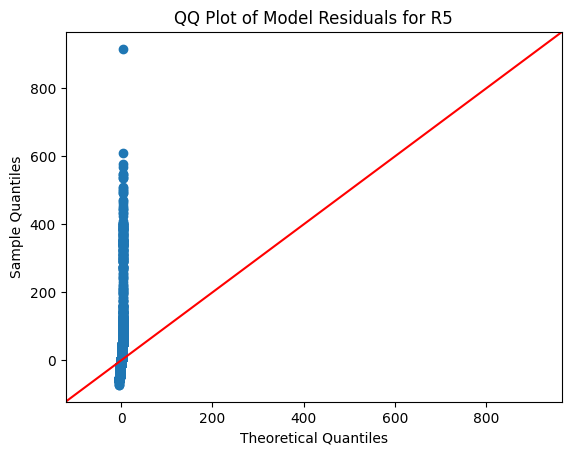

In [35]:
# Fit the linear regression model +destination_region_encoded + origin_region_encoded dist_to_central_point_origin+dist_to_central_point_dest
model_r5 = smf.ols(
    're_diff_tt ~ origin_region_Inner_London + destination_region_Inner_London + havsine_distance_OD + road_density_origin + road_density_dest',
    data=re_diff_r5_encoded,
).fit()

# Print the model summary
print(model_r5.summary())

# QQ plot of the residuals
sm.qqplot(model_r5.resid, line ='45')
plt.title('QQ Plot of Model Residuals for R5')
plt.show()

                            OLS Regression Results                            
Dep. Variable:             re_diff_tt   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                 1.537e+04
Date:                Fri, 16 Aug 2024   Prob (F-statistic):               0.00
Time:                        11:20:39   Log-Likelihood:            -3.5280e+06
No. Observations:             1003002   AIC:                         7.056e+06
Df Residuals:                 1002996   BIC:                         7.056e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

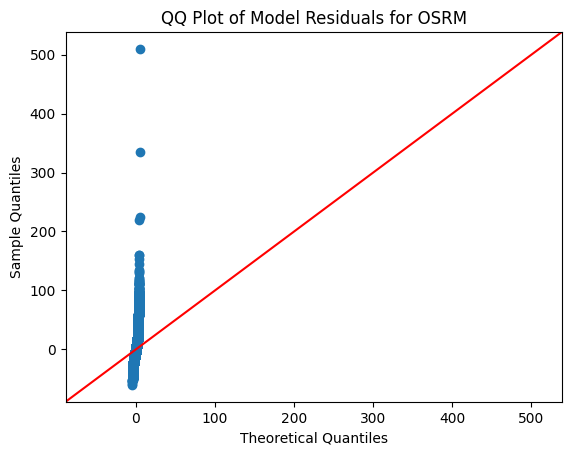

In [40]:
# Fit the linear regression model +destination_region_encoded + origin_region_encoded dist_to_central_point_origin+dist_to_central_point_dest
model_osrm = smf.ols(
    're_diff_tt ~ origin_region_Inner_London + destination_region_Inner_London + havsine_distance_OD + road_density_origin + road_density_dest',
    data=re_diff_osrm_encoded,
).fit()

# Print the model summary
print(model_osrm.summary())

# QQ plot of the residuals
sm.qqplot(model_osrm.resid, line ='45')
plt.title('QQ Plot of Model Residuals for OSRM')
plt.show()

                            OLS Regression Results                            
Dep. Variable:             re_diff_tt   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                 1.778e+04
Date:                Fri, 16 Aug 2024   Prob (F-statistic):               0.00
Time:                        11:20:49   Log-Likelihood:            -3.5307e+06
No. Observations:             1003002   AIC:                         7.061e+06
Df Residuals:                 1002996   BIC:                         7.062e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

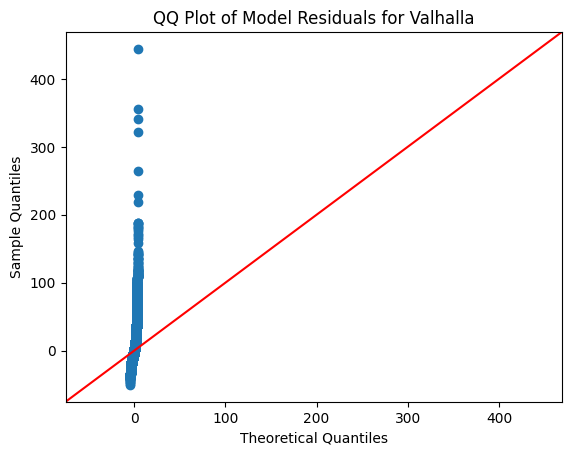

In [41]:
# Fit the linear regression model +destination_region_encoded + origin_region_encoded dist_to_central_point_origin+dist_to_central_point_dest
model_val = smf.ols(
    're_diff_tt ~ origin_region_Inner_London + destination_region_Inner_London + havsine_distance_OD + road_density_origin + road_density_dest',
    data=re_diff_val_encoded,
).fit()

# Print the model summary
print(model_val.summary())

# QQ plot of the residuals
sm.qqplot(model_val.resid, line ='45')
plt.title('QQ Plot of Model Residuals for Valhalla')
plt.show()

xgboost

/home/mengyuwsl/.local/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:8.42564	validation_1-rmse:8.39144
[1]	validation_0-rmse:8.32539	validation_1-rmse:8.28996
[2]	validation_0-rmse:8.24529	validation_1-rmse:8.20858
[3]	validation_0-rmse:8.16895	validation_1-rmse:8.13240
[4]	validation_0-rmse:8.10500	validation_1-rmse:8.06820
[5]	validation_0-rmse:8.04872	validation_1-rmse:8.01170
[6]	validation_0-rmse:7.99719	validation_1-rmse:7.96000
[7]	validation_0-rmse:7.94660	validation_1-rmse:7.90931
[8]	validation_0-rmse:7.90711	validation_1-rmse:7.86929
[9]	validation_0-rmse:7.87031	validation_1-rmse:7.83205
[10]	validation_0-rmse:7.83527	validation_1-rmse:7.79674
[11]	validation_0-rmse:7.80533	validation_1-rmse:7.76799
[12]	validation_0-rmse:7.77797	validation_1-rmse:7.74074
[13]	validation_0-rmse:7.75259	validation_1-rmse:7.71631
[14]	validation_0-rmse:7.72337	validation_1-rmse:7.68746
[15]	validation_0-rmse:7.69785	validation_1-rmse:7.66208
[16]	validation_0-rmse:7.67841	validation_1-rmse:7.64348
[17]	validation_0-rmse:7.66184	validation

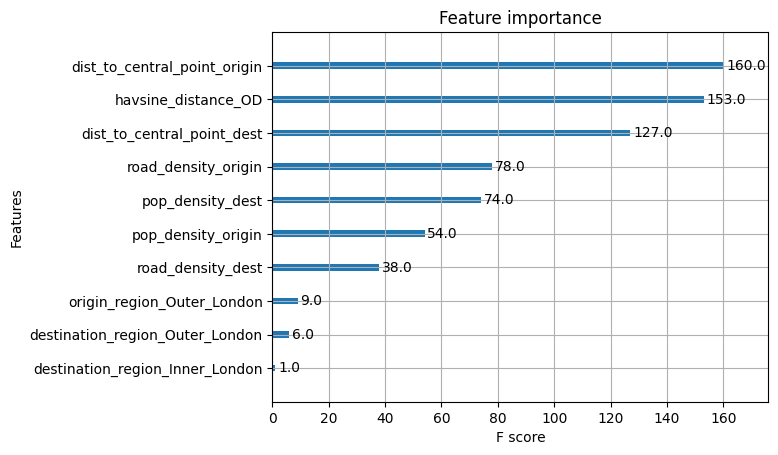

                           Feature     Importance
3     dist_to_central_point_origin  229223.375000
9                 pop_density_dest  133591.953125
4       dist_to_central_point_dest  128250.398438
5              havsine_distance_OD   87787.421875
6              road_density_origin   68086.875000
8               pop_density_origin   67386.656250
7                road_density_dest   60172.578125
0       origin_region_Outer_London   32798.921875
2  destination_region_Outer_London   15992.450195
1  destination_region_Inner_London   10193.124023


In [43]:
#destination_region_encoded + origin_region_encoded
X = re_diff_val_encoded[['origin_region_Central_London', 
                         'origin_region_Inner_London', 
                         'origin_region_Outer_London',
                         'destination_region_Central_London', 
                         'destination_region_Inner_London', 
                         'destination_region_Outer_London',
                         'dist_to_central_point_origin', 
                         'dist_to_central_point_dest', 
                         'havsine_distance_OD',
                         'road_density_origin', 
                         'road_density_dest', 
                         'pop_density_origin', 
                         'pop_density_dest']]
y = re_diff_val_encoded['re_diff_tt']

# 1. Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  


# 2. Create DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# 3. Set Hyperparameters (Tune these!)
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.1,
    'max_depth': 3,
}

# 4. Train the XGBRegressor (Note the change here)
model = xgb.XGBRegressor(**params)  # Use XGBRegressor for scikit-learn compatibility
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=10)

# 5. Model Summary (Optional - shows parameters and tree structure)
print("XGBoost Model Summary:")
print(model.get_booster().get_dump(with_stats=True))

# 6. Evaluation Metrics
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)  

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"Training RMSE: {train_rmse:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")
print(f"Training R-squared: {train_r2:.4f}")
print(f"Testing R-squared: {test_r2:.4f}")
print(f"Training MAE: {train_mae:.2f}")
print(f"Testing MAE: {test_mae:.2f}")

# 7. Feature Importance
# (You can use the model directly with plot_importance or the get_booster method.)
# Option 1:
plot_importance(model)  # or plot_importance(model.get_booster()) 
plt.show()
# Option 2:
importance = model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({'Feature': importance.keys(), 'Importance': importance.values()})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)


[0]	validation_0-rmse:11.75768	validation_1-rmse:11.70763


/home/mengyuwsl/.local/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-rmse:11.58212	validation_1-rmse:11.53245
[2]	validation_0-rmse:11.43733	validation_1-rmse:11.38912
[3]	validation_0-rmse:11.27923	validation_1-rmse:11.23209
[4]	validation_0-rmse:11.16446	validation_1-rmse:11.11804
[5]	validation_0-rmse:11.04831	validation_1-rmse:11.00459
[6]	validation_0-rmse:10.95187	validation_1-rmse:10.90876
[7]	validation_0-rmse:10.86166	validation_1-rmse:10.81963
[8]	validation_0-rmse:10.78751	validation_1-rmse:10.74594
[9]	validation_0-rmse:10.71566	validation_1-rmse:10.67432
[10]	validation_0-rmse:10.63568	validation_1-rmse:10.59764
[11]	validation_0-rmse:10.57921	validation_1-rmse:10.54249
[12]	validation_0-rmse:10.52524	validation_1-rmse:10.48906
[13]	validation_0-rmse:10.46944	validation_1-rmse:10.43308
[14]	validation_0-rmse:10.42896	validation_1-rmse:10.39423
[15]	validation_0-rmse:10.38654	validation_1-rmse:10.35214
[16]	validation_0-rmse:10.34573	validation_1-rmse:10.31133
[17]	validation_0-rmse:10.31116	validation_1-rmse:10.27769
[18]	v

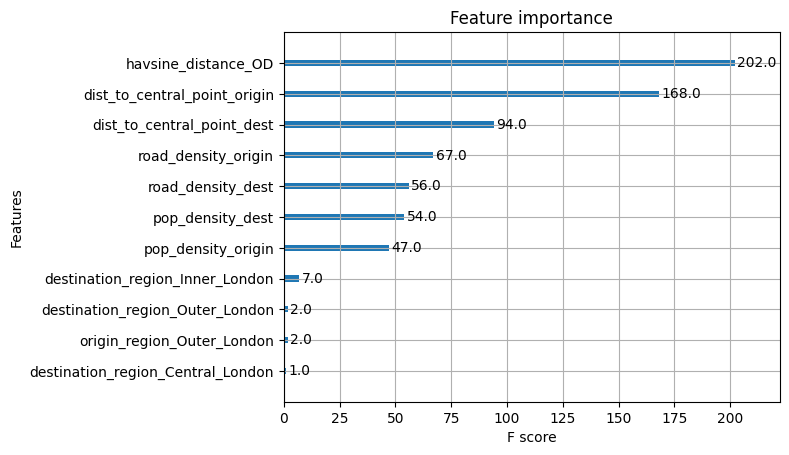

                              Feature     Importance
6                 havsine_distance_OD  406442.062500
4        dist_to_central_point_origin  372717.562500
7                 road_density_origin  341682.062500
10                   pop_density_dest  264045.062500
9                  pop_density_origin  206690.343750
8                   road_density_dest  192400.140625
5          dist_to_central_point_dest  191490.656250
0          origin_region_Outer_London   61354.242188
3     destination_region_Outer_London   54308.437500
2     destination_region_Inner_London   51378.242188
1   destination_region_Central_London   27776.548828


In [44]:
# 1. Prepare Data:

#origin_region_encoded + destination_region_encoded + dist_to_central_point_origin + dist_to_central_point_dest + havsine_distance_OD'
#X = re_diff_r5_encoded[['road_density_origin', 'dist_to_central_point_origin', 'dist_to_central_point_dest',
#                       'road_density_dest', 'havsine_distance_OD']]
X = re_diff_r5_encoded[['origin_region_Central_London', 'origin_region_Inner_London', 'origin_region_Outer_London',
                         'destination_region_Central_London', 'destination_region_Inner_London', 'destination_region_Outer_London',
                         'dist_to_central_point_origin', 'dist_to_central_point_dest', 'havsine_distance_OD',
                         'road_density_origin', 'road_density_dest', 'pop_density_origin', 'pop_density_dest']]
y = re_diff_r5_encoded['re_diff_tt']

# 1. Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  


# 2. Create DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# 3. Set Hyperparameters (Tune these!)
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.1,
    'max_depth': 3,
}

# 4. Train the XGBRegressor (Note the change here)
model = xgb.XGBRegressor(**params)  # Use XGBRegressor for scikit-learn compatibility
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=10)

# 5. Model Summary (Optional - shows parameters and tree structure)
print("XGBoost Model Summary:")
print(model.get_booster().get_dump(with_stats=True))

# 6. Evaluation Metrics
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)  

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"Training RMSE: {train_rmse:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")
print(f"Training R-squared: {train_r2:.4f}")
print(f"Testing R-squared: {test_r2:.4f}")
print(f"Training MAE: {train_mae:.2f}")
print(f"Testing MAE: {test_mae:.2f}")

# 7. Feature Importance
# (You can use the model directly with plot_importance or the get_booster method.)
# Option 1:
plot_importance(model)  # or plot_importance(model.get_booster()) 
plt.show()
# Option 2:
importance = model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({'Feature': importance.keys(), 'Importance': importance.values()})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)


In [47]:
re_diff_osrm_encoded.columns

Index(['destinationID', 'originID', 're_diff_tt', 'origin_lat', 'origin_lon',
       'destination_lat', 'destination_lon', 'euclidean_distance',
       'origin_region', 'destination_region', 'origin_region_Central_London',
       'origin_region_Inner_London', 'origin_region_Outer_London',
       'destination_region_Central_London', 'destination_region_Inner_London',
       'destination_region_Outer_London', 'dist_to_central_point_origin',
       'dist_to_central_point_dest', 'havsine_distance_OD',
       'road_density_origin', 'road_density_dest', 'pop_origin', 'pop_dest',
       'area_origin', 'area_dest', 'pop_density_origin', 'pop_density_dest'],
      dtype='object')

[0]	validation_0-rmse:8.34001	validation_1-rmse:8.31863
[1]	validation_0-rmse:8.23628	validation_1-rmse:8.21376


/home/mengyuwsl/.local/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-rmse:8.14954	validation_1-rmse:8.12495
[3]	validation_0-rmse:8.07669	validation_1-rmse:8.05208
[4]	validation_0-rmse:8.01427	validation_1-rmse:7.98845
[5]	validation_0-rmse:7.95989	validation_1-rmse:7.93386
[6]	validation_0-rmse:7.91353	validation_1-rmse:7.88659
[7]	validation_0-rmse:7.86960	validation_1-rmse:7.84335
[8]	validation_0-rmse:7.83374	validation_1-rmse:7.80785
[9]	validation_0-rmse:7.80178	validation_1-rmse:7.77556
[10]	validation_0-rmse:7.77363	validation_1-rmse:7.74706
[11]	validation_0-rmse:7.74807	validation_1-rmse:7.72176
[12]	validation_0-rmse:7.72658	validation_1-rmse:7.69985
[13]	validation_0-rmse:7.70644	validation_1-rmse:7.67991
[14]	validation_0-rmse:7.68684	validation_1-rmse:7.66073
[15]	validation_0-rmse:7.67093	validation_1-rmse:7.64495
[16]	validation_0-rmse:7.65127	validation_1-rmse:7.62506
[17]	validation_0-rmse:7.63681	validation_1-rmse:7.61031
[18]	validation_0-rmse:7.62370	validation_1-rmse:7.59727
[19]	validation_0-rmse:7.61170	validati

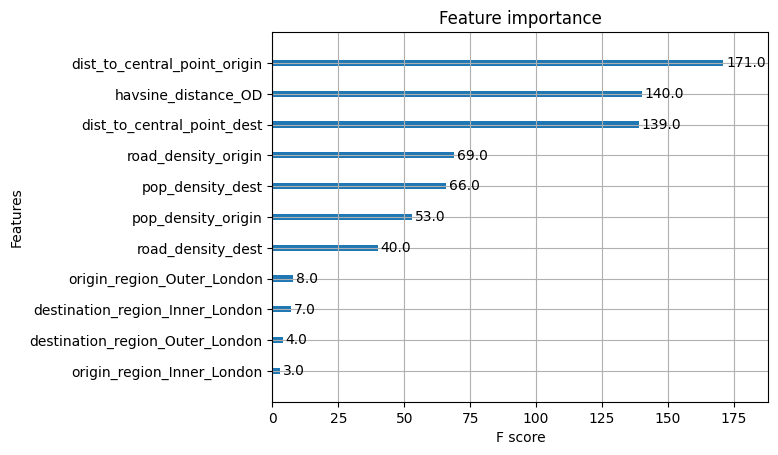

                            Feature     Importance
4      dist_to_central_point_origin  251970.500000
10                 pop_density_dest  123504.898438
5        dist_to_central_point_dest  107766.171875
1        origin_region_Outer_London   64271.335938
6               havsine_distance_OD   56294.617188
7               road_density_origin   45831.496094
9                pop_density_origin   44016.980469
8                 road_density_dest   24933.925781
0        origin_region_Inner_London   24091.296875
2   destination_region_Inner_London   20177.130859
3   destination_region_Outer_London   14179.441406


In [45]:
# 1. Prepare Data:

#origin_region_encoded + destination_region_encoded + dist_to_central_point_origin + dist_to_central_point_dest + havsine_distance_OD'
#X = re_diff_osrm_encoded[['road_density_origin', 'dist_to_central_point_origin', 'dist_to_central_point_dest',
#                       'road_density_dest', 'havsine_distance_OD']]
X = re_diff_osrm_encoded[['origin_region_Central_London', 'origin_region_Inner_London', 'origin_region_Outer_London',
                         'destination_region_Central_London', 'destination_region_Inner_London', 'destination_region_Outer_London',
                         'dist_to_central_point_origin', 'dist_to_central_point_dest', 'havsine_distance_OD',
                         'road_density_origin', 'road_density_dest', 'pop_density_origin', 'pop_density_dest']]
y = re_diff_osrm_encoded['re_diff_tt']

# 1. Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  


# 2. Create DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# 3. Set Hyperparameters (Tune these!)
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.1,
    'max_depth': 3,
}

# 4. Train the XGBRegressor (Note the change here)
model = xgb.XGBRegressor(**params)  # Use XGBRegressor for scikit-learn compatibility
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=10)

# 5. Model Summary (Optional - shows parameters and tree structure)
print("XGBoost Model Summary:")
print(model.get_booster().get_dump(with_stats=True))

# 6. Evaluation Metrics
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)  

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"Training RMSE: {train_rmse:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")
print(f"Training R-squared: {train_r2:.4f}")
print(f"Testing R-squared: {test_r2:.4f}")
print(f"Training MAE: {train_mae:.2f}")
print(f"Testing MAE: {test_mae:.2f}")

# 7. Feature Importance
# (You can use the model directly with plot_importance or the get_booster method.)
# Option 1:
plot_importance(model)  # or plot_importance(model.get_booster()) 
plt.show()
# Option 2:
importance = model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({'Feature': importance.keys(), 'Importance': importance.values()})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)


Bar-plot of importance

In [60]:
df_f_import = pd.read_excel('data_preprocessing/feat_impot.xlsx', sheet_name='Sheet1')

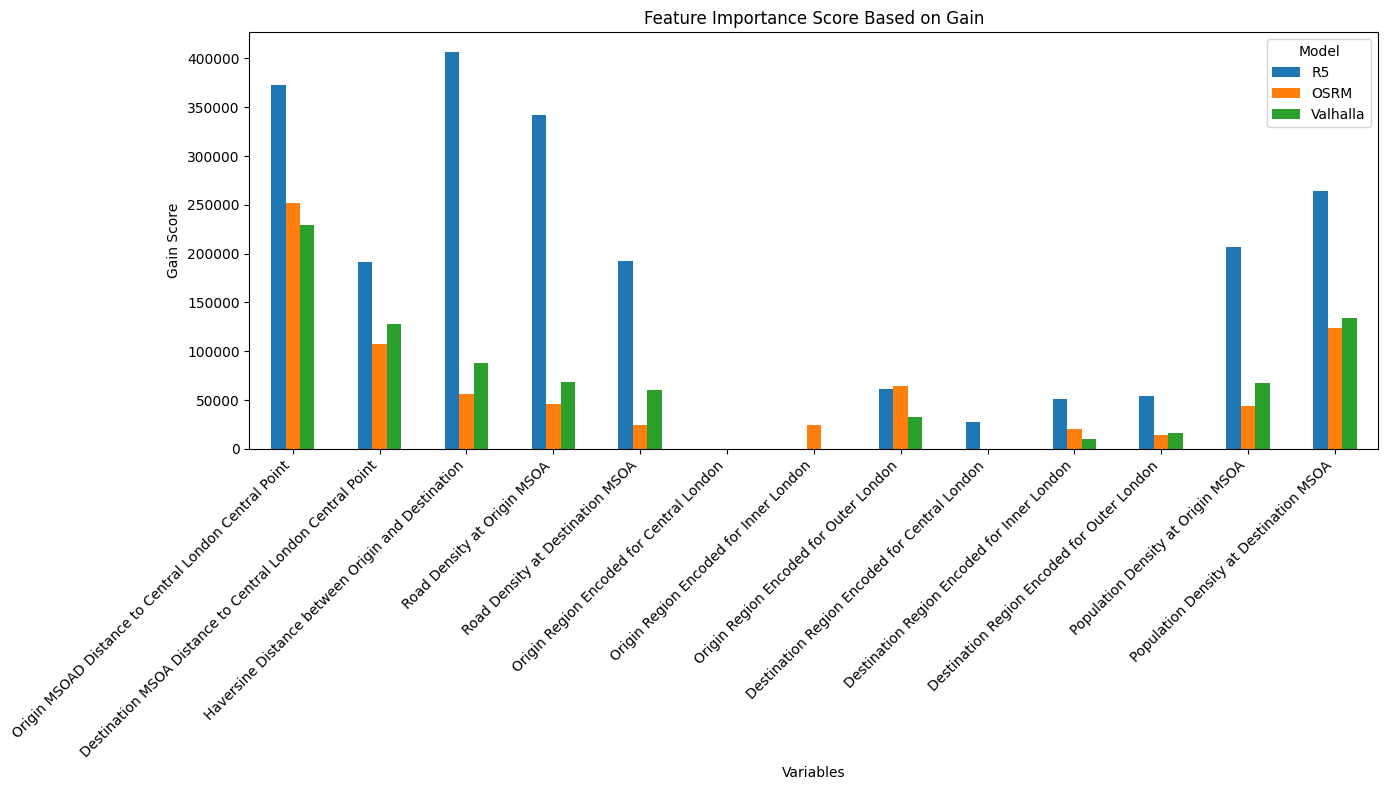

In [50]:
# Set the Variables column as the index
df_f_import.set_index('Variables', inplace=True)

# Plot the data
df_f_import.plot(kind='bar', figsize=(14, 8))

# Add titles and labels
plt.title('Feature Importance Score Based on Gain')
plt.xlabel('Variables')
plt.ylabel('Gain Score')
plt.legend(title='Model')

# Rotate the x labels for better readability
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()

In [61]:
# save the df_f_import to csv:
df_f_import.to_csv(r'/mnt/d/University College London/Chen, Huanfa - Dissertation_Mengyu_Ding/Data/regression_data/feature_importance_results_ver2.csv', index=False)

In [54]:
colors = ['#92c5de','#f4a582','#0571b0']

In [58]:
df_f_import.head()

R5      OSRM  \
Variables                                                                
Origin MSOAD Distance to Central London Central...  372717.6  251970.5   
Destination MSOA Distance to Central London Cen...  191490.7  107766.2   
Haversine Distance between Origin and Destination   406442.0   56294.6   
Road Density at Origin MSOA                         341682.1   45831.5   
Road Density at Destination MSOA                    192400.1   24933.9   

                                                    Valhalla  
Variables                                                     
Origin MSOAD Distance to Central London Central...  229223.4  
Destination MSOA Distance to Central London Cen...  128250.4  
Haversine Distance between Origin and Destination    87787.4  
Road Density at Origin MSOA                          68086.9  
Road Density at Destination MSOA                     60172.6

In [64]:
df_sorted = df_f_import.sort_values(by='R5', ascending=True).set_index('Variables')

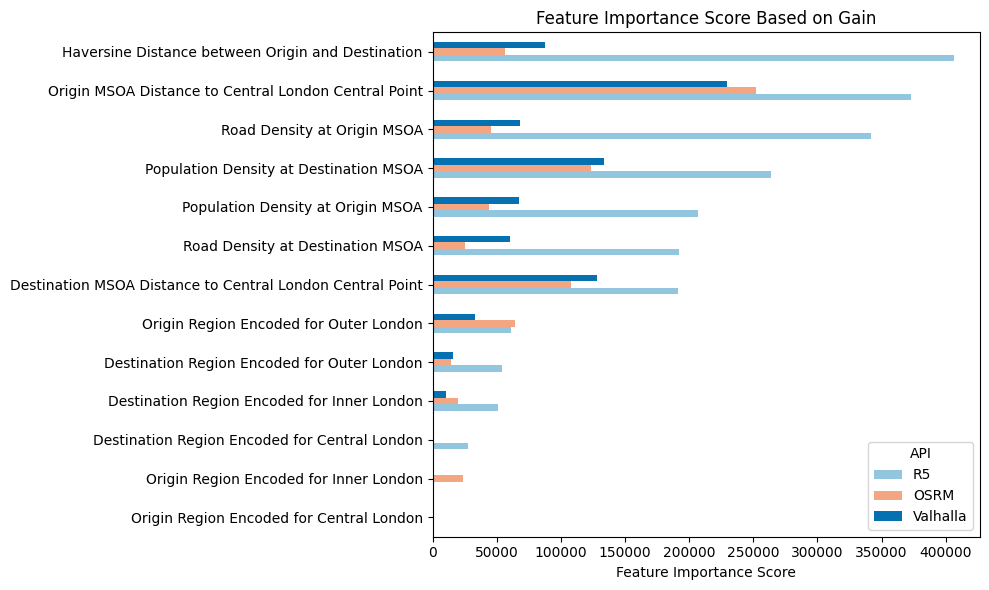

In [66]:
# Plot the sorted DataFrame
ax = df_sorted.plot(kind='barh', figsize=(10, 6),color=colors)

# Add titles and labels
plt.title('Feature Importance Score Based on Gain')
plt.xlabel('Feature Importance Score')
plt.legend(title='API')

# Suppress the y-label
ax.set_ylabel('')

# Display the plot
plt.tight_layout()
plt.show()

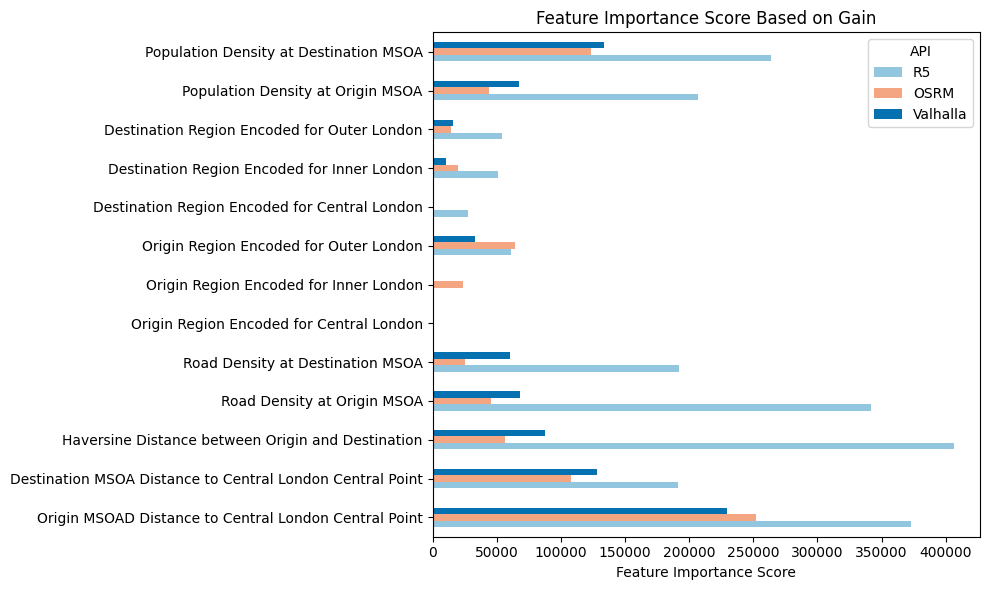

In [55]:
ax = df_f_import.plot(kind='barh', figsize=(10, 6), color=colors)
# Add titles and labels
plt.title('Feature Importance Score Based on Gain')
plt.xlabel('Feature Importance Score')
plt.legend(title='API')

# Suppress the y-label
ax.set_ylabel('')

# Display the plot
plt.tight_layout()
plt.show()

## 4. Perform Regression with Linear Regression and XGBoost
this is the simple regression, with no extra columns added:

### 3.1 Normalise the Distance variables

In [12]:
# Normalise the distance variables
cols_to_normalize = ['dist_to_central_point_origin', 'dist_to_central_point_dest', 'havsine_distance_OD']
scaler = StandardScaler()
re_diff_r5_encoded[cols_to_normalize] = scaler.fit_transform(re_diff_r5_encoded[cols_to_normalize])

re_diff_osrm_encoded[cols_to_normalize] = scaler.fit_transform(re_diff_osrm_encoded[cols_to_normalize])

re_diff_val_encoded[cols_to_normalize] = scaler.fit_transform(re_diff_val_encoded[cols_to_normalize])

### 3.2 Colinearity and VIF

In [13]:
# Correlation Matrix for r5:
distance_df_r5 = re_diff_r5_encoded[['dist_to_central_point_origin', 
                                     'dist_to_central_point_dest', 
                                     'havsine_distance_OD',]]


correlation_matrix_r5 = distance_df_r5.corr()
print(correlation_matrix_r5)

                              dist_to_central_point_origin  \
dist_to_central_point_origin                      1.000000   
dist_to_central_point_dest                       -0.000999   
havsine_distance_OD                               0.414447   

                              dist_to_central_point_dest  havsine_distance_OD  
dist_to_central_point_origin                   -0.000999             0.414447  
dist_to_central_point_dest                      1.000000             0.414447  
havsine_distance_OD                             0.414447             1.000000  


In [15]:
# Correlation Matrix for osrm:
distance_df_osrm = re_diff_osrm_encoded[['dist_to_central_point_origin', 'dist_to_central_point_dest', 'havsine_distance_OD']]

correlation_matrix_osrm = distance_df_osrm.corr()
print(correlation_matrix_osrm)

                              dist_to_central_point_origin  \
dist_to_central_point_origin                      1.000000   
dist_to_central_point_dest                       -0.000999   
havsine_distance_OD                               0.414447   

                              dist_to_central_point_dest  havsine_distance_OD  
dist_to_central_point_origin                   -0.000999             0.414447  
dist_to_central_point_dest                      1.000000             0.414447  
havsine_distance_OD                             0.414447             1.000000  


In [16]:
distance_df_val = re_diff_val_encoded[['dist_to_central_point_origin', 'dist_to_central_point_dest', 'havsine_distance_OD']]

correlation_matrix_val = distance_df_val.corr()
print(correlation_matrix_val)

                              dist_to_central_point_origin  \
dist_to_central_point_origin                      1.000000   
dist_to_central_point_dest                       -0.000999   
havsine_distance_OD                               0.414447   

                              dist_to_central_point_dest  havsine_distance_OD  
dist_to_central_point_origin                   -0.000999             0.414447  
dist_to_central_point_dest                      1.000000             0.414447  
havsine_distance_OD                             0.414447             1.000000  


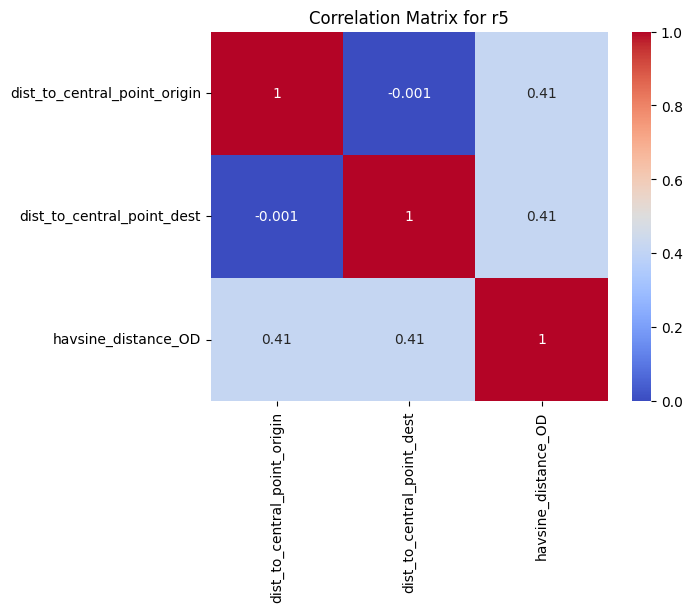

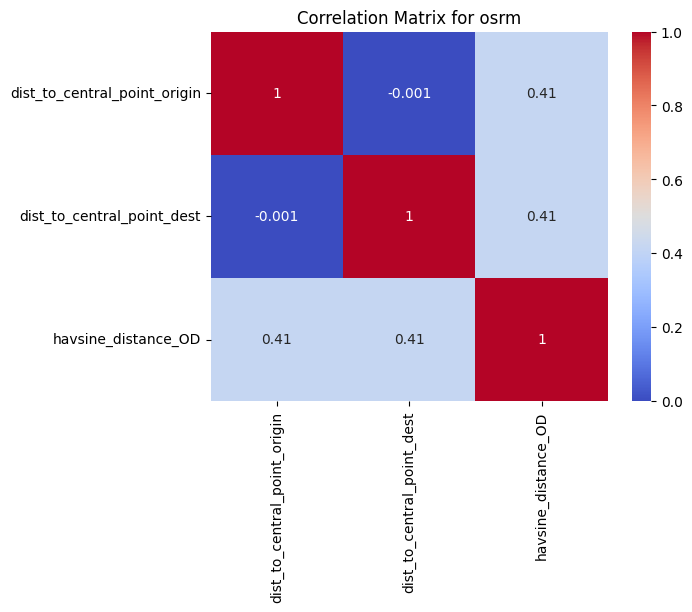

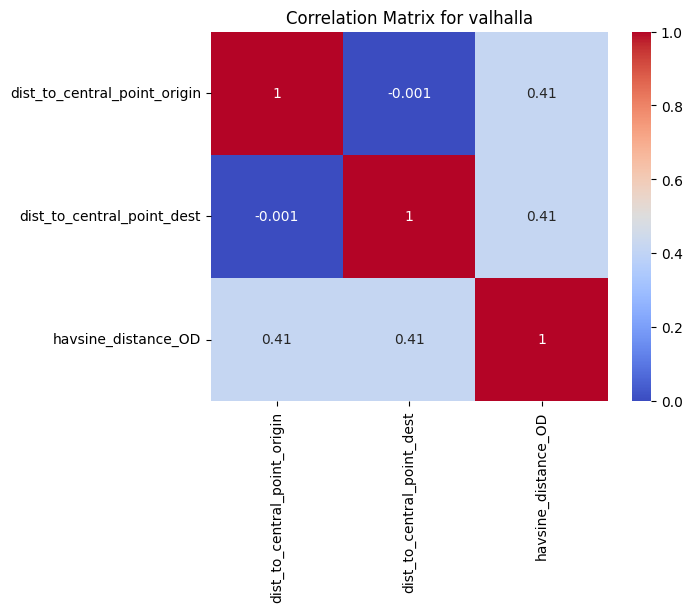

In [51]:
# plot correlation matrix for r5:
sns.heatmap(correlation_matrix_r5, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for r5')
plt.show()

# plot correlation matrix for osrm:
sns.heatmap(correlation_matrix_osrm, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for osrm')
plt.show()

# plot correlation matrix for osrm:
sns.heatmap(correlation_matrix_val, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for valhalla')
plt.show()

In [17]:
distance_df_const = sm.add_constant(distance_df_osrm)
vif = pd.DataFrame()
vif["Variable"] = distance_df_const.columns
vif["VIF"] = [variance_inflation_factor(distance_df_const.values, i) for i in range(distance_df_const.shape[1])]
print(vif)

                       Variable       VIF
0                         const  1.000000
1  dist_to_central_point_origin  1.262315
2    dist_to_central_point_dest  1.262315
3           havsine_distance_OD  1.524103


In [18]:
distance_df_const_r5 = sm.add_constant(distance_df_r5)
vif = pd.DataFrame()
vif["Variable"] = distance_df_const_r5.columns
vif["VIF"] = [variance_inflation_factor(distance_df_const.values, i) for i in range(distance_df_const.shape[1])]
print(vif)

                       Variable       VIF
0                         const  1.000000
1  dist_to_central_point_origin  1.262315
2    dist_to_central_point_dest  1.262315
3           havsine_distance_OD  1.524103


In [19]:
distance_df_const_val = sm.add_constant(distance_df_val)
vif = pd.DataFrame()
vif["Variable"] = distance_df_const_val.columns
vif["VIF"] = [variance_inflation_factor(distance_df_const.values, i) for i in range(distance_df_const.shape[1])]
print(vif)

                       Variable       VIF
0                         const  1.000000
1  dist_to_central_point_origin  1.262315
2    dist_to_central_point_dest  1.262315
3           havsine_distance_OD  1.524103


                                   origin_region_Central_London  \
origin_region_Central_London                           1.000000   
origin_region_Inner_London                            -0.025925   
origin_region_Outer_London                            -0.038454   
destination_region_Central_London                     -0.000999   
destination_region_Inner_London                        0.000026   
destination_region_Outer_London                        0.000038   
dist_to_central_point_origin                          -0.065798   
dist_to_central_point_dest                             0.000066   
havsine_distance_OD                                   -0.017590   

                                   origin_region_Inner_London  \
origin_region_Central_London                        -0.025925   
origin_region_Inner_London                           1.000000   
origin_region_Outer_London                          -0.997928   
destination_region_Central_London                    0.000026   
dest

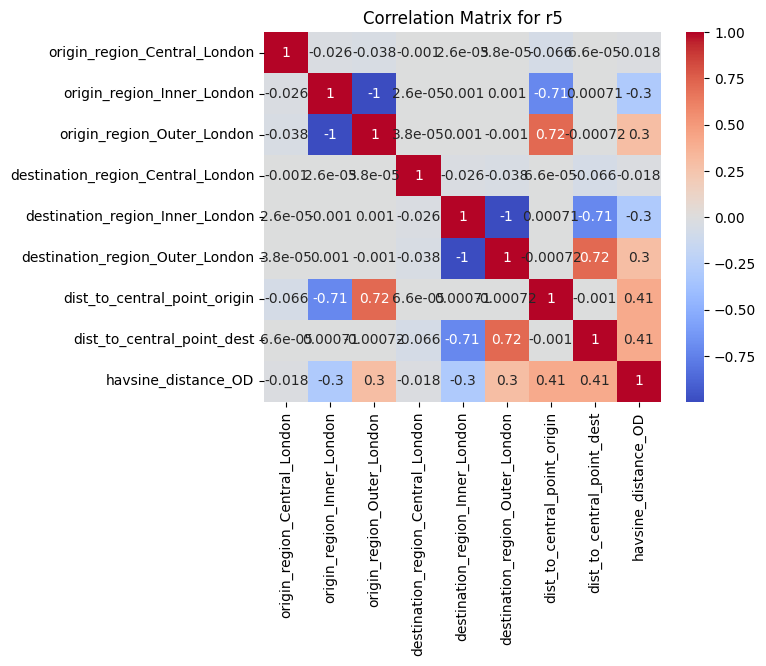

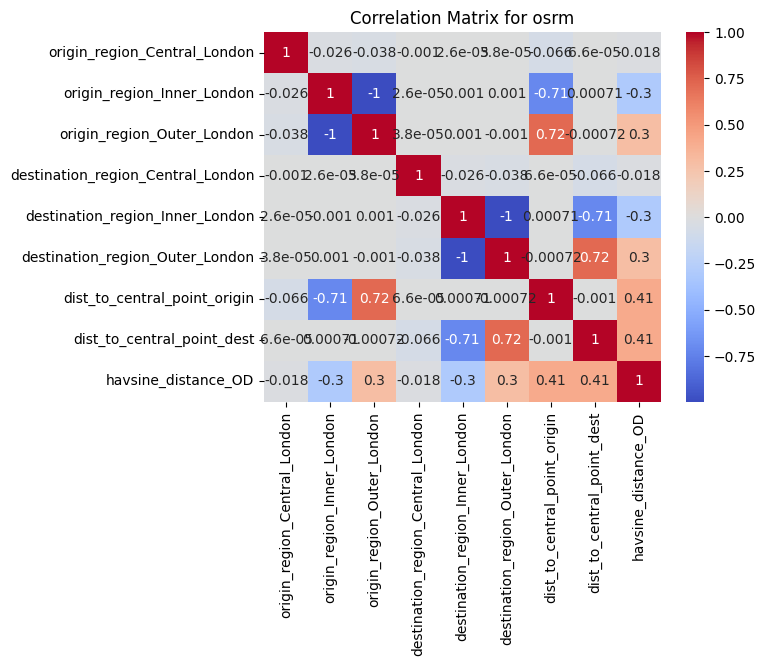

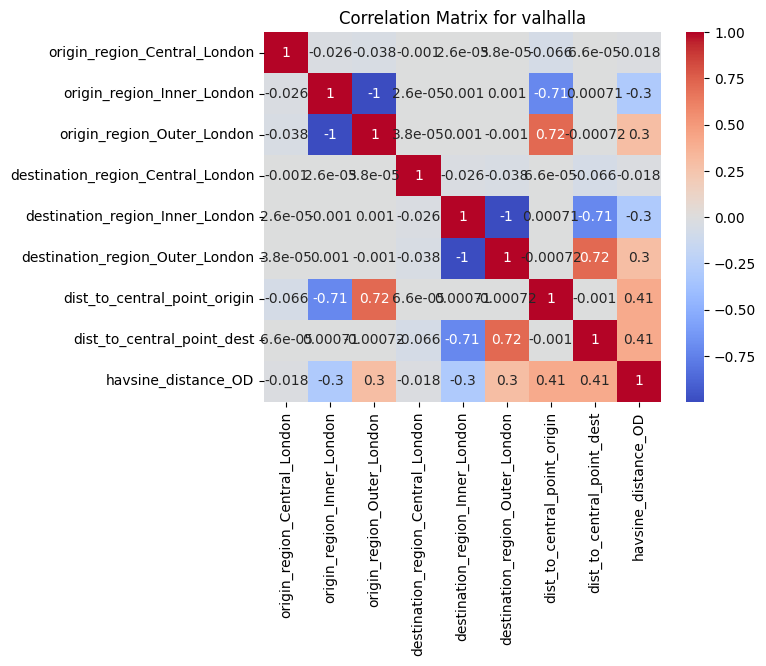

In [20]:
# get the correlation for these columns: origin_region_Central_London + 'origin_region_Inner_London' + origin_region_Outer_London + destination_region_Central_London + destination_region_Inner_London + destination_region_Outer_London + dist_to_central_point_origin + dist_to_central_point_dest + havsine_distance_OD
# for r5:
correlation_matrix_r5 = re_diff_r5_encoded[['origin_region_Central_London', 'origin_region_Inner_London', 'origin_region_Outer_London', 'destination_region_Central_London', 'destination_region_Inner_London', 'destination_region_Outer_London', 'dist_to_central_point_origin', 'dist_to_central_point_dest', 'havsine_distance_OD']].corr()
print(correlation_matrix_r5)

# for osrm:
correlation_matrix_osrm = re_diff_osrm_encoded[['origin_region_Central_London', 'origin_region_Inner_London', 'origin_region_Outer_London', 'destination_region_Central_London', 'destination_region_Inner_London', 'destination_region_Outer_London', 'dist_to_central_point_origin', 'dist_to_central_point_dest', 'havsine_distance_OD']].corr()
print(correlation_matrix_osrm)

# for valhalla:
correlation_matrix_val = re_diff_val_encoded[['origin_region_Central_London', 'origin_region_Inner_London', 'origin_region_Outer_London', 'destination_region_Central_London', 'destination_region_Inner_London', 'destination_region_Outer_London', 'dist_to_central_point_origin', 'dist_to_central_point_dest', 'havsine_distance_OD']].corr()
print(correlation_matrix_val)

# plot correlation matrix for r5:
sns.heatmap(correlation_matrix_r5, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for r5')

plt.show()

# plot correlation matrix for osrm:
sns.heatmap(correlation_matrix_osrm, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for osrm')

plt.show()

# plot correlation matrix for valhalla:
sns.heatmap(correlation_matrix_val, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for valhalla')

plt.show()



### 3.3 Fit the model Lin. Regression

In [55]:
# Fit the linear regression model
model_r5 = smf.ols(
    're_diff_tt ~ origin_region_Central_London + origin_region_Inner_London + origin_region_Outer_London + destination_region_Central_London + destination_region_Inner_London + destination_region_Outer_London + dist_to_central_point_origin + dist_to_central_point_dest + havsine_distance_OD',
    data=re_diff_r5_encoded,
).fit()

# Print the model summary
print(model_r5.summary())

                            OLS Regression Results                            
Dep. Variable:             re_diff_tt   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                 2.488e+04
Date:                Sun, 04 Aug 2024   Prob (F-statistic):               0.00
Time:                        17:48:14   Log-Likelihood:            -3.8114e+06
No. Observations:             1003002   AIC:                         7.623e+06
Df Residuals:                 1002992   BIC:                         7.623e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [56]:
# Fit the linear regression model
model_osrm = smf.ols(
    're_diff_tt ~ origin_region_Central_London + origin_region_Inner_London + origin_region_Outer_London + destination_region_Central_London + destination_region_Inner_London + destination_region_Outer_London + dist_to_central_point_origin + dist_to_central_point_dest + havsine_distance_OD',
    data=re_diff_osrm_encoded,
).fit()

# Print the model summary
print(model_osrm.summary())

                            OLS Regression Results                            
Dep. Variable:             re_diff_tt   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                 1.610e+04
Date:                Sun, 04 Aug 2024   Prob (F-statistic):               0.00
Time:                        17:48:17   Log-Likelihood:            -3.4974e+06
No. Observations:             1003002   AIC:                         6.995e+06
Df Residuals:                 1002992   BIC:                         6.995e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [57]:
# Fit the linear regression model
model_val = smf.ols(
    're_diff_tt ~ origin_region_Central_London + origin_region_Inner_London + origin_region_Outer_London + destination_region_Central_London + destination_region_Inner_London + destination_region_Outer_London + dist_to_central_point_origin + dist_to_central_point_dest + havsine_distance_OD',
    data=re_diff_val_encoded,
).fit()

# Print the model summary
print(model_val.summary())

                            OLS Regression Results                            
Dep. Variable:             re_diff_tt   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                 1.967e+04
Date:                Sun, 04 Aug 2024   Prob (F-statistic):               0.00
Time:                        17:48:38   Log-Likelihood:            -3.4918e+06
No. Observations:             1003002   AIC:                         6.984e+06
Df Residuals:                 1002992   BIC:                         6.984e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

### 3.4 Handling the Categorical Variables
Having 6 columns for OD category of central/inner/outer London may not seem to be a good way of handling the tri-category scenario, let's move to using one column, but this column is denoted such that:

Central London: 0<br>
Inner London: 1<br>
Outer London: 2<br>

In [14]:
re_diff_r5_encoded['origin_region_encoded'] = re_diff_r5_encoded['origin_region'].map({'Central London': 0, 'Inner London': 1, 'Outer London': 2})
re_diff_r5_encoded['destination_region_encoded'] = re_diff_r5_encoded['destination_region'].map({'Central London': 0, 'Inner London': 1, 'Outer London': 2})

re_diff_osrm_encoded['origin_region_encoded'] = re_diff_osrm_encoded['origin_region'].map({'Central London': 0, 'Inner London': 1, 'Outer London': 2})
re_diff_osrm_encoded['destination_region_encoded'] = re_diff_osrm_encoded['destination_region'].map({'Central London': 0, 'Inner London': 1, 'Outer London': 2})

re_diff_val_encoded['origin_region_encoded'] = re_diff_val_encoded['origin_region'].map({'Central London': 0, 'Inner London': 1, 'Outer London': 2})
re_diff_val_encoded['destination_region_encoded'] = re_diff_val_encoded['destination_region'].map({'Central London': 0, 'Inner London': 1, 'Outer London': 2})

In [15]:
distance_df_osrm = re_diff_osrm_encoded[['dist_to_central_point_origin', 'dist_to_central_point_dest', 'havsine_distance_OD','origin_region_encoded', 'destination_region_encoded']]

correlation_matrix_osrm = distance_df_osrm.corr()
print(correlation_matrix_osrm)

distance_df_const = sm.add_constant(distance_df_osrm)
vif = pd.DataFrame()
vif["Variable"] = distance_df_const.columns
vif["VIF"] = [variance_inflation_factor(distance_df_const.values, i) for i in range(distance_df_const.shape[1])]
print(vif)

                              dist_to_central_point_origin  \
dist_to_central_point_origin                      1.000000   
dist_to_central_point_dest                       -0.000999   
havsine_distance_OD                               0.414447   
origin_region_encoded                             0.717965   
destination_region_encoded                       -0.000717   

                              dist_to_central_point_dest  havsine_distance_OD  \
dist_to_central_point_origin                   -0.000999             0.414447   
dist_to_central_point_dest                      1.000000             0.414447   
havsine_distance_OD                             0.414447             1.000000   
origin_region_encoded                          -0.000717             0.296476   
destination_region_encoded                      0.717965             0.296476   

                              origin_region_encoded  \
dist_to_central_point_origin               0.717965   
dist_to_central_point_dest    

                              origin_region_encoded  \
origin_region_encoded                      1.000000   
destination_region_encoded                -0.000999   
dist_to_central_point_origin               0.717965   
dist_to_central_point_dest                -0.000717   
havsine_distance_OD                        0.296476   

                              destination_region_encoded  \
origin_region_encoded                          -0.000999   
destination_region_encoded                      1.000000   
dist_to_central_point_origin                   -0.000717   
dist_to_central_point_dest                      0.717965   
havsine_distance_OD                             0.296476   

                              dist_to_central_point_origin  \
origin_region_encoded                             0.717965   
destination_region_encoded                       -0.000717   
dist_to_central_point_origin                      1.000000   
dist_to_central_point_dest                       -0.000999  

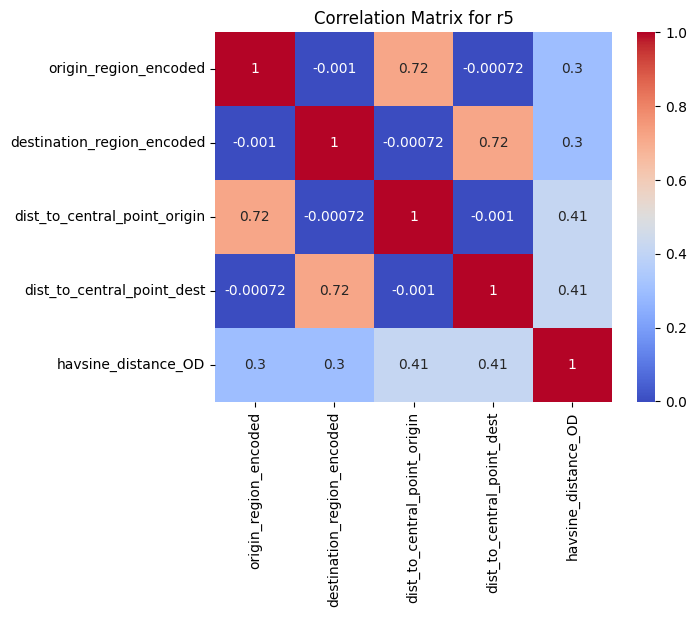

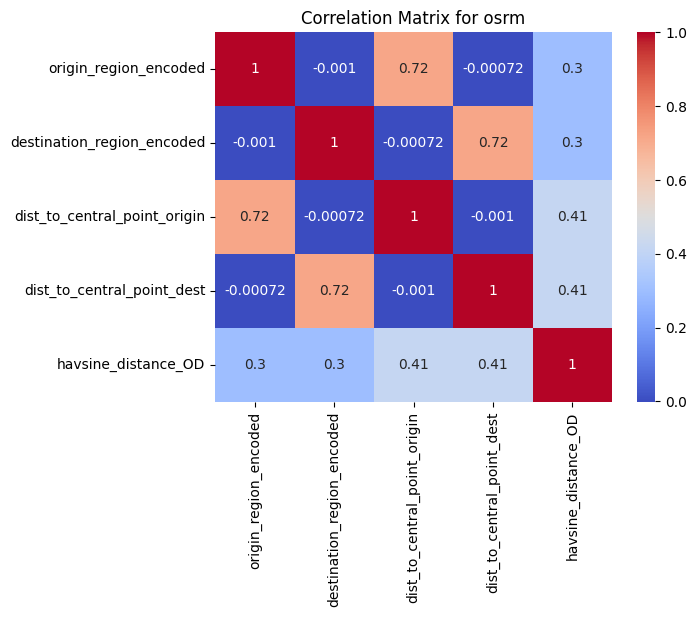

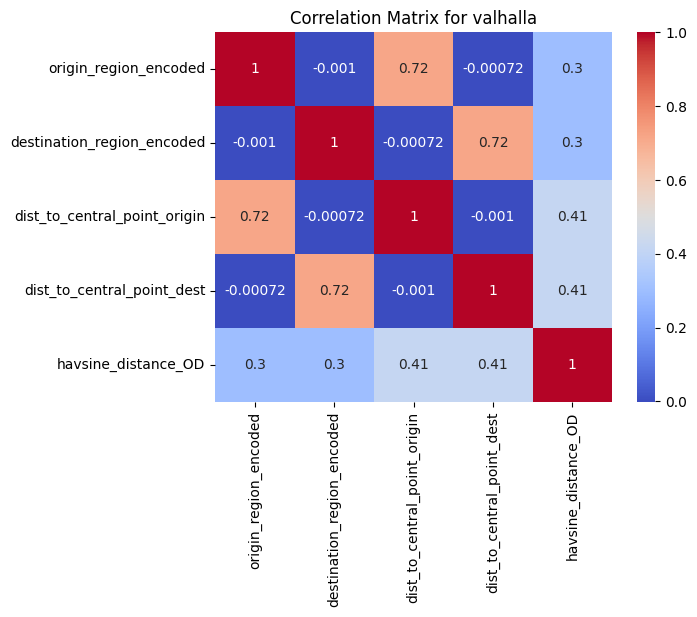

In [22]:
correlation_matrix_r5 = re_diff_r5_encoded[['origin_region_encoded', 'destination_region_encoded', 'dist_to_central_point_origin',  'dist_to_central_point_dest', 'havsine_distance_OD']].corr()
print(correlation_matrix_r5)

# for osrm:
correlation_matrix_osrm = re_diff_osrm_encoded[['origin_region_encoded', 'destination_region_encoded', 'dist_to_central_point_origin',  'dist_to_central_point_dest', 'havsine_distance_OD']].corr()
print(correlation_matrix_osrm)

# for valhalla:
correlation_matrix_val = re_diff_val_encoded[['origin_region_encoded', 'destination_region_encoded', 'dist_to_central_point_origin',  'dist_to_central_point_dest', 'havsine_distance_OD']].corr()
print(correlation_matrix_val)

# plot correlation matrix for r5:
sns.heatmap(correlation_matrix_r5, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for r5')

plt.show()

# plot correlation matrix for osrm:
sns.heatmap(correlation_matrix_osrm, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for osrm')

plt.show()

# plot correlation matrix for valhalla:
sns.heatmap(correlation_matrix_val, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for valhalla')

plt.show()


In [33]:
# Fit the linear regression model
model_r5 = smf.ols(
    're_diff_tt ~ dist_to_central_point_origin + dist_to_central_point_dest + havsine_distance_OD',
    data=re_diff_r5_encoded,
).fit()

# Print the model summary
print(model_r5.summary())

                            OLS Regression Results                            
Dep. Variable:             re_diff_tt   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                 7.232e+04
Date:                Tue, 06 Aug 2024   Prob (F-statistic):               0.00
Time:                        14:59:43   Log-Likelihood:            -3.8142e+06
No. Observations:             1003002   AIC:                         7.628e+06
Df Residuals:                 1002998   BIC:                         7.629e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

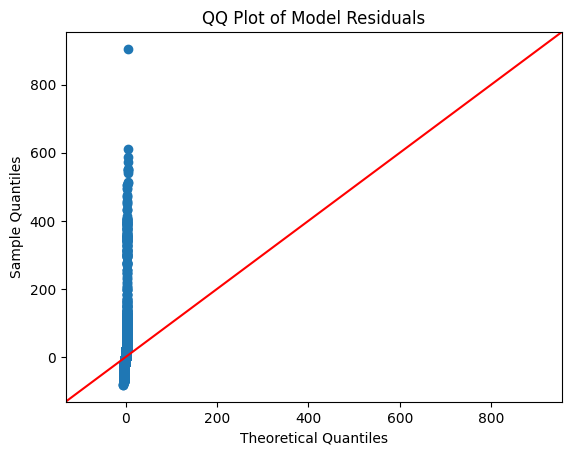

In [34]:
sm.qqplot(model_r5.resid, line='45')
plt.title('QQ Plot of Model Residuals')
plt.show()

In [ ]:
'origin_region_encoded + destination_region_encoded'

In [16]:
# Fit the linear regression model
model_r5 = smf.ols(
    're_diff_tt ~ origin_region_encoded + destination_region_encoded + dist_to_central_point_origin + dist_to_central_point_dest + havsine_distance_OD',
    data=re_diff_r5_encoded,
).fit()

# Print the model summary
print(model_r5.summary())

                            OLS Regression Results                            
Dep. Variable:             re_diff_tt   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                 4.477e+04
Date:                Mon, 12 Aug 2024   Prob (F-statistic):               0.00
Time:                        19:53:12   Log-Likelihood:            -3.8114e+06
No. Observations:             1003002   AIC:                         7.623e+06
Df Residuals:                 1002996   BIC:                         7.623e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [30]:
# Fit the linear regression model
model_osrm = smf.ols(
    're_diff_tt ~ dist_to_central_point_origin + dist_to_central_point_dest + havsine_distance_OD',
    data=re_diff_osrm_encoded,
).fit()

# Print the model summary
print(model_osrm.summary())

                            OLS Regression Results                            
Dep. Variable:             re_diff_tt   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                 4.598e+04
Date:                Tue, 06 Aug 2024   Prob (F-statistic):               0.00
Time:                        14:58:50   Log-Likelihood:            -3.5004e+06
No. Observations:             1003002   AIC:                         7.001e+06
Df Residuals:                 1002998   BIC:                         7.001e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

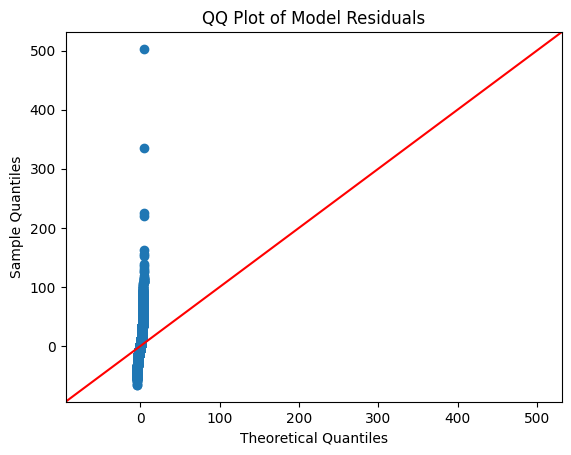

In [32]:
sm.qqplot(model_osrm.resid, line='45')
plt.title('QQ Plot of Model Residuals')
plt.show()

In [60]:
# Fit the linear regression model
model_osrm = smf.ols(
    're_diff_tt ~ origin_region_encoded + destination_region_encoded + dist_to_central_point_origin + dist_to_central_point_dest + havsine_distance_OD',
    data=re_diff_osrm_encoded,
).fit()

# Print the model summary
print(model_osrm.summary())

                            OLS Regression Results                            
Dep. Variable:             re_diff_tt   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                 2.894e+04
Date:                Sun, 04 Aug 2024   Prob (F-statistic):               0.00
Time:                        17:50:58   Log-Likelihood:            -3.4975e+06
No. Observations:             1003002   AIC:                         6.995e+06
Df Residuals:                 1002996   BIC:                         6.995e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [39]:
# Fit the linear regression model
model_val = smf.ols(
    're_diff_tt ~ dist_to_central_point_origin + dist_to_central_point_dest + havsine_distance_OD',
    data=re_diff_val_encoded,
).fit()

# Print the model summary
print(model_val.summary())

                            OLS Regression Results                            
Dep. Variable:             re_diff_tt   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                 5.685e+04
Date:                Tue, 06 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:04:38   Log-Likelihood:            -3.4946e+06
No. Observations:             1003002   AIC:                         6.989e+06
Df Residuals:                 1002998   BIC:                         6.989e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [35]:
re_diff_val_encoded.head()

destinationID   originID  re_diff_tt  origin_lat  origin_lon  \
0     E02000001  E02000002  -33.366489   51.588242    0.139471   
1     E02000001  E02000003  -34.249709   51.574923    0.140919   
2     E02000001  E02000004  -26.861899   51.555446    0.176841   
3     E02000001  E02000005  -26.890437   51.561414    0.143309   
4     E02000001  E02000007  -28.545180   51.558095    0.157363   

   destination_lat  destination_lon  euclidean_distance origin_region  \
0        51.514382        -0.092411            0.243361  Outer London   
1        51.514382        -0.092411            0.241056  Outer London   
2        51.514382        -0.092411            0.272366  Outer London   
3        51.514382        -0.092411            0.240367  Outer London   
4        51.514382        -0.092411            0.253570  Outer London   

  destination_region  ...  origin_region_Inner_London  \
0       Inner London  ...                           0   
1       Inner London  ...                           0   
2       Inner London  ...                           0   
3       Inner London  ...                           0   
4       Inner London  ...                           0   

   origin_region_Outer_London  destination_region_Central_London  \
0                           1                                  0   
1                           1                                  0   
2                           1                                  0   
3                           1                                  0   
4                           1                                  0   

   destination_region_Inner_London  destination_region_Outer_London  \
0                                1                                0   
1                                1                                0   
2                                1                                0   
3                                1                                0   
4                                1                                0   

   dist_to_central_point_origin  dist_to_central_point_dest  \
0                      1.416613                   -1.711729   
1                      1.328895                   -1.711729   
2                      1.625611                   -1.711729   
3                      1.268257                   -1.711729   
4                      1.412054                   -1.711729   

   havsine_distance_OD  origin_region_encoded  destination_region_encoded  
0             0.094603                      2                           1  
1             0.033193                      2                           1  
2             0.228977                      2                           1  
3            -0.008704                      2                           1  
4             0.086791                      2                           1  

[5 rows x 21 columns]

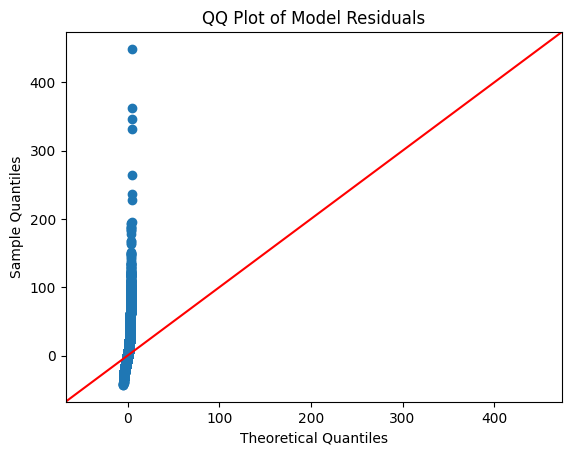

In [38]:
# QQ plot of the residuals
sm.qqplot(model_val.resid, line ='45')
plt.title('QQ Plot of Model Residuals')
plt.show()

In [17]:
# Fit the linear regression model
model_val = smf.ols(
    're_diff_tt ~ origin_region_encoded + destination_region_encoded + dist_to_central_point_origin + dist_to_central_point_dest + havsine_distance_OD',
    data=re_diff_val_encoded,
).fit()

# Print the model summary
print(model_val.summary())

                            OLS Regression Results                            
Dep. Variable:             re_diff_tt   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                 3.538e+04
Date:                Mon, 12 Aug 2024   Prob (F-statistic):               0.00
Time:                        19:53:20   Log-Likelihood:            -3.4918e+06
No. Observations:             1003002   AIC:                         6.984e+06
Df Residuals:                 1002996   BIC:                         6.984e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

## 3.4 addition: adding road lendth density for each msoa:

##### 1. read in the msoa boundary, calculate each msoa area:

In [18]:
# read shp file and plot its borders on folium map:
msoa_shape = gpd.read_file(r'/mnt/d/University College London/Chen, Huanfa - Dissertation_Mengyu_Ding/Data/msoa/england_msoa_2021.shp')

In [19]:
# calculate each msoa's area, in km^2:
msoa_shape['area'] = msoa_shape.area

In [ ]:
msoa_shape.head()

In [20]:
msoa_shape['area_sqkm'] = msoa_shape['area'] / 1e6

In [21]:
bbox = msoa_shape.total_bounds


##### 2. read in the osm network:

In [22]:
osm_file = r'/mnt/d/Downloads/greater-london-latest.osm.pbf'

# import the osm file and extract the road network length for car only, by each msoa:
import osmium
from pyrosm import OSM, get_data

In [23]:
# Load the PBF file using pyrosm
osm_gl = OSM(osm_file)

# Extract the road network for vehicles (highways suitable for cars and vehicles)
# Filtering for roads that are suitable for cars
roads = osm_gl.get_network(network_type='driving')

In [24]:
edges = gpd.GeoDataFrame(roads, crs="EPSG:4326")
edges = edges.to_crs(msoa_shape.crs)

In [25]:
# Ensure the CRS matches between the roads and MSOA boundaries
edges = edges.to_crs(msoa_shape.crs)

In [26]:
# Spatial join to intersect roads with MSOA boundaries
edges_msoa = gpd.sjoin(edges, msoa_shape, how="inner", op="intersects")

# Calculate the length of each road segment within each MSOA
edges_msoa['length'] = edges_msoa.geometry.length

/home/mengyuwsl/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [27]:
# Group by MSOA ID and sum the road lengths
road_length_per_msoa = edges_msoa.groupby('msoa21cd')['length'].sum().reset_index()

# Merge the road length data back with the MSOA boundaries
msoa_shape = msoa_shape.merge(road_length_per_msoa, on='msoa21cd')

# Calculate road network density
msoa_shape['road_density_km_per_sqkm'] = msoa_shape['length'] / msoa_shape['area_sqkm']


In [28]:
msoa_shape['road_density_km_per_sqkm'] = msoa_shape['road_density_km_per_sqkm'] / 1000

In [29]:
msoa_shape.head()

hclnm hclnmw                                 label  \
0  Plumstead High Street   None  E92000001E12000007E09000011E02000318   
1        Fulham Broadway   None  E92000001E12000007E09000013E02000388   
2         Streatham Vale   None  E92000001E12000007E09000022E02000652   
3   Queen's Park Gardens   None  E92000001E12000007E09000033E02000963   
4       Streatham Common   None  E92000001E12000007E09000022E02000651   

    msoa21cd                    msoa21nm                        name  \
0  E02000318               Greenwich 006               Greenwich 006   
1  E02000388  Hammersmith and Fulham 017  Hammersmith and Fulham 017   
2  E02000652                 Lambeth 035                 Lambeth 035   
3  E02000963             Westminster 004             Westminster 004   
4  E02000651                 Lambeth 034                 Lambeth 034   

                                            geometry          area  area_sqkm  \
0  POLYGON ((546024.231 178810.367, 546024.002 17...  1.104995e+06   1.104995   
1  POLYGON ((525600.834 177749.054, 525605.642 17...  5.316645e+05   0.531664   
2  POLYGON ((529736.206 170431.382, 529736.499 17...  6.873634e+05   0.687363   
3  POLYGON ((524291.499 182989.539, 524295.596 18...  4.870540e+05   0.487054   
4  POLYGON ((531297.728 171022.395, 531284.488 17...  1.119759e+06   1.119759   

         length  road_density_km_per_sqkm  
0  25034.114115                 22.655408  
1  14529.561930                 27.328442  
2  13141.815222                 19.119166  
3  15690.330953                 32.214765  
4  22415.780347                 20.018390

bounding box:

In [60]:
re_diff_val_encodedadd_road_densit
#re_diff_r5_encoded
#re_diff_osrm_encoded

destinationID   originID  re_diff_tt  origin_lat  origin_lon  \
0     E02000001  E02000002  -33.366489   51.588242    0.139471   
1     E02000001  E02000003  -34.249709   51.574923    0.140919   
2     E02000001  E02000004  -26.861899   51.555446    0.176841   
3     E02000001  E02000005  -26.890437   51.561414    0.143309   
4     E02000001  E02000007  -28.545180   51.558095    0.157363   

   destination_lat  destination_lon  euclidean_distance origin_region  \
0        51.514382        -0.092411            0.243361  Outer London   
1        51.514382        -0.092411            0.241056  Outer London   
2        51.514382        -0.092411            0.272366  Outer London   
3        51.514382        -0.092411            0.240367  Outer London   
4        51.514382        -0.092411            0.253570  Outer London   

  destination_region  ...  origin_region_Inner_London  \
0       Inner London  ...                           0   
1       Inner London  ...                           0   
2       Inner London  ...                           0   
3       Inner London  ...                           0   
4       Inner London  ...                           0   

   origin_region_Outer_London  destination_region_Central_London  \
0                           1                                  0   
1                           1                                  0   
2                           1                                  0   
3                           1                                  0   
4                           1                                  0   

   destination_region_Inner_London  destination_region_Outer_London  \
0                                1                                0   
1                                1                                0   
2                                1                                0   
3                                1                                0   
4                                1                                0   

   dist_to_central_point_origin  dist_to_central_point_dest  \
0                      1.416613                   -1.711729   
1                      1.328895                   -1.711729   
2                      1.625611                   -1.711729   
3                      1.268257                   -1.711729   
4                      1.412054                   -1.711729   

   havsine_distance_OD  origin_region_encoded  destination_region_encoded  
0             0.094603                      2                           1  
1             0.033193                      2                           1  
2             0.228977                      2                           1  
3            -0.008704                      2                           1  
4             0.086791                      2                           1  

[5 rows x 21 columns]

In [30]:
# now add the road_density_km_per_sqkm to the re_diff_val_encoded, re_diff_r5_encoded, re_diff_osrm_encoded:
def add_road_density(input_df, msoa_shape):
    # Create dictionaries for quick lookup
    msoa_density_dict = msoa_shape.set_index('msoa21cd')['road_density_km_per_sqkm'].to_dict()
    
    # Function to determine region based on MSOA ID
    def get_density(msoa_id):
        return msoa_density_dict.get(msoa_id, 0)
    
    # Add new columns to the dataframe
    input_df['road_density_origin'] = input_df['originID'].apply(get_density)
    input_df['road_density_dest'] = input_df['destinationID'].apply(get_density)
    
    return input_df

In [31]:
re_diff_val_encoded = add_road_density(re_diff_val_encoded, msoa_shape)

In [32]:
# Fit the linear regression model
model_val = smf.ols(
    're_diff_tt ~ road_density_origin + road_density_dest + dist_to_central_point_origin + dist_to_central_point_dest + havsine_distance_OD',
    data=re_diff_val_encoded,
).fit()

# Print the model summary
print(model_val.summary())

                            OLS Regression Results                            
Dep. Variable:             re_diff_tt   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                 3.665e+04
Date:                Mon, 12 Aug 2024   Prob (F-statistic):               0.00
Time:                        19:55:19   Log-Likelihood:            -3.4891e+06
No. Observations:             1003002   AIC:                         6.978e+06
Df Residuals:                 1002996   BIC:                         6.978e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

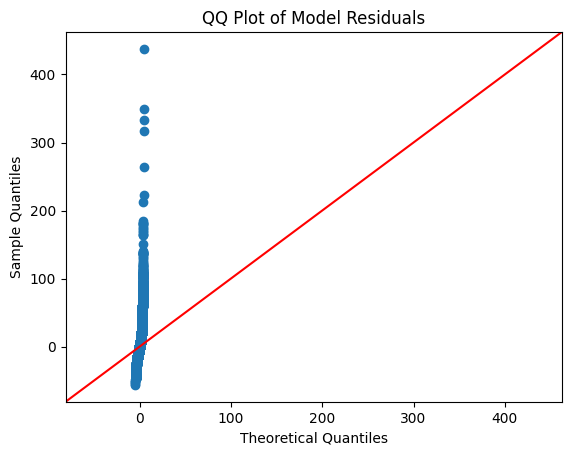

In [33]:
# QQ plot of the residuals
sm.qqplot(model_val.resid, line ='45')
plt.title('QQ Plot of Model Residuals')
plt.show()

In [34]:
re_diff_r5_encoded = add_road_density(re_diff_r5_encoded, msoa_shape)
re_diff_osrm_encoded = add_road_density(re_diff_osrm_encoded, msoa_shape)


                              road_density_origin  road_density_dest  \
road_density_origin                      1.000000          -0.000999   
road_density_dest                       -0.000999           1.000000   
origin_region_encoded                   -0.468657           0.000468   
destination_region_encoded               0.000468          -0.468657   
dist_to_central_point_origin            -0.583529           0.000583   
dist_to_central_point_dest               0.000583          -0.583529   
havsine_distance_OD                     -0.244078          -0.244078   

                              origin_region_encoded  \
road_density_origin                       -0.468657   
road_density_dest                          0.000468   
origin_region_encoded                      1.000000   
destination_region_encoded                -0.000999   
dist_to_central_point_origin               0.717965   
dist_to_central_point_dest                -0.000717   
havsine_distance_OD                   

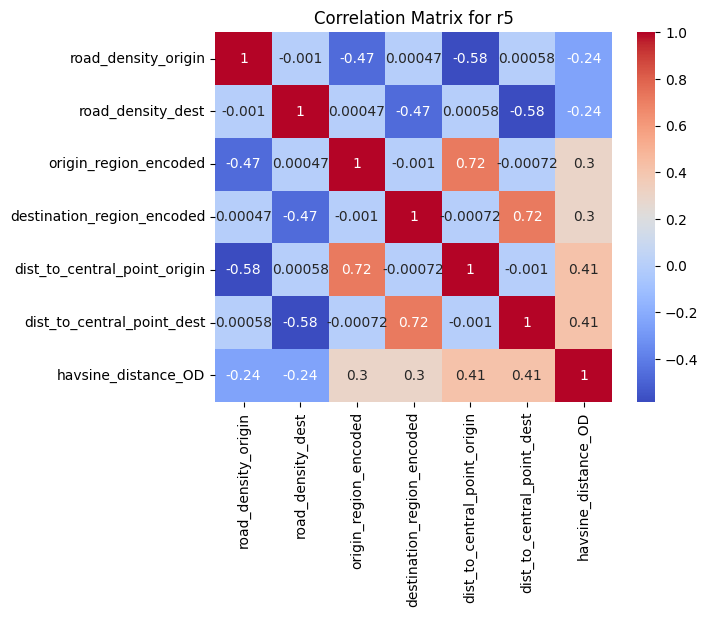

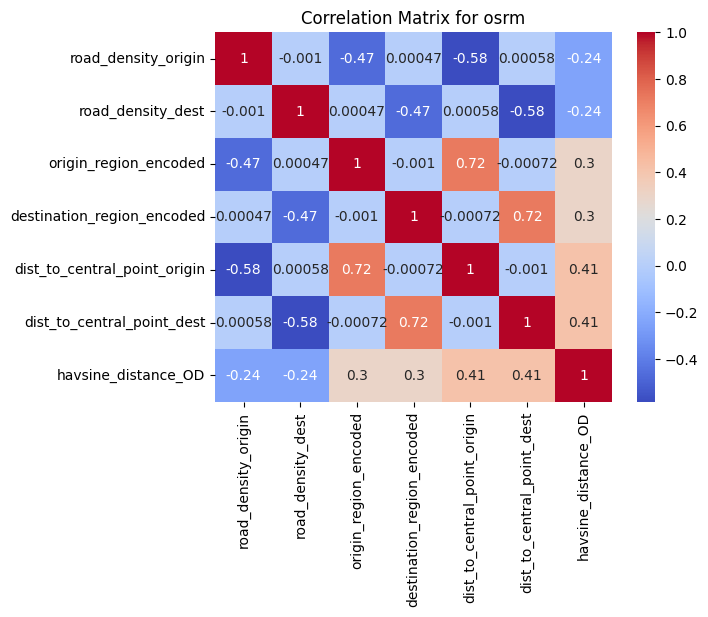

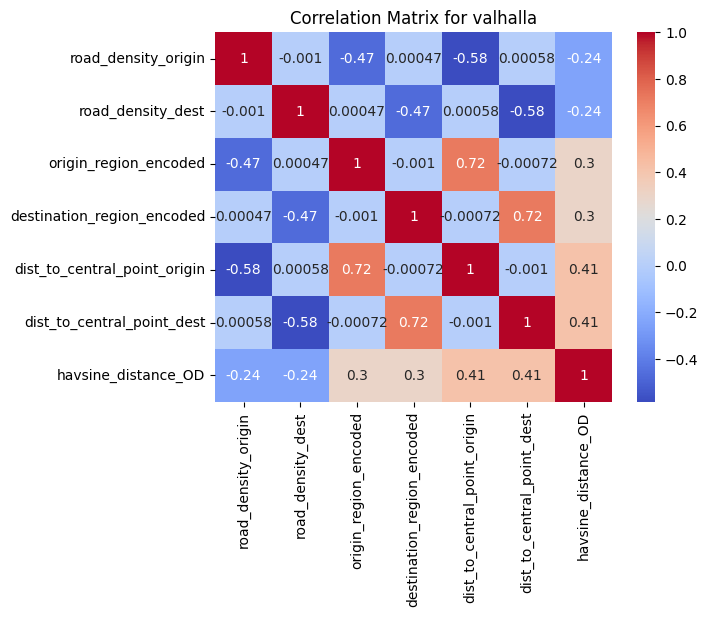

In [69]:
correlation_matrix_r5 = re_diff_r5_encoded[['road_density_origin', 'road_density_dest','origin_region_encoded', 'destination_region_encoded', 'dist_to_central_point_origin',  'dist_to_central_point_dest', 'havsine_distance_OD']].corr()
print(correlation_matrix_r5)

# for osrm:
correlation_matrix_osrm = re_diff_osrm_encoded[['road_density_origin', 'road_density_dest','origin_region_encoded', 'destination_region_encoded', 'dist_to_central_point_origin',  'dist_to_central_point_dest', 'havsine_distance_OD']].corr()
print(correlation_matrix_osrm)

# for valhalla:
correlation_matrix_val = re_diff_val_encoded[['road_density_origin', 'road_density_dest','origin_region_encoded', 'destination_region_encoded', 'dist_to_central_point_origin',  'dist_to_central_point_dest', 'havsine_distance_OD']].corr()
print(correlation_matrix_val)

# plot correlation matrix for r5:
sns.heatmap(correlation_matrix_r5, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for r5')

plt.show()

# plot correlation matrix for osrm:
sns.heatmap(correlation_matrix_osrm, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for osrm')

plt.show()

# plot correlation matrix for valhalla:
sns.heatmap(correlation_matrix_val, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for valhalla')

plt.show()

In [96]:
r5_regression = re_diff_r5_encoded[['road_density_origin', 'road_density_dest','origin_region_encoded', 'destination_region_encoded', 'dist_to_central_point_origin',  'dist_to_central_point_dest', 'havsine_distance_OD']]

osrm_regression = re_diff_osrm_encoded[['road_density_origin', 'road_density_dest','origin_region_encoded', 'destination_region_encoded', 'dist_to_central_point_origin',  'dist_to_central_point_dest', 'havsine_distance_OD']]

val_regression = re_diff_val_encoded[['road_density_origin', 'road_density_dest','origin_region_encoded', 'destination_region_encoded', 'dist_to_central_point_origin',  'dist_to_central_point_dest', 'havsine_distance_OD']]

##### 3. VIF

In [35]:
from statsmodels.tools.tools import add_constant

##### Add Populartion Density

In [37]:
re_diff_r5_encoded.head()

destinationID   originID  re_diff_tt  origin_lat  origin_lon  \
0     E02000001  E02000002  -15.267176   51.588242    0.139471   
1     E02000001  E02000003  -23.106796   51.574923    0.140919   
2     E02000001  E02000004  -14.425428   51.555446    0.176841   
3     E02000001  E02000005  -18.777293   51.561414    0.143309   
4     E02000001  E02000007  -19.117647   51.558095    0.157363   

   destination_lat  destination_lon  euclidean_distance origin_region  \
0        51.514382        -0.092411            0.243361  Outer London   
1        51.514382        -0.092411            0.241056  Outer London   
2        51.514382        -0.092411            0.272366  Outer London   
3        51.514382        -0.092411            0.240367  Outer London   
4        51.514382        -0.092411            0.253570  Outer London   

  destination_region  ...  destination_region_Central_London  \
0       Inner London  ...                                  0   
1       Inner London  ...                                  0   
2       Inner London  ...                                  0   
3       Inner London  ...                                  0   
4       Inner London  ...                                  0   

   destination_region_Inner_London  destination_region_Outer_London  \
0                                1                                0   
1                                1                                0   
2                                1                                0   
3                                1                                0   
4                                1                                0   

   dist_to_central_point_origin  dist_to_central_point_dest  \
0                      1.416613                   -1.711729   
1                      1.328895                   -1.711729   
2                      1.625611                   -1.711729   
3                      1.268257                   -1.711729   
4                      1.412054                   -1.711729   

   havsine_distance_OD  origin_region_encoded  destination_region_encoded  \
0             0.094603                      2                           1   
1             0.033193                      2                           1   
2             0.228977                      2                           1   
3            -0.008704                      2                           1   
4             0.086791                      2                           1   

   road_density_origin  road_density_dest  
0            12.875887          23.995758  
1            18.732372          23.995758  
2            10.065263          23.995758  
3            22.584730          23.995758  
4            18.454956          23.995758  

[5 rows x 23 columns]

In [38]:
#read excel file name: sapemsoasyoatablefinal(1),shee name: Mid-2021_MSOA_2021:
pop_density = pd.read_excel(r'/mnt/d/Downloads/sapemsoasyoatablefinal(1).xlsx', sheet_name='Mid-2021_MSOA_2021')

In [40]:
pop_density.rename(columns={'MSOA 2021 Code': 'msoa21cd'}, inplace=True)

In [41]:
pop_density.head()

LAD 2021 Code LAD 2021 Name   msoa21cd  MSOA 2021 Name  Total  F0  F1  F2  \
0     E06000001    Hartlepool  E02002483  Hartlepool 001  10285  47  68  56   
1     E06000001    Hartlepool  E02002484  Hartlepool 002  10261  60  79  78   
2     E06000001    Hartlepool  E02002485  Hartlepool 003   7970  43  56  51   
3     E06000001    Hartlepool  E02002489  Hartlepool 007   7170  40  25  25   
4     E06000001    Hartlepool  E02002490  Hartlepool 008   5767  30  31  40   

   F3  F4  ...  M81  M82  M83  M84  M85  M86  M87  M88  M89  M90  
0  44  73  ...   23   20   11   21   22   18   11   17    0   24  
1  63  59  ...   23   15   13   16   16   12   17    5    5   26  
2  40  59  ...   14   10    5   10   15    6    6    0    7   13  
3  25  40  ...   10   19   11   10    6    5    6    0    0    9  
4  39  35  ...    5   15    5   16    0   12    0    5    7    0  

[5 rows x 187 columns]

In [51]:
# merge to the re_diff_r5_encoded, re_diff_osrm_encoded, re_diff_val_encoded:
def add_pop(input_df, pop_density):
    # Create dictionaries for quick lookup
    msoa_density_dict = pop_density.set_index('msoa21cd')['Total'].to_dict()
    
    # Function to determine region based on MSOA ID
    def get_density(msoa_id):
        return msoa_density_dict.get(msoa_id, 0)
    
    # Add new columns to the dataframe
    input_df['pop_origin'] = input_df['originID'].apply(get_density)
    input_df['pop_dest'] = input_df['destinationID'].apply(get_density)
    
    return input_df

re_diff_r5_encoded = add_pop(re_diff_r5_encoded, pop_density)
re_diff_osrm_encoded = add_pop(re_diff_osrm_encoded, pop_density)
re_diff_val_encoded = add_pop(re_diff_val_encoded, pop_density)

In [46]:
re_diff_r5_encoded.columns

Index(['destinationID', 'originID', 're_diff_tt', 'origin_lat', 'origin_lon',
       'destination_lat', 'destination_lon', 'euclidean_distance',
       'origin_region', 'destination_region', 'origin_region_Central_London',
       'origin_region_Inner_London', 'origin_region_Outer_London',
       'destination_region_Central_London', 'destination_region_Inner_London',
       'destination_region_Outer_London', 'dist_to_central_point_origin',
       'dist_to_central_point_dest', 'havsine_distance_OD',
       'origin_region_encoded', 'destination_region_encoded',
       'road_density_origin', 'road_density_dest', 'pop_density_origin',
       'pop_density_dest'],
      dtype='object')

In [50]:
# add area 	area_sqkm to the re_diff_r5_encoded, re_diff_osrm_encoded, re_diff_val_encoded from msoa_shape:
def add_area(input_df, msoa_shape):
    # Create dictionaries for quick lookup
    msoa_density_dict = msoa_shape.set_index('msoa21cd')['area_sqkm'].to_dict()
    
    # Function to determine region based on MSOA ID
    def get_density(msoa_id):
        return msoa_density_dict.get(msoa_id, 0)
    
    # Add new columns to the dataframe
    input_df['area_origin'] = input_df['originID'].apply(get_density)
    input_df['area_dest'] = input_df['destinationID'].apply(get_density)
    
    return input_df

re_diff_r5_encoded = add_area(re_diff_r5_encoded, msoa_shape)
re_diff_osrm_encoded = add_area(re_diff_osrm_encoded, msoa_shape)
re_diff_val_encoded = add_area(re_diff_val_encoded, msoa_shape)

In [53]:
re_diff_val_encoded['pop_density_origin'] = re_diff_val_encoded['pop_origin'] / re_diff_val_encoded['area_origin']
re_diff_val_encoded['pop_density_dest'] = re_diff_val_encoded['pop_dest'] / re_diff_val_encoded['area_dest']

re_diff_r5_encoded['pop_density_origin'] = re_diff_r5_encoded['pop_origin'] / re_diff_r5_encoded['area_origin']
re_diff_r5_encoded['pop_density_dest'] = re_diff_r5_encoded['pop_dest'] / re_diff_r5_encoded['area_dest']

re_diff_osrm_encoded['pop_density_origin'] = re_diff_osrm_encoded['pop_origin'] / re_diff_osrm_encoded['area_origin']
re_diff_osrm_encoded['pop_density_dest'] = re_diff_osrm_encoded['pop_dest'] / re_diff_osrm_encoded['area_dest']

In [54]:
# save the re_diff_r5_encoded, re_diff_osrm_encoded, re_diff_val_encoded to csv:
re_diff_r5_encoded.to_csv(r'/mnt/d/University College London/Chen, Huanfa - Dissertation_Mengyu_Ding/Data/regression_data/re_diff_r5_encoded_reg.csv', index=False)
re_diff_osrm_encoded.to_csv(r'/mnt/d/University College London/Chen, Huanfa - Dissertation_Mengyu_Ding/Data/regression_data/re_diff_osrm_encoded_reg.csv', index=False)
re_diff_val_encoded.to_csv(r'/mnt/d/University College London/Chen, Huanfa - Dissertation_Mengyu_Ding/Data/regression_datare_diff_val_encoded_reg.csv', index=False)


##### 5. Now, Perform VIF

In [57]:
r5_regression = re_diff_r5_encoded[['pop_density_origin','pop_density_dest', 'road_density_origin', 'road_density_dest','origin_region_encoded', 'destination_region_encoded', 'dist_to_central_point_origin',  'dist_to_central_point_dest', 'havsine_distance_OD']]

osrm_regression = re_diff_osrm_encoded[['pop_density_origin','pop_density_dest', 'road_density_origin', 'road_density_dest','origin_region_encoded', 'destination_region_encoded', 'dist_to_central_point_origin',  'dist_to_central_point_dest', 'havsine_distance_OD']]

val_regression = re_diff_val_encoded[['pop_density_origin','pop_density_dest', 'road_density_origin', 'road_density_dest','origin_region_encoded', 'destination_region_encoded', 'dist_to_central_point_origin',  'dist_to_central_point_dest', 'havsine_distance_OD']]

In [58]:
def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [59]:
r5_regression = drop_column_using_vif_(r5_regression, thresh=2.5)

osrm_regression = drop_column_using_vif_(osrm_regression, thresh=2.5)

val_regression = drop_column_using_vif_(val_regression, thresh=2.5)

Dropping: pop_density_dest
Dropping: pop_density_origin
Dropping: dist_to_central_point_dest
Dropping: dist_to_central_point_origin
Dropping: pop_density_dest
Dropping: pop_density_origin
Dropping: dist_to_central_point_dest
Dropping: dist_to_central_point_origin
Dropping: pop_density_dest
Dropping: pop_density_origin
Dropping: dist_to_central_point_dest
Dropping: dist_to_central_point_origin


In [60]:
val_regression.head()

road_density_origin  road_density_dest  origin_region_encoded  \
0            12.875887          23.995758                      2   
1            18.732372          23.995758                      2   
2            10.065263          23.995758                      2   
3            22.584730          23.995758                      2   
4            18.454956          23.995758                      2   

   destination_region_encoded  havsine_distance_OD  
0                           1             0.094603  
1                           1             0.033193  
2                           1             0.228977  
3                           1            -0.008704  
4                           1             0.086791

In [62]:
# normalise the data,	road_density_origin,	road_density_dest:
scaler = StandardScaler()

re_diff_r5_encoded[['road_density_origin', 'road_density_dest']] = scaler.fit_transform(re_diff_r5_encoded[['road_density_origin', 'road_density_dest']])

re_diff_osrm_encoded[['road_density_origin', 'road_density_dest']] = scaler.fit_transform(re_diff_osrm_encoded[['road_density_origin', 'road_density_dest']])

re_diff_val_encoded[['road_density_origin', 'road_density_dest']] = scaler.fit_transform(re_diff_val_encoded[['road_density_origin', 'road_density_dest']])


                            OLS Regression Results                            
Dep. Variable:             re_diff_tt   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                 1.797e+04
Date:                Mon, 12 Aug 2024   Prob (F-statistic):               0.00
Time:                        20:11:02   Log-Likelihood:            -3.5303e+06
No. Observations:             1003002   AIC:                         7.061e+06
Df Residuals:                 1002996   BIC:                         7.061e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

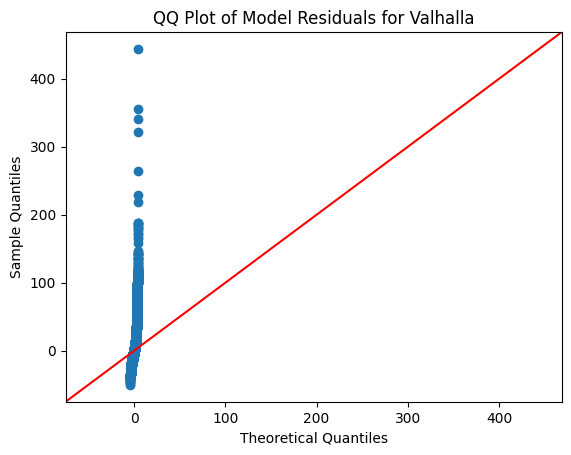

In [63]:
# Fit the linear regression model +destination_region_encoded + origin_region_encoded dist_to_central_point_origin+dist_to_central_point_dest
model_val = smf.ols(
    're_diff_tt ~ road_density_origin + road_density_dest + destination_region_encoded + origin_region_encoded + havsine_distance_OD',
    data=re_diff_val_encoded,
).fit()

# Print the model summary
print(model_val.summary())

# QQ plot of the residuals
sm.qqplot(model_val.resid, line ='45')
plt.title('QQ Plot of Model Residuals for Valhalla')
plt.show()

                            OLS Regression Results                            
Dep. Variable:             re_diff_tt   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                 1.553e+04
Date:                Wed, 07 Aug 2024   Prob (F-statistic):               0.00
Time:                        17:32:21   Log-Likelihood:            -3.5277e+06
No. Observations:             1003002   AIC:                         7.055e+06
Df Residuals:                 1002996   BIC:                         7.055e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

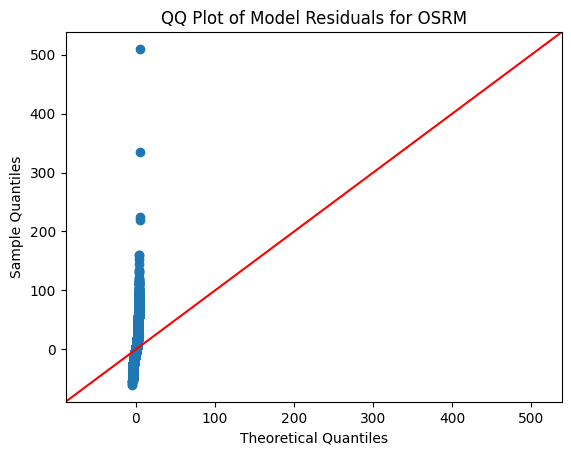

In [41]:
# Fit the linear regression model +destination_region_encoded + origin_region_encoded dist_to_central_point_origin+dist_to_central_point_dest
model_osrm = smf.ols(
    're_diff_tt ~ road_density_origin + road_density_dest + destination_region_encoded + origin_region_encoded + havsine_distance_OD',
    data=re_diff_osrm_encoded,
).fit()

# Print the model summary
print(model_osrm.summary())

# QQ plot of the residuals
sm.qqplot(model_osrm.resid, line ='45')
plt.title('QQ Plot of Model Residuals for OSRM')
plt.show()

                            OLS Regression Results                            
Dep. Variable:             re_diff_tt   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                 2.975e+04
Date:                Wed, 07 Aug 2024   Prob (F-statistic):               0.00
Time:                        17:32:15   Log-Likelihood:            -3.8431e+06
No. Observations:             1003002   AIC:                         7.686e+06
Df Residuals:                 1002996   BIC:                         7.686e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

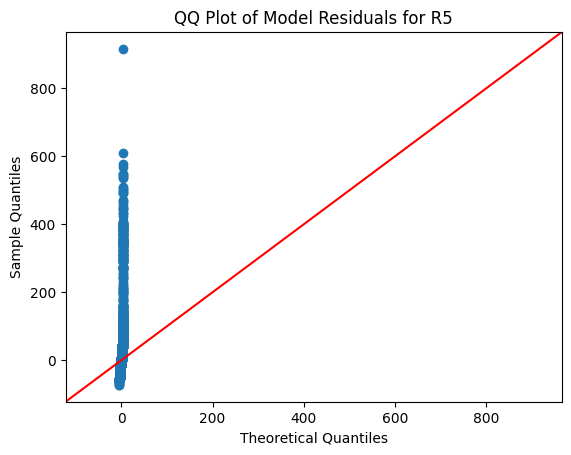

In [40]:
# Fit the linear regression model +destination_region_encoded + origin_region_encoded dist_to_central_point_origin+dist_to_central_point_dest
model_r5 = smf.ols(
    're_diff_tt ~ road_density_origin + road_density_dest + destination_region_encoded + origin_region_encoded + havsine_distance_OD',
    data=re_diff_r5_encoded,
).fit()

# Print the model summary
print(model_r5.summary())

# QQ plot of the residuals
sm.qqplot(model_r5.resid, line ='45')
plt.title('QQ Plot of Model Residuals for R5')
plt.show()

### 3.5 Spatial Clustering without income:

In [ ]:
re_diff_osrm_encoded

In [ ]:
# Create a base map centered around London
m = folium.Map(location=[df['origin_lat'].mean(), df['origin_lon'].mean()], zoom_start=10)
# Customize colormap
color_map = 'tab20'
# Create a colormap based on unique cluster labels
colors = plt.cm.get_cmap(color_map, np.unique(df['cluster_label']).size)
# Map the cluster labels to the colormap to get a color for each cluster
cluster_colors = [colors(label) for label in df['cluster_label']]

# Add markers for each point, colored by cluster
for index, row in df.iterrows():
    folium.CircleMarker(
        location=[row['origin_lat'], row['origin_lon']],
        radius=5,  # Adjust the size of the markers as needed
        color=folium.colors.to_hex(cluster_colors[index]),
        fill=True,
        fill_color=folium.colors.to_hex(cluster_colors[index]),
        fill_opacity=0.7,
        popup=f"Cluster: {row['cluster_label']}, Relative Difference: {row['re_diff_tt_scaled']}"
    ).add_to(m)

# Show the map
m.save("cluster_map_r5_re_diff.html")

In [ ]:
# Create a base map centered around London
m = folium.Map(location=[df['origin_lat'].mean(), df['origin_lon'].mean()], zoom_start=10)
# Customize colormap
color_map = 'tab20'
# Create a colormap based on unique cluster labels
colors = plt.cm.get_cmap(color_map, np.unique(df['cluster_label']).size)
# Map the cluster labels to the colormap to get a color for each cluster
cluster_colors = [colors(label) for label in df['cluster_label']]

# Add markers for each point, colored by cluster
for index, row in df.iterrows():
    folium.CircleMarker(
        location=[row['origin_lat'], row['origin_lon']],
        radius=5,  # Adjust the size of the markers as needed
        color=folium.colors.to_hex(cluster_colors[index]),
        fill=True,
        fill_color=folium.colors.to_hex(cluster_colors[index]),
        fill_opacity=0.7,
        popup=f"Cluster: {row['cluster_label']}, Relative Difference: {row['re_diff_tt_scaled']}"
    ).add_to(m)

# Show the map
m.save("cluster_map_osrm_re_diff.html")

### 3.6 XGBoost

In [95]:
re_diff_val_encoded.columns

Index(['destinationID', 'originID', 're_diff_tt', 'origin_lat', 'origin_lon',
       'destination_lat', 'destination_lon', 'euclidean_distance',
       'origin_region', 'destination_region', 'origin_region_Central_London',
       'origin_region_Inner_London', 'origin_region_Outer_London',
       'destination_region_Central_London', 'destination_region_Inner_London',
       'destination_region_Outer_London', 'dist_to_central_point_origin',
       'dist_to_central_point_dest', 'havsine_distance_OD',
       'origin_region_encoded', 'destination_region_encoded'],
      dtype='object')

[0]	validation_0-rmse:8.42564	validation_1-rmse:8.39144
[1]	validation_0-rmse:8.32539	validation_1-rmse:8.28996
[2]	validation_0-rmse:8.24529	validation_1-rmse:8.20858
[3]	validation_0-rmse:8.16895	validation_1-rmse:8.13240
[4]	validation_0-rmse:8.10500	validation_1-rmse:8.06820


/home/mengyuwsl/.local/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-rmse:8.04872	validation_1-rmse:8.01170
[6]	validation_0-rmse:7.99719	validation_1-rmse:7.96000
[7]	validation_0-rmse:7.94660	validation_1-rmse:7.90931
[8]	validation_0-rmse:7.90711	validation_1-rmse:7.86929
[9]	validation_0-rmse:7.87031	validation_1-rmse:7.83205
[10]	validation_0-rmse:7.83527	validation_1-rmse:7.79674
[11]	validation_0-rmse:7.80533	validation_1-rmse:7.76799
[12]	validation_0-rmse:7.77797	validation_1-rmse:7.74074
[13]	validation_0-rmse:7.75259	validation_1-rmse:7.71631
[14]	validation_0-rmse:7.72337	validation_1-rmse:7.68746
[15]	validation_0-rmse:7.69785	validation_1-rmse:7.66208
[16]	validation_0-rmse:7.67841	validation_1-rmse:7.64348
[17]	validation_0-rmse:7.66184	validation_1-rmse:7.62742
[18]	validation_0-rmse:7.64563	validation_1-rmse:7.61117
[19]	validation_0-rmse:7.62571	validation_1-rmse:7.59174
[20]	validation_0-rmse:7.61216	validation_1-rmse:7.57911
[21]	validation_0-rmse:7.59995	validation_1-rmse:7.56667
[22]	validation_0-rmse:7.58273	valid

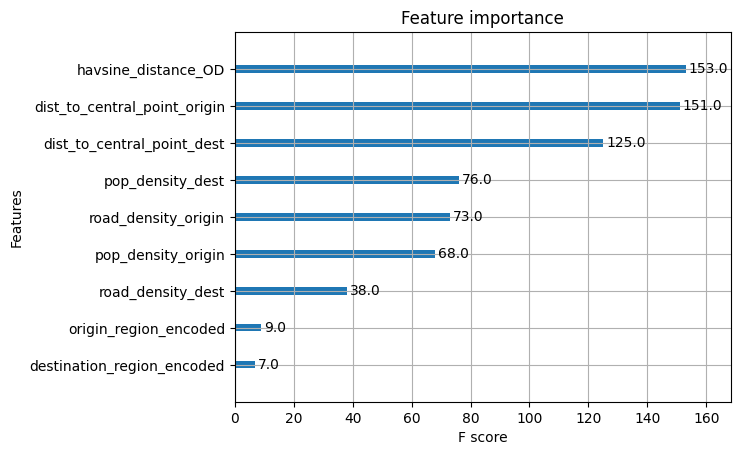

                        Feature     Importance
7  dist_to_central_point_origin  242135.156250
1              pop_density_dest  130709.867188
8    dist_to_central_point_dest  129917.242188
6           havsine_distance_OD   87787.421875
2           road_density_origin   68621.070312
5             road_density_dest   60172.578125
0            pop_density_origin   59612.507812
4         origin_region_encoded   32798.921875
3    destination_region_encoded   15163.975586


In [65]:
# 1. Prepare Data:

#origin_region_encoded + destination_region_encoded + dist_to_central_point_origin + dist_to_central_point_dest + havsine_distance_OD'
#X = re_diff_val_encoded[['road_density_origin', 'dist_to_central_point_origin', 'dist_to_central_point_dest',
#                       'road_density_dest', 'havsine_distance_OD']]
#destination_region_encoded + origin_region_encoded
X = re_diff_val_encoded[['pop_density_origin','pop_density_dest', 'road_density_origin', 'destination_region_encoded', 'origin_region_encoded',
                       'road_density_dest', 'havsine_distance_OD','dist_to_central_point_origin', 'dist_to_central_point_dest']]
y = re_diff_val_encoded['re_diff_tt']

# 1. Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  


# 2. Create DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# 3. Set Hyperparameters (Tune these!)
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.1,
    'max_depth': 3,
}

# 4. Train the XGBRegressor (Note the change here)
model = xgb.XGBRegressor(**params)  # Use XGBRegressor for scikit-learn compatibility
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=10)

# 5. Model Summary (Optional - shows parameters and tree structure)
print("XGBoost Model Summary:")
print(model.get_booster().get_dump(with_stats=True))

# 6. Evaluation Metrics
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)  

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"Training RMSE: {train_rmse:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")
print(f"Training R-squared: {train_r2:.4f}")
print(f"Testing R-squared: {test_r2:.4f}")
print(f"Training MAE: {train_mae:.2f}")
print(f"Testing MAE: {test_mae:.2f}")

# 7. Feature Importance
# (You can use the model directly with plot_importance or the get_booster method.)
# Option 1:
plot_importance(model)  # or plot_importance(model.get_booster()) 
plt.show()
# Option 2:
importance = model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({'Feature': importance.keys(), 'Importance': importance.values()})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)


[0]	validation_0-rmse:8.42177	validation_1-rmse:8.38870
[1]	validation_0-rmse:8.32709	validation_1-rmse:8.29223
[2]	validation_0-rmse:8.24450	validation_1-rmse:8.20825
[3]	validation_0-rmse:8.16942	validation_1-rmse:8.13333
[4]	validation_0-rmse:8.10725	validation_1-rmse:8.07073
[5]	validation_0-rmse:8.05135	validation_1-rmse:8.01514


/home/mengyuwsl/.local/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-rmse:8.00211	validation_1-rmse:7.96557
[7]	validation_0-rmse:7.95711	validation_1-rmse:7.92081
[8]	validation_0-rmse:7.91911	validation_1-rmse:7.88267
[9]	validation_0-rmse:7.88386	validation_1-rmse:7.84712
[10]	validation_0-rmse:7.85360	validation_1-rmse:7.81773
[11]	validation_0-rmse:7.81937	validation_1-rmse:7.78353
[12]	validation_0-rmse:7.79498	validation_1-rmse:7.75939
[13]	validation_0-rmse:7.77285	validation_1-rmse:7.73782
[14]	validation_0-rmse:7.74498	validation_1-rmse:7.71015
[15]	validation_0-rmse:7.72658	validation_1-rmse:7.69182
[16]	validation_0-rmse:7.70708	validation_1-rmse:7.67357
[17]	validation_0-rmse:7.68528	validation_1-rmse:7.65246
[18]	validation_0-rmse:7.66438	validation_1-rmse:7.63196
[19]	validation_0-rmse:7.65088	validation_1-rmse:7.61870
[20]	validation_0-rmse:7.63563	validation_1-rmse:7.60392
[21]	validation_0-rmse:7.62282	validation_1-rmse:7.59209
[22]	validation_0-rmse:7.61047	validation_1-rmse:7.57994
[23]	validation_0-rmse:7.59439	vali

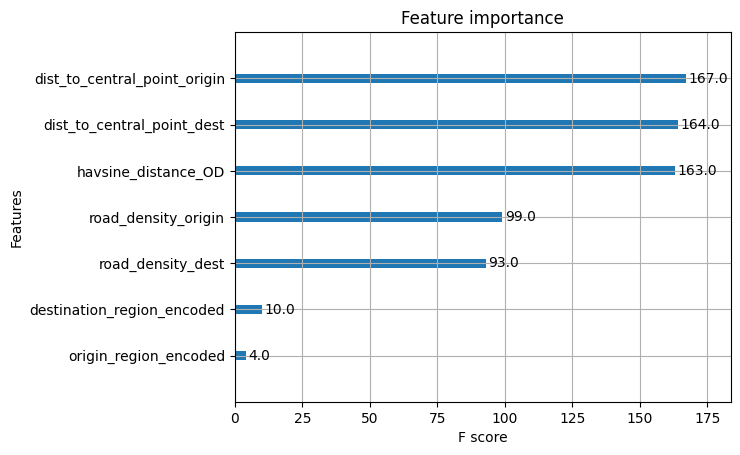

                        Feature     Importance
5  dist_to_central_point_origin  223864.484375
6    dist_to_central_point_dest  106835.656250
3             road_density_dest   95306.679688
4           havsine_distance_OD   82735.101562
0           road_density_origin   66563.625000
1    destination_region_encoded   26390.474609
2         origin_region_encoded   15766.894531


In [44]:
# 1. Prepare Data:

#origin_region_encoded + destination_region_encoded + dist_to_central_point_origin + dist_to_central_point_dest + havsine_distance_OD'
#X = re_diff_val_encoded[['road_density_origin', 'dist_to_central_point_origin', 'dist_to_central_point_dest',
#                       'road_density_dest', 'havsine_distance_OD']]
#destination_region_encoded + origin_region_encoded
X = re_diff_val_encoded[['road_density_origin', 'destination_region_encoded', 'origin_region_encoded',
                       'road_density_dest', 'havsine_distance_OD','dist_to_central_point_origin', 'dist_to_central_point_dest']]
y = re_diff_val_encoded['re_diff_tt']

# 1. Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  


# 2. Create DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# 3. Set Hyperparameters (Tune these!)
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.1,
    'max_depth': 3,
}

# 4. Train the XGBRegressor (Note the change here)
model = xgb.XGBRegressor(**params)  # Use XGBRegressor for scikit-learn compatibility
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=10)

# 5. Model Summary (Optional - shows parameters and tree structure)
print("XGBoost Model Summary:")
print(model.get_booster().get_dump(with_stats=True))

# 6. Evaluation Metrics
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)  

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"Training RMSE: {train_rmse:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")
print(f"Training R-squared: {train_r2:.4f}")
print(f"Testing R-squared: {test_r2:.4f}")
print(f"Training MAE: {train_mae:.2f}")
print(f"Testing MAE: {test_mae:.2f}")

# 7. Feature Importance
# (You can use the model directly with plot_importance or the get_booster method.)
# Option 1:
plot_importance(model)  # or plot_importance(model.get_booster()) 
plt.show()
# Option 2:
importance = model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({'Feature': importance.keys(), 'Importance': importance.values()})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)


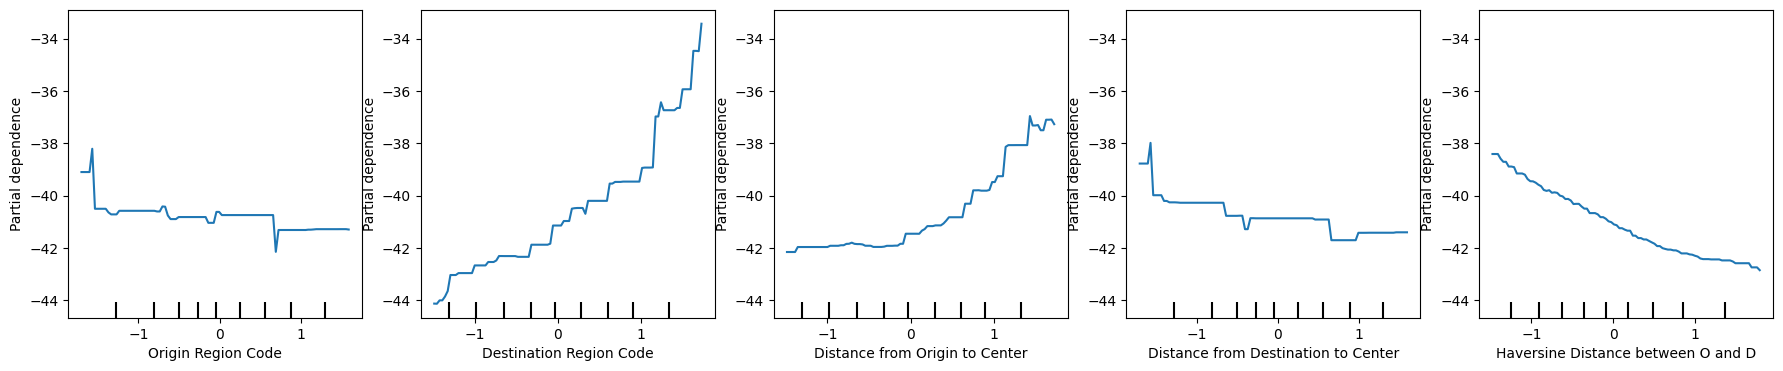

In [101]:
# Define custom titles for each feature (match the order in your 'features' list)
custom_titles = [
    "Origin Region\nEncoded", 
    "Destination Region\nEncoded", 
    "Distance to Center\n(Origin)", 
    "Distance to Center\n(Destination)", 
    "Haversine Distance\n(O to D)"
]

# Create the figure and axis
#fig, ax = plt.subplots(figsize=(12, 8))  
fig, axs = plt.subplots(1, 5, figsize=(22, 4))
# Generate partial dependence plots
display = PartialDependenceDisplay.from_estimator(model, X_train, features=[0, 1, 2, 3, 4], ax=axs)

# Iterate through axes and set custom titles
#plt.gca().set_title(custom_titles[0], fontsize=12)
custom_xlabels = ["Origin Region Code", "Destination Region Code", "Distance from Origin to Center", "Distance from Destination to Center", "Haversine Distance between O and D"]

# Iterate through axes and set custom labels
for i, ax in enumerate(axs.flat):  # Iterate over all axes in the gri
    ax.yaxis.set_label_coords(-0.15, 0.5)
    ax.set_xlabel(custom_xlabels[i], fontsize=10)  # Set custom x

# Adjust subplot spacing if needed (optional)
plt.subplots_adjust(hspace=1.1) 

# Show the plot
plt.show()

Interpreting the Plots

    X-axis: Represents the values of the feature. Note these are likely scaled values.
    Y-axis: Shows the average marginal effect of the feature on the predicted outcome (re_diff_tt in your case).
    Line: The line illustrates how changing the feature's value impacts the predicted outcome, averaged over all instances in your dataset.

Interpreting Each Feature:

    origin_region_encoded, destination_region_encoded: The flat lines suggest that these encoded region features don't have a significant impact on the predicted re_diff_tt. There doesn't seem to be a clear relationship between the origin or destination region and the travel time difference.
    dist_to_central_point_origin: The plot is mostly flat with a slight increase towards the end. This indicates that for most distances from the origin to the central point, there's not a strong effect on re_diff_tt. However, for the largest distances, there's a slight positive relationship, suggesting that being farther from the central point at the origin might slightly increase the travel time difference.
    dist_to_central_point_dest: The line has a negative slope, indicating that as the distance from the destination to the central point increases, the predicted re_diff_tt decreases. This suggests that being farther away from the central point at the destination might lead to a lower travel time difference.
    haversine_distance_OD: This plot shows a clear positive relationship. As the Haversine distance between the origin and destination increases, the predicted re_diff_tt also increases. This is intuitive: longer distances generally lead to larger differences in travel times.

Key Takeaways:

    The Haversine distance between origin and destination is the most influential feature on the predicted travel time difference.
    The distance of the destination to the central point has a moderate negative impact on the predicted outcome.
    The distance of the origin to the central point has a minimal positive effect.
    The encoded origin and destination regions don't seem to be important predictors in this model.

Further Analysis:

    Explore Interactions: You could investigate interactions between features using 2D partial dependence plots or other techniques.
    Consider Feature Engineering: Perhaps creating features that combine information from multiple existing features (e.g., difference in distance to central point between origin and destination) might improve the model's performance.


he partial dependence plot for "Distance from Origin to Center" reveals an interesting relationship between a routing position's distance from London's city center and the relative difference in routing time between your target API and the benchmark API.

 Here's how to interpret it:

    Overall Trend: The plot shows a general upward trend, meaning that as the distance from the city center increases, the relative difference in routing time also tends to increase. This suggests that your target API tends to predict longer travel times compared to the benchmark API, especially for locations farther from the city center.

    Plateau Effect:  The trend isn't perfectly linear. There seems to be a plateau between distances of approximately 0.5 and 1.5 (units depend on how you scaled the distances). In this range, the relative difference in routing time remains relatively stable, implying that the two APIs perform more similarly in this zone.

    Steep Increase Beyond 1.5: After a distance of about 1.5, there's a steep increase in the relative difference. This indicates that for locations farther from the city center, your target API significantly overestimates travel times compared to the benchmark API.

Possible Explanations:

    Traffic Modeling: Your target API might not be modeling traffic congestion as accurately as the benchmark API, particularly in areas farther from the city center where traffic patterns can be more complex.
    Route Optimization: The benchmark API might be better at finding optimal routes, leading to shorter travel times compared to your target API.
    Data Differences: The underlying map data used by the two APIs might differ, leading to discrepancies in distances and, consequently, travel times.

Further Analysis:

    Examine Specific Routes: Investigate specific routes that start far from the city center to see if your target API consistently suggests less efficient routes than the benchmark API.
    Analyze Traffic Data: Compare the traffic data used by both APIs to identify any discrepancies that could explain the differences in travel time estimates.
    Experiment with Parameters: If your target API has adjustable parameters for traffic modeling or route optimization, try fine-tuning them to see if you can improve the accuracy of its predictions.

[0]	validation_0-rmse:11.75768	validation_1-rmse:11.70763
[1]	validation_0-rmse:11.58212	validation_1-rmse:11.53245
[2]	validation_0-rmse:11.43733	validation_1-rmse:11.38912
[3]	validation_0-rmse:11.27923	validation_1-rmse:11.23209
[4]	validation_0-rmse:11.16446	validation_1-rmse:11.11804
[5]	validation_0-rmse:11.04831	validation_1-rmse:11.00459


/home/mengyuwsl/.local/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-rmse:10.95187	validation_1-rmse:10.90876
[7]	validation_0-rmse:10.86166	validation_1-rmse:10.81963
[8]	validation_0-rmse:10.78751	validation_1-rmse:10.74594
[9]	validation_0-rmse:10.71566	validation_1-rmse:10.67432
[10]	validation_0-rmse:10.63568	validation_1-rmse:10.59764
[11]	validation_0-rmse:10.57921	validation_1-rmse:10.54249
[12]	validation_0-rmse:10.52524	validation_1-rmse:10.48906
[13]	validation_0-rmse:10.46944	validation_1-rmse:10.43308
[14]	validation_0-rmse:10.42896	validation_1-rmse:10.39423
[15]	validation_0-rmse:10.38654	validation_1-rmse:10.35214
[16]	validation_0-rmse:10.34573	validation_1-rmse:10.31133
[17]	validation_0-rmse:10.31116	validation_1-rmse:10.27769
[18]	validation_0-rmse:10.27588	validation_1-rmse:10.24265
[19]	validation_0-rmse:10.24695	validation_1-rmse:10.21540
[20]	validation_0-rmse:10.21464	validation_1-rmse:10.18291
[21]	validation_0-rmse:10.18959	validation_1-rmse:10.15864
[22]	validation_0-rmse:10.16776	validation_1-rmse:10.13826
[

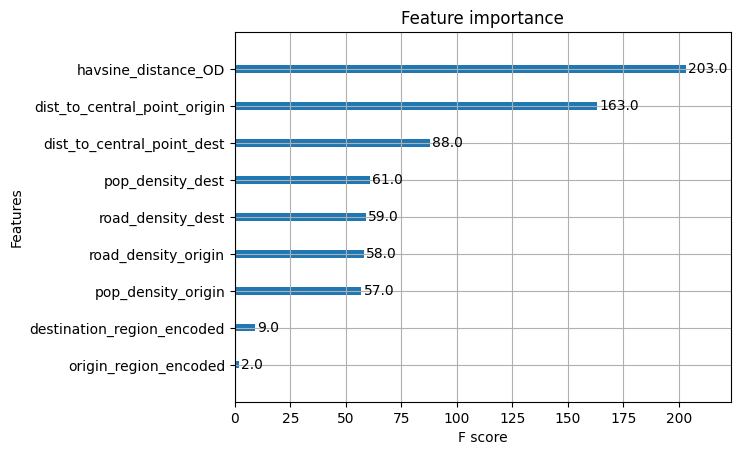

                        Feature     Importance
6           havsine_distance_OD  404546.062500
7  dist_to_central_point_origin  382705.218750
2           road_density_origin  381362.031250
1              pop_density_dest  237542.000000
8    dist_to_central_point_dest  202889.656250
0            pop_density_origin  190158.437500
5             road_density_dest  183432.578125
4         origin_region_encoded   61354.242188
3    destination_region_encoded   51902.886719


In [66]:
# 1. Prepare Data:

#origin_region_encoded + destination_region_encoded + dist_to_central_point_origin + dist_to_central_point_dest + havsine_distance_OD'
#X = re_diff_r5_encoded[['road_density_origin', 'dist_to_central_point_origin', 'dist_to_central_point_dest',
#                       'road_density_dest', 'havsine_distance_OD']]
X = re_diff_r5_encoded[['pop_density_origin','pop_density_dest', 'road_density_origin', 'destination_region_encoded', 'origin_region_encoded',
                       'road_density_dest', 'havsine_distance_OD','dist_to_central_point_origin', 'dist_to_central_point_dest']]
y = re_diff_r5_encoded['re_diff_tt']

# 1. Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  


# 2. Create DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# 3. Set Hyperparameters (Tune these!)
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.1,
    'max_depth': 3,
}

# 4. Train the XGBRegressor (Note the change here)
model = xgb.XGBRegressor(**params)  # Use XGBRegressor for scikit-learn compatibility
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=10)

# 5. Model Summary (Optional - shows parameters and tree structure)
print("XGBoost Model Summary:")
print(model.get_booster().get_dump(with_stats=True))

# 6. Evaluation Metrics
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)  

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"Training RMSE: {train_rmse:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")
print(f"Training R-squared: {train_r2:.4f}")
print(f"Testing R-squared: {test_r2:.4f}")
print(f"Training MAE: {train_mae:.2f}")
print(f"Testing MAE: {test_mae:.2f}")

# 7. Feature Importance
# (You can use the model directly with plot_importance or the get_booster method.)
# Option 1:
plot_importance(model)  # or plot_importance(model.get_booster()) 
plt.show()
# Option 2:
importance = model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({'Feature': importance.keys(), 'Importance': importance.values()})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)


In [ ]:
# Define custom titles for each feature (match the order in your 'features' list)
custom_titles = [
    "Origin Region\nEncoded", 
    "Destination Region\nEncoded", 
    "Distance to Center\n(Origin)", 
    "Distance to Center\n(Destination)", 
    "Haversine Distance\n(O to D)"
]

# Create the figure and axis
#fig, ax = plt.subplots(figsize=(12, 8))  
fig, axs = plt.subplots(1, 5, figsize=(22, 4))
# Generate partial dependence plots
display = PartialDependenceDisplay.from_estimator(model, X_train, features=[0, 1, 2, 3, 4], ax=axs)

# Iterate through axes and set custom titles
#plt.gca().set_title(custom_titles[0], fontsize=12)
custom_xlabels = ["Origin Region Code", "Destination Region Code", "Distance from Origin to Center", "Distance from Destination to Center", "Haversine Distance between O and D"]

# Iterate through axes and set custom labels
for i, ax in enumerate(axs.flat):  # Iterate over all axes in the gri
    ax.yaxis.set_label_coords(-0.15, 0.5)
    ax.set_xlabel(custom_xlabels[i], fontsize=10)  # Set custom x

# Adjust subplot spacing if needed (optional)
plt.subplots_adjust(hspace=1.1) 

# Show the plot
plt.show()

[0]	validation_0-rmse:8.34001	validation_1-rmse:8.31863
[1]	validation_0-rmse:8.23628	validation_1-rmse:8.21376
[2]	validation_0-rmse:8.14954	validation_1-rmse:8.12495
[3]	validation_0-rmse:8.07669	validation_1-rmse:8.05208
[4]	validation_0-rmse:8.01427	validation_1-rmse:7.98845


/home/mengyuwsl/.local/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-rmse:7.95989	validation_1-rmse:7.93386
[6]	validation_0-rmse:7.91353	validation_1-rmse:7.88659
[7]	validation_0-rmse:7.86960	validation_1-rmse:7.84335
[8]	validation_0-rmse:7.83374	validation_1-rmse:7.80785
[9]	validation_0-rmse:7.80178	validation_1-rmse:7.77556
[10]	validation_0-rmse:7.77363	validation_1-rmse:7.74706
[11]	validation_0-rmse:7.74807	validation_1-rmse:7.72176
[12]	validation_0-rmse:7.72658	validation_1-rmse:7.69985
[13]	validation_0-rmse:7.70644	validation_1-rmse:7.67991
[14]	validation_0-rmse:7.68684	validation_1-rmse:7.66073
[15]	validation_0-rmse:7.67093	validation_1-rmse:7.64495
[16]	validation_0-rmse:7.65127	validation_1-rmse:7.62506
[17]	validation_0-rmse:7.63681	validation_1-rmse:7.61031
[18]	validation_0-rmse:7.62370	validation_1-rmse:7.59727
[19]	validation_0-rmse:7.61170	validation_1-rmse:7.58571
[20]	validation_0-rmse:7.60002	validation_1-rmse:7.57478
[21]	validation_0-rmse:7.58611	validation_1-rmse:7.56118
[22]	validation_0-rmse:7.57726	valid

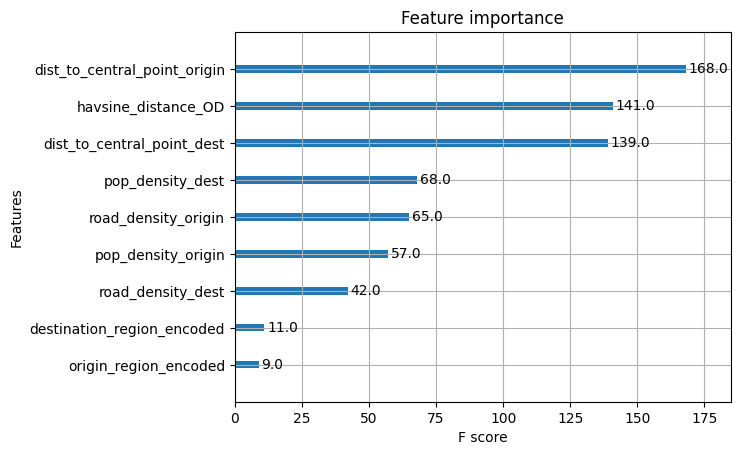

                        Feature     Importance
7  dist_to_central_point_origin  256025.921875
1              pop_density_dest  120383.835938
8    dist_to_central_point_dest  108109.507812
6           havsine_distance_OD   56023.179688
4         origin_region_encoded   49880.742188
2           road_density_origin   47921.390625
0            pop_density_origin   42519.023438
5             road_density_dest   24830.929688
3    destination_region_encoded   19763.308594


In [67]:
# 1. Prepare Data:

#origin_region_encoded + destination_region_encoded + dist_to_central_point_origin + dist_to_central_point_dest + havsine_distance_OD'
#X = re_diff_osrm_encoded[['road_density_origin', 'dist_to_central_point_origin', 'dist_to_central_point_dest',
#                       'road_density_dest', 'havsine_distance_OD']]
X = re_diff_osrm_encoded[['pop_density_origin','pop_density_dest', 'road_density_origin', 'destination_region_encoded', 'origin_region_encoded',
                       'road_density_dest', 'havsine_distance_OD','dist_to_central_point_origin', 'dist_to_central_point_dest']]
y = re_diff_osrm_encoded['re_diff_tt']

# 1. Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  


# 2. Create DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# 3. Set Hyperparameters (Tune these!)
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.1,
    'max_depth': 3,
}

# 4. Train the XGBRegressor (Note the change here)
model = xgb.XGBRegressor(**params)  # Use XGBRegressor for scikit-learn compatibility
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=10)

# 5. Model Summary (Optional - shows parameters and tree structure)
print("XGBoost Model Summary:")
print(model.get_booster().get_dump(with_stats=True))

# 6. Evaluation Metrics
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)  

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"Training RMSE: {train_rmse:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")
print(f"Training R-squared: {train_r2:.4f}")
print(f"Testing R-squared: {test_r2:.4f}")
print(f"Training MAE: {train_mae:.2f}")
print(f"Testing MAE: {test_mae:.2f}")

# 7. Feature Importance
# (You can use the model directly with plot_importance or the get_booster method.)
# Option 1:
plot_importance(model)  # or plot_importance(model.get_booster()) 
plt.show()
# Option 2:
importance = model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({'Feature': importance.keys(), 'Importance': importance.values()})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)


In [ ]:
# Define custom titles for each feature (match the order in your 'features' list)
custom_titles = [
    "Origin Region\nEncoded", 
    "Destination Region\nEncoded", 
    "Distance to Center\n(Origin)", 
    "Distance to Center\n(Destination)", 
    "Haversine Distance\n(O to D)"
]

# Create the figure and axis
#fig, ax = plt.subplots(figsize=(12, 8))  
fig, axs = plt.subplots(1, 5, figsize=(22, 4))
# Generate partial dependence plots
display = PartialDependenceDisplay.from_estimator(model, X_train, features=[0, 1, 2, 3, 4], ax=axs)

# Iterate through axes and set custom titles
#plt.gca().set_title(custom_titles[0], fontsize=12)
custom_xlabels = ["Origin Region Code", "Destination Region Code", "Distance from Origin to Center", "Distance from Destination to Center", "Haversine Distance between O and D"]

# Iterate through axes and set custom labels
for i, ax in enumerate(axs.flat):  # Iterate over all axes in the gri
    ax.yaxis.set_label_coords(-0.15, 0.5)
    ax.set_xlabel(custom_xlabels[i], fontsize=10)  # Set custom x

# Adjust subplot spacing if needed (optional)
plt.subplots_adjust(hspace=1.1) 

# Show the plot
plt.show()

The feature importance plots indicate the contribution of each feature in the XGBoost model to predict the relative time estimation differences between three routing APIs (Valhalla, R5, and OSRM) compared to the baseline API, HERE.
Features:

    havsine_distance_OD: The Haversine distance between the origin and destination.
    dist_to_central_point_origin: The distance from the origin to a central point.
    dist_to_central_point_dest: The distance from the destination to a central point.
    destination_region_encoded: Encoded categorical feature representing the destination region.
    origin_region_encoded: Encoded categorical feature representing the origin region.

Plot Interpretation:

    Valhalla (First Plot):
        havsine_distance_OD: Highest importance (~240), indicating that the straight-line distance between origin and destination is the most significant factor in explaining the relative time estimation difference from HERE.
        dist_to_central_point_origin: High importance (~234), suggesting that how far the origin is from a central point also significantly influences the relative time difference.
        dist_to_central_point_dest: Significant importance (~196), implying that the destination's distance from the central point is also a critical factor.
        destination_region_encoded and origin_region_encoded: Much lower importance (18 and 12, respectively), indicating that the region-specific features are less influential in predicting the relative time difference for Valhalla compared to HERE.

    R5 (Second Plot):
        havsine_distance_OD: Highest importance (~248), similar to Valhalla, indicating the straight-line distance is the most critical factor for R5 as well.
        dist_to_central_point_dest: High importance (~227), suggesting that the destination's distance from the central point is significant.
        dist_to_central_point_origin: Considerable importance (~207), indicating the origin's distance from the central point also plays a vital role.
        destination_region_encoded and origin_region_encoded: Lower importance (14 and 4, respectively), suggesting these features are less impactful for R5 compared to HERE.

    OSRM (Third Plot):
        dist_to_central_point_dest: Highest importance (~239), indicating the destination's distance from the central point is the most critical factor for OSRM.
        dist_to_central_point_origin: High importance (~218), implying the origin's distance from the central point is also significant.
        havsine_distance_OD: Considerable importance (~213), indicating the straight-line distance between origin and destination is also a key factor.
        destination_region_encoded and origin_region_encoded: Lower importance (19 and 11, respectively), indicating these region-specific features are less important for OSRM relative to HERE.

Summary:

    Common Patterns:
        All three APIs show that straight-line distance (havsine_distance_OD) and distances to central points (dist_to_central_point_origin and dist_to_central_point_dest) are the most important features in predicting the relative time estimation differences from HERE.
        Region-specific features (destination_region_encoded and origin_region_encoded) have significantly lower importance across all three APIs.

    API-Specific Insights:
        Valhalla: Emphasizes the straight-line distance and origin's distance to the central point slightly more than the destination's distance to the central point.
        R5: Similar emphasis on straight-line distance, but both distances to central points are also crucial.
        OSRM: Puts the highest importance on the destination's distance to the central point, followed by the origin's distance and the straight-line distance.

These insights can help understand how each routing API calculates travel times differently compared to HERE, and which factors are most influential in these differences.



 Feature     Importance
dist_to_central_point_origin  256025.921875
pop_density_dest  120383.835938
dist_to_central_point_dest  108109.51
havsine_distance_OD   56023.18
origin_region_encoded   49880.742188
road_density_origin   47921.390625
pop_density_origin   42519.023438
road_density_dest   24830.929688
3    destination_region_encoded   19763.308594


R5                   Feature     Importance
havsine_distance_OD  404546.062500
dist_to_central_point_origin  382705.218750
road_density_origin  381362.031250
pop_density_dest  237542.000000
dist_to_central_point_dest  202889.656250
0            pop_density_origin  190158.437500
5             road_density_dest  183432.578125
4         origin_region_encoded   61354.242188
3    destination_region_encoded   51902.886719

Val  Feature     Importance
dist_to_central_point_origin  242135.156250
1              pop_density_dest  130709.867188
dist_to_central_point_dest  129917.242188
havsine_distance_OD   87787.421875
2           road_density_origin   68621.070312
5             road_density_dest   60172.578125
0            pop_density_origin   59612.507812
4         origin_region_encoded   32798.921875
3    destination_region_encoded   15163.975586


In [2]:
data_f_import = {
    'Variables': [
        'Origin MSOAD Distance to Central London Central Point',
        'Destination MSOA Distance to Central London Central Point',
        'Haversine Distance between Origin and Destination',
        'Road Density at Origin MSOA',
        'Road Density at Destination MSOA',
        'Destination Region Encoded',
        'Origin Region Encoded',
        'Population Density at Origin MSOA',
        'Population Density at Destination MSOA',
    ],
    'R5': [
        382705.22, 202889.66, 404546.06, 381362.03, 183432.58, 51902.89, 61354.24, 190158.44, 237542.00
    ],
    'OSRM': [
        256025.92, 108109.51, 56023.18, 47921.39, 24830.93, 19763.31 , 49880.74, 42519.02, 120383.83
    ],
    'Valhalla': [
        242135.16, 129917.24, 87787.42, 68621.07, 60172.58, 15163.98, 32798.92, 68621.07, 130709.87
    ]
}

df_f_import = pd.DataFrame(data_f_import)


In [81]:
df_f_import

R5       OSRM  \
Variables                                                                  
Origin MSOAD Distance to Central London Central...  382705.22  256025.92   
Destination MSOA Distance to Central London Cen...  202889.66  108109.51   
Haversine Distance between Origin and Destination   404546.06   56023.18   
Road Density at Origin MSOA                         381362.03   47921.39   
Road Density at Destination MSOA                    183432.58   24830.93   
Destination Region Encoded                           51902.89   19763.31   
Origin Region Encoded                                61354.24   49880.74   
Population Density at Origin MSOA                   190158.44   42519.02   
Population Density at Destination MSOA              237542.00  120383.83   

                                                     Valhalla  
Variables                                                      
Origin MSOAD Distance to Central London Central...  242135.16  
Destination MSOA Distance to Central London Cen...  129917.24  
Haversine Distance between Origin and Destination    87787.42  
Road Density at Origin MSOA                          68621.07  
Road Density at Destination MSOA                     60172.58  
Destination Region Encoded                           15163.98  
Origin Region Encoded                                32798.92  
Population Density at Origin MSOA                    68621.07  
Population Density at Destination MSOA              130709.87

In [3]:
colors = ['#92c5de','#f4a582','#0571b0']

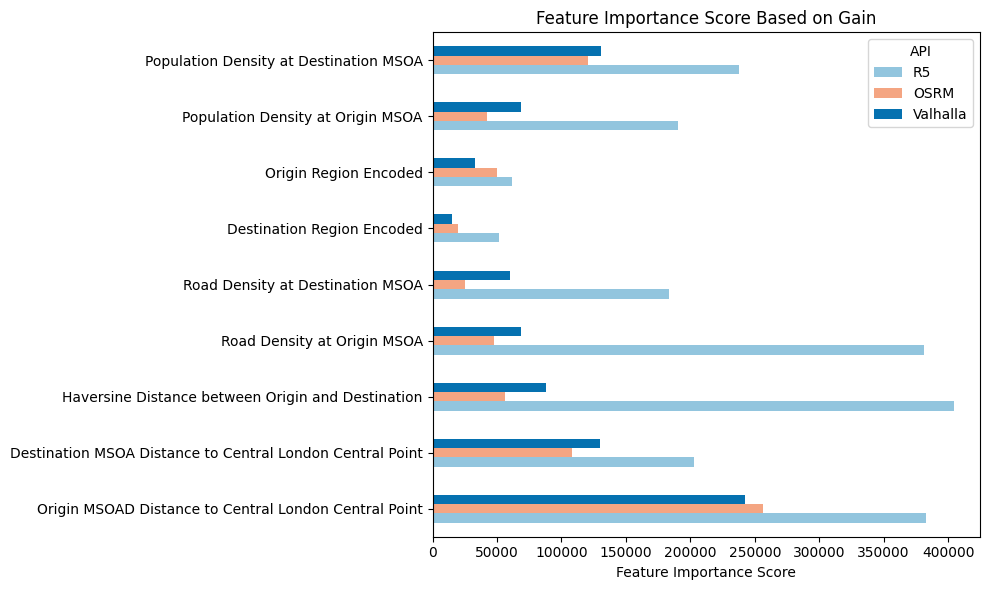

In [7]:
ax = df_f_import.plot(kind='barh', figsize=(10, 6), color=colors)

# Add titles and labels
plt.title('Feature Importance Score Based on Gain')
plt.xlabel('Feature Importance Score')
plt.legend(title='API')

# Suppress the y-label
ax.set_ylabel('')

# Display the plot
plt.tight_layout()
plt.show()

In [47]:
data_f_import = {
    'Variables': [
        'Distance to central London point of the origin MSOA',
        'Distance to central London point of the destination MSOA',
        'Haversine distance between origin and destination',
        'Road density at origin MSOA',
        'Road density at destination MSOA',
        'Destination Region Encoded',
        'Origin Region Encoded'
    ],
    'R5': [
        365269.80, 169901.23, 397061.09, 364372.06, 194615.25, 45013.63, 4988.35
    ],
    'OSRM': [
        238762.98, 94944.01, 50641.45, 46597.50, 64476.49, 29009.68, 45622.17
    ],
    'Valhalla': [
        223864.48, 106835.66, 82735.10, 66563.63, 95306.68, 26390.47, 15766.89
    ]
}

# Create a DataFrame
df_f_import = pd.DataFrame(data_f_import)

In [78]:
df_f_import

Variables         R5       OSRM  \
0  Origin MSOAD Distance to Central London Centra...  382705.22  256025.92   
1  Destination MSOA Distance to Central London Ce...  202889.66  108109.51   
2  Haversine Distance between Origin and Destination  404546.06   56023.18   
3                        Road Density at Origin MSOA  381362.03   47921.39   
4                   Road Density at Destination MSOA  183432.58   24830.93   
5                         Destination Region Encoded   51902.89   19763.31   
6                              Origin Region Encoded   61354.24   49880.74   
7                  Population Density at Origin MSOA  190158.44   42519.02   
8             Population Density at Destination MSOA  237542.00  120383.83   

    Valhalla  
0  242135.16  
1  129917.24  
2   87787.42  
3   68621.07  
4   60172.58  
5   15163.98  
6   32798.92  
7   68621.07  
8  130709.87

In [79]:
# save the df_f_import to csv:
df_f_import.to_csv(r'/mnt/d/University College London/Chen, Huanfa - Dissertation_Mengyu_Ding/Data/regression_data/feature_importance_results.csv', index=False)

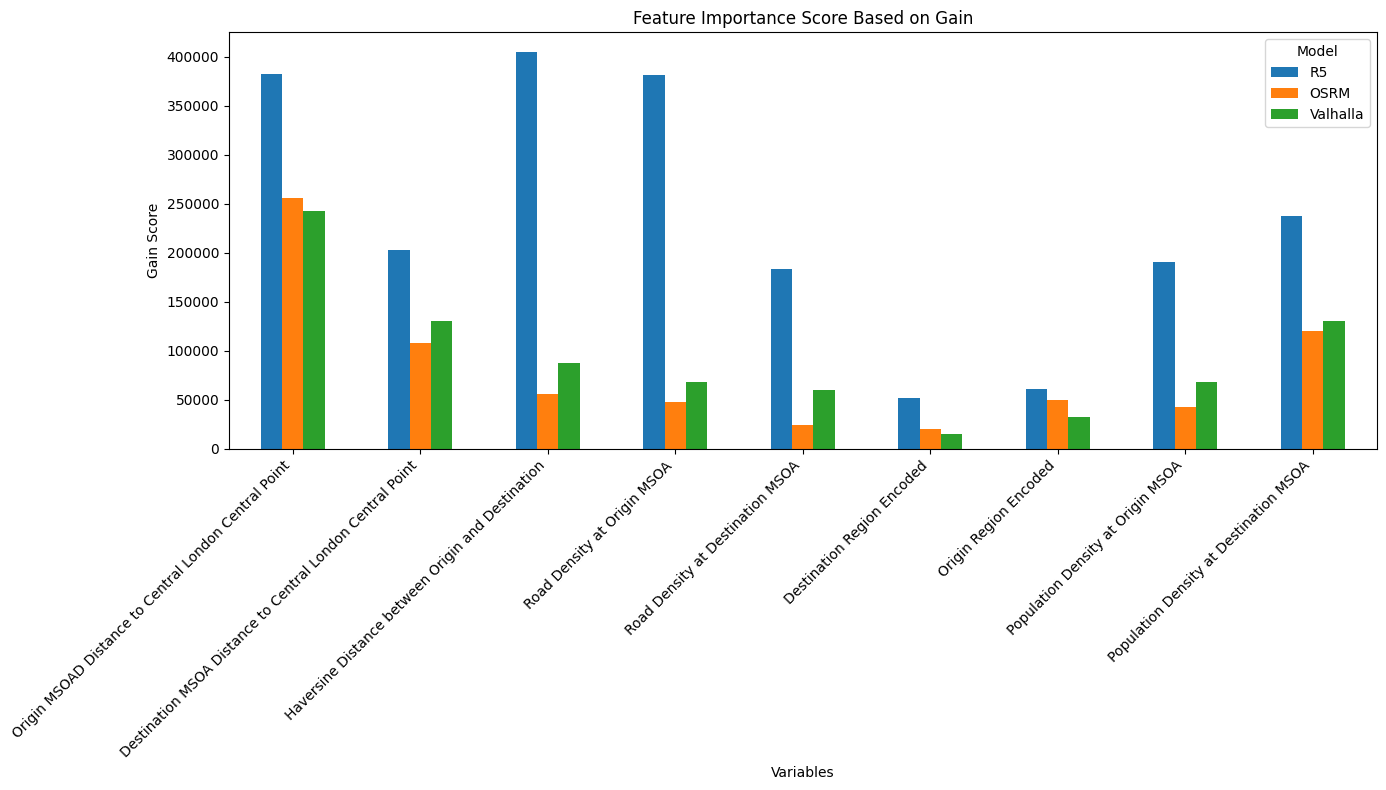

In [6]:
# Set the Variables column as the index
df_f_import.set_index('Variables', inplace=True)

# Plot the data
df_f_import.plot(kind='bar', figsize=(14, 8))

# Add titles and labels
plt.title('Feature Importance Score Based on Gain')
plt.xlabel('Variables')
plt.ylabel('Gain Score')
plt.legend(title='Model')

# Rotate the x labels for better readability
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()

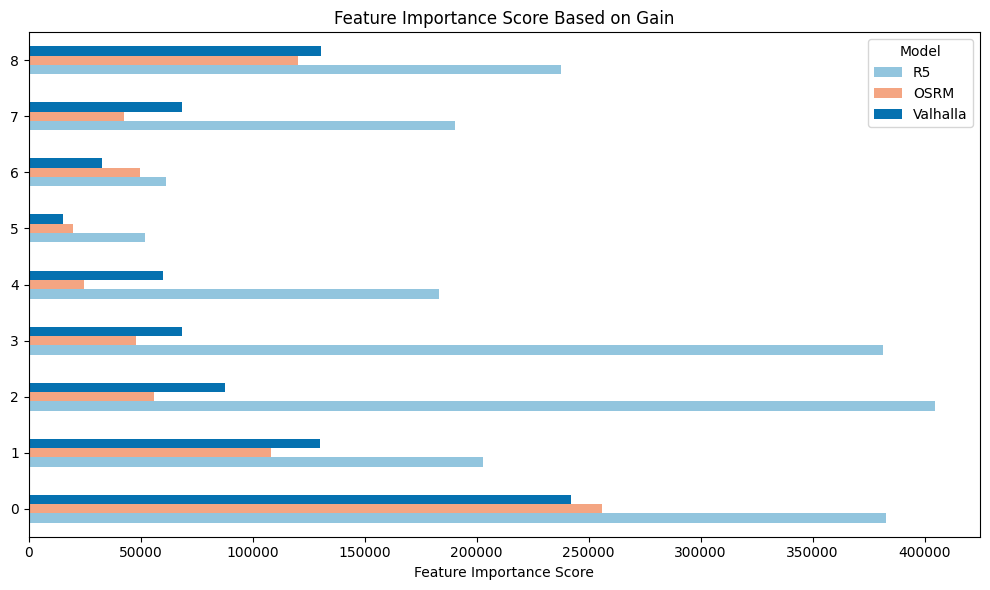

In [77]:
ax = df_f_import.plot(kind='barh', figsize=(10, 6), color=colors)

# Add titles and labels
plt.title('Feature Importance Score Based on Gain')
plt.xlabel('Feature Importance Score')
plt.legend(title='Model')

# show y-label
ax.set_ylabel('')

# Display the plot
plt.tight_layout()
plt.show()

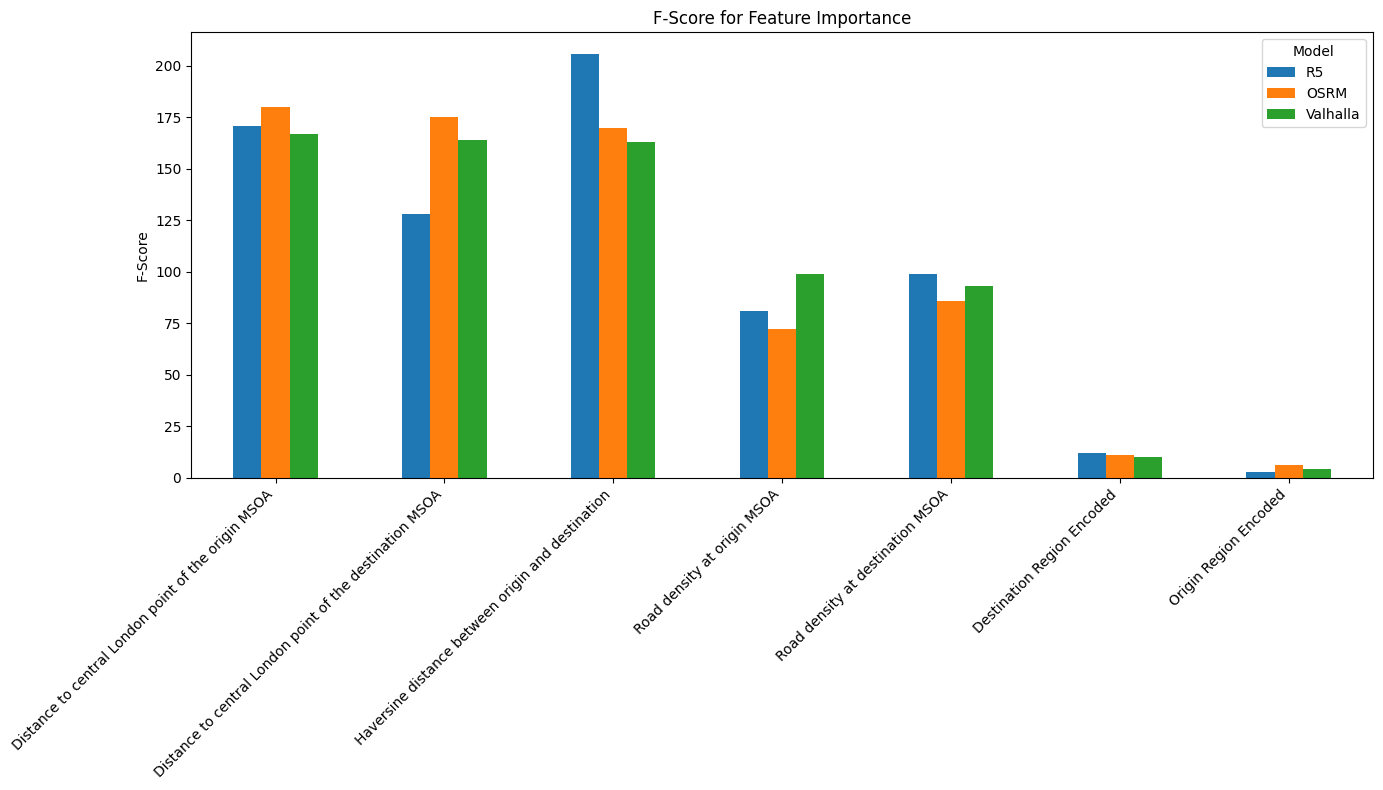

In [53]:
f_score_data = {
    'Variables': [
        'Distance to central London point of the origin MSOA',
        'Distance to central London point of the destination MSOA',
        'Haversine distance between origin and destination',
        'Road density at origin MSOA',
        'Road density at destination MSOA',
        'Destination Region Encoded',
        'Origin Region Encoded'
    ],
    'R5': [171, 128, 206, 81, 99, 12, 3],
    'OSRM': [180, 175, 170, 72, 86, 11, 6],
    'Valhalla': [167, 164, 163, 99, 93, 10, 4]
}

# Create a DataFrame
f_score_df = pd.DataFrame(f_score_data)

# Set the Variables column as the index
f_score_df.set_index('Variables', inplace=True)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] 

ax = f_score_df.plot(kind='bar', figsize=(14, 8), color=colors)
# Add titles and labels
plt.title('F-Score for Feature Importance')
#plt.xlabel('Variables')
plt.ylabel('F-Score')
plt.legend(title='Model')

# Rotate the x labels for better readability
plt.xticks(rotation=45, ha='right')
ax.set_xlabel('')
# Display the plot
plt.tight_layout()
plt.show()

In [59]:
colors = ['#92c5de','#f4a582','#0571b0']

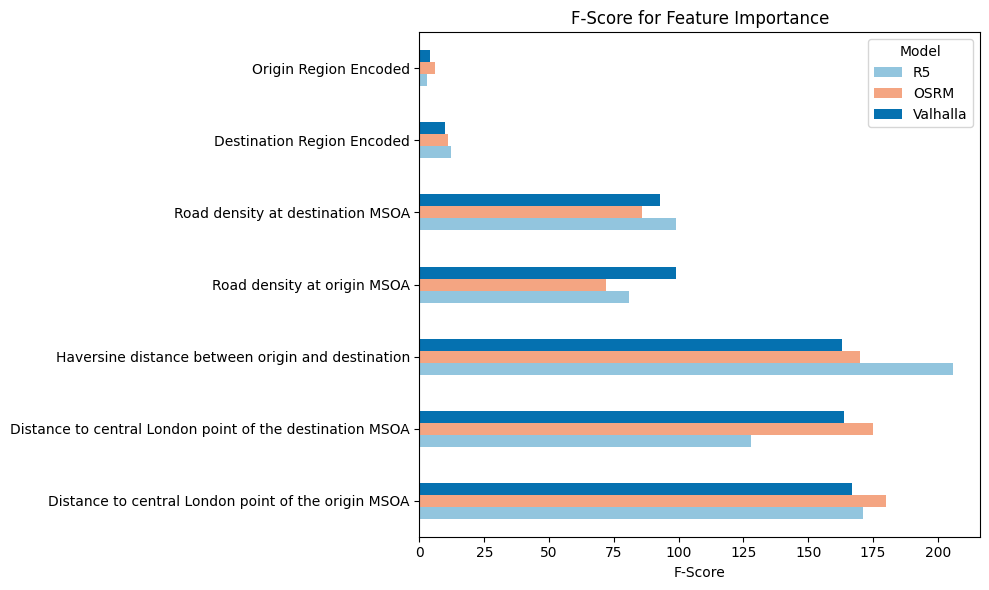

In [60]:
# Plot the data with custom colors
ax = f_score_df.plot(kind='barh', figsize=(10, 6), color=colors)

# Add titles and labels
plt.title('F-Score for Feature Importance')
plt.xlabel('F-Score')
plt.legend(title='Model')

# Suppress the y-label
ax.set_ylabel('')

# Display the plot
plt.tight_layout()
plt.show()

In [61]:
f_score_df

R5  OSRM  Valhalla
Variables                                                              
Distance to central London point of the origin ...  171   180       167
Distance to central London point of the destina...  128   175       164
Haversine distance between origin and destination   206   170       163
Road density at origin MSOA                          81    72        99
Road density at destination MSOA                     99    86        93
Destination Region Encoded                           12    11        10
Origin Region Encoded                                 3     6         4

## 4. Add Income Column
Now, let's add annual median income for each msoa:

In [22]:
# read in the excel located at: r'/mnt/d/University College London/Chen, Huanfa - Dissertation_Mengyu_Ding/Data/msoa/msoaIncome.xlsx' the tab is "Net income after housing costs"
income_df = pd.read_excel(r'/mnt/d/University College London/Chen, Huanfa - Dissertation_Mengyu_Ding/Data/msoa/msoaIncome.xlsx', sheet_name='Net annual income')

In [23]:
income_df.head()

Contents         Unnamed: 1  \
0                                                NaN                NaN   
1  Net annual household income by middle layer su...                NaN   
2                                                NaN                NaN   
3                                          MSOA code          MSOA name   
4                                          E02004297  County Durham 001   

             Unnamed: 2            Unnamed: 3   Unnamed: 4   Unnamed: 5  \
0                   NaN                   NaN          NaN          NaN   
1                   NaN                   NaN          NaN          NaN   
2                   NaN                   NaN          NaN          NaN   
3  Local authority code  Local authority name  Region code  Region name   
4             E06000047         County Durham    E12000001   North East   

              Unnamed: 6                  Unnamed: 7  \
0                    NaN                         NaN   
1                    NaN                         NaN   
2                    NaN                         NaN   
3  Net annual income (£)  Upper confidence limit (£)   
4                  30500                       35300   

                   Unnamed: 8               Unnamed: 9  
0                         NaN                      NaN  
1                         NaN                      NaN  
2                         NaN                      NaN  
3  Lower confidence limit (£)  Confidence interval (£)  
4                       26300                     9000

In [24]:
# remove row 0, 1, 2 and set row 3 as column name:
income_df.columns = income_df.iloc[3]

income_df = income_df.drop([0, 1, 2, 3])

In [25]:
re_diff_osrm_encoded.head()

destinationID   originID  re_diff_tt  origin_lat  origin_lon  \
0     E02000001  E02000002  -19.576336   51.588242    0.139471   
1     E02000001  E02000003  -23.180583   51.574923    0.140919   
2     E02000001  E02000004  -16.475143   51.555446    0.176841   
3     E02000001  E02000005  -17.144105   51.561414    0.143309   
4     E02000001  E02000007  -14.897876   51.558095    0.157363   

   destination_lat  destination_lon  euclidean_distance origin_region  \
0        51.514382        -0.092411            0.243361  Outer London   
1        51.514382        -0.092411            0.241056  Outer London   
2        51.514382        -0.092411            0.272366  Outer London   
3        51.514382        -0.092411            0.240367  Outer London   
4        51.514382        -0.092411            0.253570  Outer London   

  destination_region  ...  origin_region_Inner_London  \
0       Inner London  ...                           0   
1       Inner London  ...                           0   
2       Inner London  ...                           0   
3       Inner London  ...                           0   
4       Inner London  ...                           0   

   origin_region_Outer_London  destination_region_Central_London  \
0                           1                                  0   
1                           1                                  0   
2                           1                                  0   
3                           1                                  0   
4                           1                                  0   

   destination_region_Inner_London  destination_region_Outer_London  \
0                                1                                0   
1                                1                                0   
2                                1                                0   
3                                1                                0   
4                                1                                0   

   dist_to_central_point_origin  dist_to_central_point_dest  \
0                      1.416613                   -1.711729   
1                      1.328895                   -1.711729   
2                      1.625611                   -1.711729   
3                      1.268257                   -1.711729   
4                      1.412054                   -1.711729   

   havsine_distance_OD  origin_region_encoded  destination_region_encoded  
0             0.094603                      2                           1  
1             0.033193                      2                           1  
2             0.228977                      2                           1  
3            -0.008704                      2                           1  
4             0.086791                      2                           1  

[5 rows x 21 columns]

In [26]:
income_dict = income_df.set_index('MSOA code')['Net annual income (£)'].to_dict()



In [39]:
income_dict['E02000001']

62700

In [61]:
# for the re_diff_osrm_encoded add two columns: origin_income and destination_income:
def add_income_info(input_df, income_df):
    # Create dictionaries for quick lookup
    income_dict = income_df.set_index('MSOA code')['Net annual income (£)'].to_dict()
    
    # Function to determine region based on MSOA ID
    def get_income(msoa_id):
        return income_dict.get(msoa_id, 'Unknown')
    
    # Add new columns to the dataframe
    input_df['origin_income'] = input_df['originID'].apply(get_income)
    input_df['destination_income'] = input_df['destinationID'].apply(get_income)
    
    return input_df


r5_with_income = re_diff_r5_encoded.copy()
osrm_with_income = re_diff_osrm_encoded.copy()


r5_with_income  = add_income_info(r5_with_income , income_df)
osrm_with_income = add_income_info(osrm_with_income, income_df)

In [62]:
# check number of 'unknown' in origin_income and destination_income:
r5_with_income ['origin_income'].value_counts()

origin_income
Unknown    39039
41800      12012
40800      11011
42600      11011
43900      11011
           ...  
62000       1001
44100       1001
57100       1001
56200       1001
62700       1001
Name: count, Length: 271, dtype: int64

In [63]:
# for both dataframes, remove rows with 'unknown' in origin_income and destination_income:
r5_with_income  = r5_with_income [r5_with_income ['origin_income'] != 'Unknown']
r5_with_income  = r5_with_income [r5_with_income['destination_income'] != 'Unknown']

In [64]:
osrm_with_income = osrm_with_income[osrm_with_income['origin_income'] != 'Unknown']
osrm_with_income = osrm_with_income[osrm_with_income['destination_income'] != 'Unknown']

In [65]:
cols_to_normalize = ['origin_income', 'destination_income']
scaler = StandardScaler()

r5_with_income[cols_to_normalize] = scaler.fit_transform(r5_with_income[cols_to_normalize])

osrm_with_income[cols_to_normalize] = scaler.fit_transform(osrm_with_income[cols_to_normalize])

now add the income columns to see the differences:

In [66]:
# Fit the linear regression model
model_r5_with_income = smf.ols(
    're_diff_tt ~ destination_income + origin_income + origin_region_encoded + destination_region_encoded + dist_to_central_point_origin + dist_to_central_point_dest + havsine_distance_OD',
    data=r5_with_income,
).fit()

# Print the model summary
print(model_r5_with_income.summary())

                            OLS Regression Results                            
Dep. Variable:             re_diff_tt   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                 3.088e+04
Date:                Thu, 25 Jul 2024   Prob (F-statistic):               0.00
Time:                        10:28:31   Log-Likelihood:            -3.5169e+06
No. Observations:              926406   AIC:                         7.034e+06
Df Residuals:                  926398   BIC:                         7.034e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [67]:
# Fit the linear regression model
model_osrm_with_income = smf.ols(
    're_diff_tt ~ destination_income + origin_income + origin_region_encoded + destination_region_encoded + dist_to_central_point_origin + dist_to_central_point_dest + havsine_distance_OD',
    data=osrm_with_income,
).fit()

# Print the model summary
print(model_osrm_with_income.summary())

                            OLS Regression Results                            
Dep. Variable:             re_diff_tt   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                 2.061e+04
Date:                Thu, 25 Jul 2024   Prob (F-statistic):               0.00
Time:                        10:28:36   Log-Likelihood:            -3.2281e+06
No. Observations:              926406   AIC:                         6.456e+06
Df Residuals:                  926398   BIC:                         6.456e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

[0]	train-rmse:11.78614	eval-rmse:11.80517
[1]	train-rmse:11.64043	eval-rmse:11.65875
[2]	train-rmse:11.50360	eval-rmse:11.52307


/home/mengyuwsl/.local/lib/python3.10/site-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[3]	train-rmse:11.38102	eval-rmse:11.40025
[4]	train-rmse:11.28173	eval-rmse:11.30077
[5]	train-rmse:11.18692	eval-rmse:11.20584
[6]	train-rmse:11.09983	eval-rmse:11.11844
[7]	train-rmse:11.02071	eval-rmse:11.03948
[8]	train-rmse:10.95694	eval-rmse:10.97563
[9]	train-rmse:10.89463	eval-rmse:10.91344
[10]	train-rmse:10.84305	eval-rmse:10.86211
[11]	train-rmse:10.79184	eval-rmse:10.81049
[12]	train-rmse:10.73351	eval-rmse:10.75221
[13]	train-rmse:10.69003	eval-rmse:10.70848
[14]	train-rmse:10.64540	eval-rmse:10.66353
[15]	train-rmse:10.60200	eval-rmse:10.62030
[16]	train-rmse:10.56794	eval-rmse:10.58579
[17]	train-rmse:10.54774	eval-rmse:10.56541
[18]	train-rmse:10.51974	eval-rmse:10.53745
[19]	train-rmse:10.49972	eval-rmse:10.51793
[20]	train-rmse:10.47828	eval-rmse:10.49658
[21]	train-rmse:10.45050	eval-rmse:10.46950
[22]	train-rmse:10.42843	eval-rmse:10.44744
[23]	train-rmse:10.41535	eval-rmse:10.43362
[24]	train-rmse:10.39612	eval-rmse:10.41443
[25]	train-rmse:10.37878	eval-rmse:10.3

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

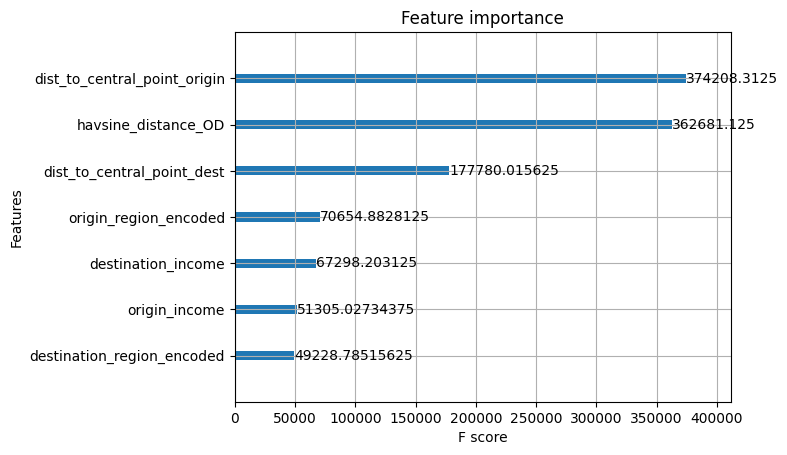

In [72]:
from sklearn.model_selection import train_test_split

# 1. Prepare Data:
X = r5_with_income[['destination_income', 'origin_income', 'origin_region_encoded',
                       'destination_region_encoded', 'dist_to_central_point_origin', 
                       'dist_to_central_point_dest', 'havsine_distance_OD']]
y = r5_with_income['re_diff_tt']

# Split into training and testing sets (optional, but recommended)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Create DMatrix (XGBoost's optimized data structure)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)  # If you've split the data

# 3. Set Hyperparameters (Tune these for optimal performance)
params = {
    'objective': 'reg:squarederror',  # For regression tasks
    'eval_metric': 'rmse',  # Evaluation metric (root mean squared error)
    'eta': 0.1,   # Learning rate (adjust as needed)
    'max_depth': 3,  # Maximum depth of trees
}

num_rounds = 100  # Number of training rounds
# 4. Train and Evaluate:
watchlist = [(dtrain, 'train'), (dtest, 'eval')]  # For evaluation during training
model = xgb.train(params, dtrain, num_rounds, watchlist, early_stopping_rounds=10)  # Early stopping for overfitting prevention

# 5. Model Summary:
print("XGBoost Model Summary:")
print(model.get_dump(with_stats=True))  # Detailed model structure with statistics

# 6. Training and Testing RMSE:
train_rmse = np.sqrt(mean_squared_error(y_train, model.predict(dtrain)))
test_rmse = np.sqrt(mean_squared_error(y_test, model.predict(dtest)))

#print("\nTraining RMSE:", train_rmse)
#print("Testing RMSE:", test_rmse)
# 


# 7. Feature Importance:
importance = model.get_score(importance_type='gain')
xgb.plot_importance(importance)

/home/mengyuwsl/.local/lib/python3.10/site-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-rmse:8.34901	eval-rmse:8.35807
[1]	train-rmse:8.23864	eval-rmse:8.24697
[2]	train-rmse:8.14824	eval-rmse:8.15490
[3]	train-rmse:8.07191	eval-rmse:8.07753
[4]	train-rmse:8.00515	eval-rmse:8.01018
[5]	train-rmse:7.95095	eval-rmse:7.95536
[6]	train-rmse:7.90241	eval-rmse:7.90600
[7]	train-rmse:7.86086	eval-rmse:7.86382
[8]	train-rmse:7.82401	eval-rmse:7.82642
[9]	train-rmse:7.79065	eval-rmse:7.79198
[10]	train-rmse:7.76295	eval-rmse:7.76382
[11]	train-rmse:7.73860	eval-rmse:7.73937
[12]	train-rmse:7.71543	eval-rmse:7.71635
[13]	train-rmse:7.69439	eval-rmse:7.69513
[14]	train-rmse:7.67582	eval-rmse:7.67661
[15]	train-rmse:7.65994	eval-rmse:7.65978
[16]	train-rmse:7.64305	eval-rmse:7.64280
[17]	train-rmse:7.62735	eval-rmse:7.62668
[18]	train-rmse:7.61443	eval-rmse:7.61410
[19]	train-rmse:7.60206	eval-rmse:7.60156
[20]	train-rmse:7.58561	eval-rmse:7.58506
[21]	train-rmse:7.57416	eval-rmse:7.57304
[22]	train-rmse:7.56287	eval-rmse:7.56135
[23]	train-rmse:7.55340	eval-rmse:7.55208
[2

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

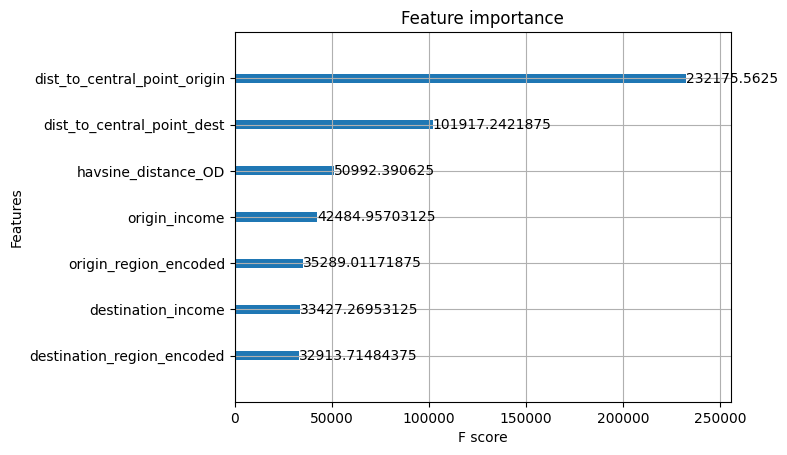

In [73]:
# 1. Prepare Data:
X = osrm_with_income[['destination_income', 'origin_income', 'origin_region_encoded',
                       'destination_region_encoded', 'dist_to_central_point_origin', 
                       'dist_to_central_point_dest', 'havsine_distance_OD']]
y = osrm_with_income['re_diff_tt']

# Split into training and testing sets (optional, but recommended)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Create DMatrix (XGBoost's optimized data structure)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)  # If you've split the data

# 3. Set Hyperparameters (Tune these for optimal performance)
params = {
    'objective': 'reg:squarederror',  # For regression tasks
    'eval_metric': 'rmse',  # Evaluation metric (root mean squared error)
    'eta': 0.1,   # Learning rate (adjust as needed)
    'max_depth': 3,  # Maximum depth of trees
}

# 4. Train and Evaluate:
num_rounds = 100  # Number of training rounds
watchlist = [(dtrain, 'train'), (dtest, 'eval')]  # For evaluation during training
model = xgb.train(params, dtrain, num_rounds, watchlist, early_stopping_rounds=10)  # Early stopping for overfitting prevention

# 5. Model Summary:
print("XGBoost Model Summary:")
print(model.get_dump(with_stats=True))  # Detailed model structure with statistics

# 6. Training and Testing RMSE:
train_rmse = np.sqrt(mean_squared_error(y_train, model.predict(dtrain)))
test_rmse = np.sqrt(mean_squared_error(y_test, model.predict(dtest)))

print("\nTraining RMSE:", train_rmse)
print("Testing RMSE:", test_rmse)

# 7. Feature Importance:
importance = model.get_score(importance_type='gain')
xgb.plot_importance(importance)

## 5. Adding Population Density